# Deep Autoencoder
An autoencoder, in general, is a network that is trained to attempt to copy its input to its output. Internally, it has a **latent space** that describes a code used to represent the input. The network may be viewed as consisting of two parts: an **encoder** function $h=f(x)$ and a **decoder** that produces a reconstruction $r=g(h)$.

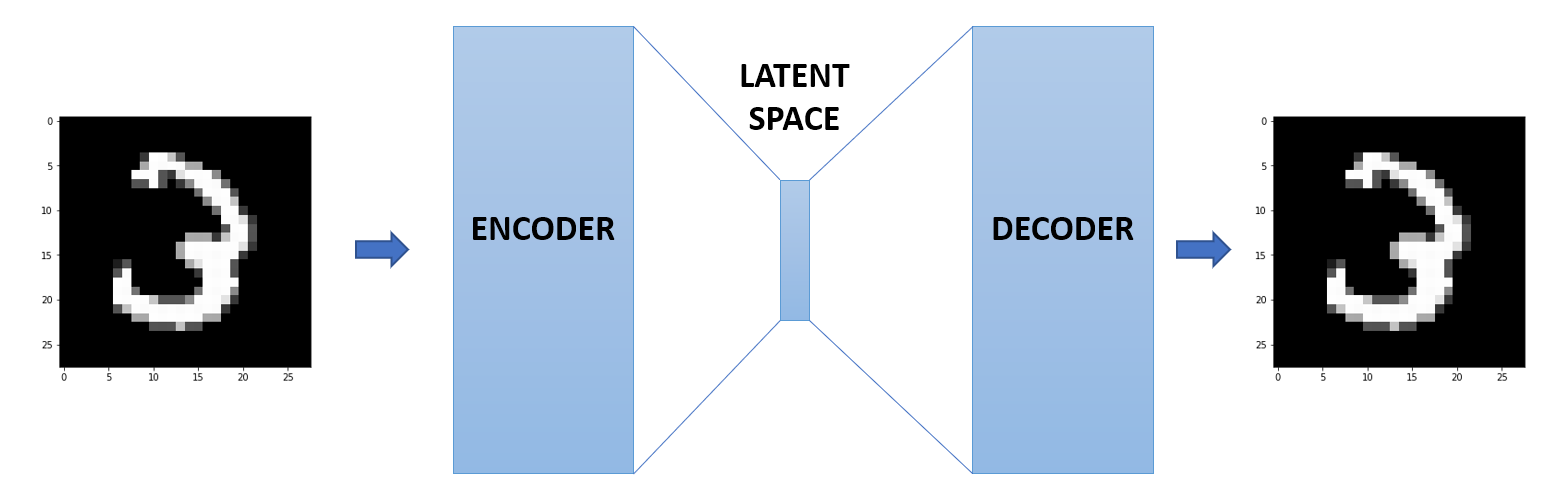

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import seaborn as sb 
sb.set_style( "darkgrid")

# Dataset

## Define the dataset

In [2]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Let's plot some random samples from the dataset. The first element of the sample is the actual image, while the second is the corresponding label.

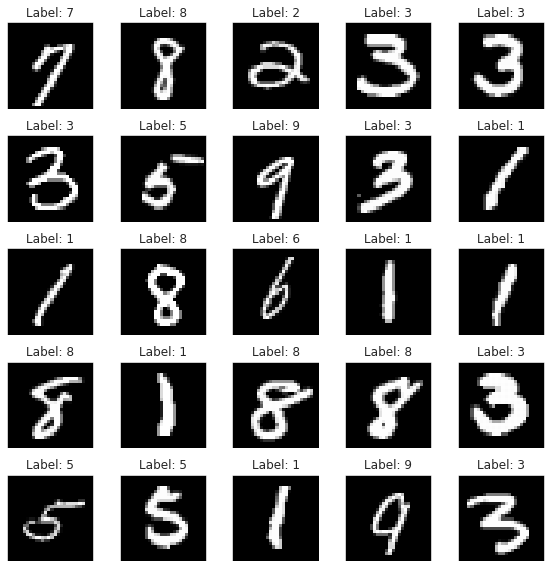

In [3]:
### Plot some sample
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Define the dataset transform

In this example we are using the input images without any modification. As always, the only requirement is to transform the input data to tensors of the proper shape.

In [4]:
# In this case the train_transform and test_transform are the same, but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])


In [5]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

## Define the dataloader

The dataloader allows to easily create batch of data, in this case we set a batch size of 256, and we also enable data shuffling for the training dataset.

In [6]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


# Autoencoder

## Encoder

In [7]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,dropout=0.5, conv1=8,conv2=16,conv3=32,fc=64):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, conv1, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Second convolutional layer
            nn.Conv2d(conv1, conv2, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Third convolutional layer
            nn.Conv2d(conv2, conv3, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)#dimension 0 is the sample, so we flatten from dimension 1

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * conv3, fc),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            # Second linear layer
            nn.Linear(fc, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

## Decoder

In [8]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,dropout=0.5, conv1=8,conv2=16,conv3=32,fc=64):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, fc),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            # Second linear layer
            nn.Linear(fc, 3 * 3 * conv3),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(conv3, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(conv3, conv2, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Second transposed convolution
            nn.ConvTranspose2d(conv2, conv1, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Third transposed convolution
            nn.ConvTranspose2d(conv1, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

Initialize the two networks.

In [9]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

Let's check if all the shapes are correct.

In [10]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 2])
Decoded image shape: torch.Size([1, 1, 28, 28])


# Training

In [11]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

### Set the random seed for reproducible results
torch.manual_seed(0)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=288, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Dropout2d(p=0.5, inplace=False)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Dropout2d(p=0.5, inplace=False)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## Training function

In [12]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))

    return loss.data

## Testing function

In [13]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

## Training loop

In [14]:
### Training cycle
def training_cycle(num_epochs,early_stopping,encoder,decoder,loss_fn,optim,train_dataloader,device,test_dataset):
    train_loss_log = []
    val_loss_log = []
    
    #early stopping
    max_early=float("-inf")
    idx_early=-1
    for epoch in range(num_epochs):
        print('EPOCH %d/%d' % (epoch + 1, num_epochs))
        ### Training (use the training function)
        train_loss=train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
      
        train_loss_log.append(train_loss)
        ### Validation  (use the testing function)
        val_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn)
        
        val_loss_log.append(val_loss)
        # Print Validationloss
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

        ### Plot progress
        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset[0][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[0].set_title('Original image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.grid()
        plt.pause(0.1)
        # Save figures
        os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
        fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
        plt.show()
        plt.close()

        # Save network parameters
        torch.save(encoder.state_dict(), 'encoder_params.pth')
        torch.save(decoder.state_dict(), 'decoder_params.pth')
        torch.save(optim.state_dict(), 'optim_params.pth')
        
        #Early stopping:
        if idx_early==-1:
            idx_early=epoch
            max_early=val_loss
        elif round(float(val_loss),3)<round(float(max_early),3):
            idx_early=epoch
            max_early=val_loss
            
        elif epoch-idx_early>=early_stopping:
            print("STOPPED BY EARLY STOPPYNG")
            break

    return (train_loss_log,val_loss_log)


## Hyperparameter optimization

In [15]:
space_dim = [2]
num_epochs=40
early_stopping=35
Conv1=[8,16, 32, 64]
Conv2=[16, 32, 64]
Conv3=[32, 64]
FC=[32, 64]
LR=[1e-5, 1e-4, 1e-3]
L2=[1e-5, 1e-4, 1e-3]
drop=[0.1, 0.5]

In [17]:
hyperparams = [space_dim,Conv1,Conv2,Conv3,FC,LR,L2, drop]  

iterations=[]
import itertools
for hyper in itertools.product(*hyperparams):
    iterations.append(hyper)
print("Total Combinations:",len(iterations))


Total Combinations: 1




Iteration: 0 (2, 8, 16, 64, 64, 0.001, 1e-05, 0.1)
EPOCH 1/100
	 partial train loss (single batch): 0.188520
	 partial train loss (single batch): 0.188464
	 partial train loss (single batch): 0.187496
	 partial train loss (single batch): 0.186633
	 partial train loss (single batch): 0.186352
	 partial train loss (single batch): 0.185769
	 partial train loss (single batch): 0.184768
	 partial train loss (single batch): 0.184432
	 partial train loss (single batch): 0.182989
	 partial train loss (single batch): 0.181855
	 partial train loss (single batch): 0.180499
	 partial train loss (single batch): 0.179315
	 partial train loss (single batch): 0.177695
	 partial train loss (single batch): 0.174414
	 partial train loss (single batch): 0.172298
	 partial train loss (single batch): 0.169582
	 partial train loss (single batch): 0.164594
	 partial train loss (single batch): 0.158735
	 partial train loss (single batch): 0.154062
	 partial train loss (single batch): 0.146151
	 partial train

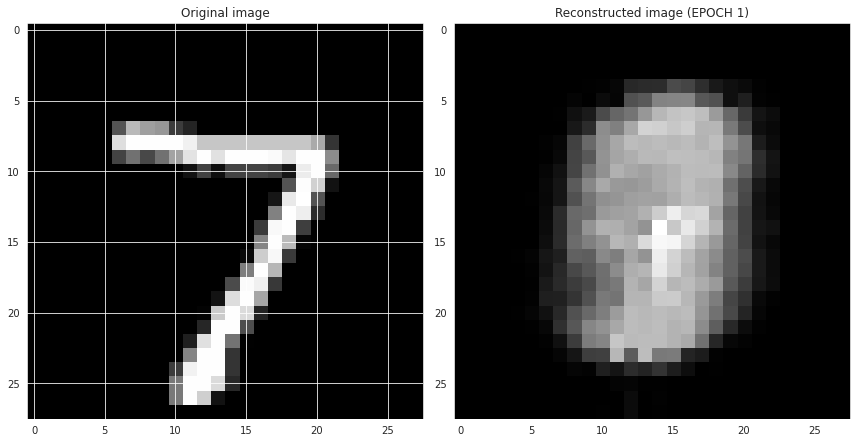

EPOCH 2/100
	 partial train loss (single batch): 0.066337
	 partial train loss (single batch): 0.068864
	 partial train loss (single batch): 0.068407
	 partial train loss (single batch): 0.064873
	 partial train loss (single batch): 0.066110
	 partial train loss (single batch): 0.064667
	 partial train loss (single batch): 0.065097
	 partial train loss (single batch): 0.064859
	 partial train loss (single batch): 0.068067
	 partial train loss (single batch): 0.064720
	 partial train loss (single batch): 0.065299
	 partial train loss (single batch): 0.065587
	 partial train loss (single batch): 0.067947
	 partial train loss (single batch): 0.066356
	 partial train loss (single batch): 0.063507
	 partial train loss (single batch): 0.065243
	 partial train loss (single batch): 0.063991
	 partial train loss (single batch): 0.065244
	 partial train loss (single batch): 0.066655
	 partial train loss (single batch): 0.065081
	 partial train loss (single batch): 0.063105
	 partial train loss (

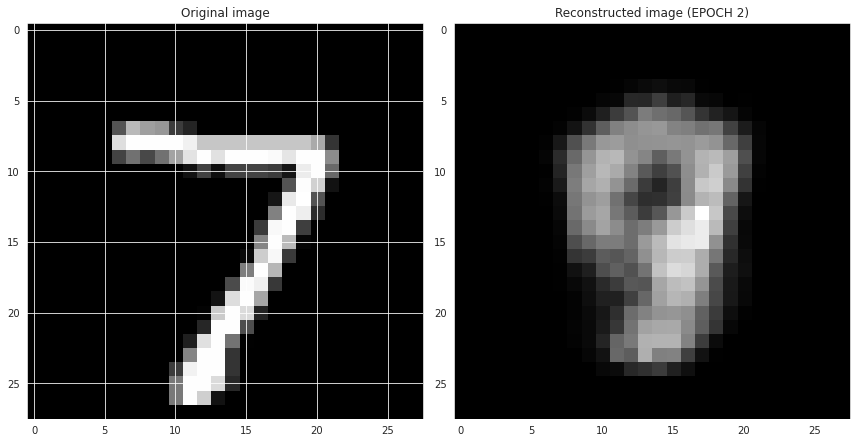

EPOCH 3/100
	 partial train loss (single batch): 0.057059
	 partial train loss (single batch): 0.057578
	 partial train loss (single batch): 0.056496
	 partial train loss (single batch): 0.057101
	 partial train loss (single batch): 0.058520
	 partial train loss (single batch): 0.056844
	 partial train loss (single batch): 0.059882
	 partial train loss (single batch): 0.057869
	 partial train loss (single batch): 0.056022
	 partial train loss (single batch): 0.056729
	 partial train loss (single batch): 0.060456
	 partial train loss (single batch): 0.055846
	 partial train loss (single batch): 0.056650
	 partial train loss (single batch): 0.056043
	 partial train loss (single batch): 0.056378
	 partial train loss (single batch): 0.058346
	 partial train loss (single batch): 0.057311
	 partial train loss (single batch): 0.056493
	 partial train loss (single batch): 0.056122
	 partial train loss (single batch): 0.055856
	 partial train loss (single batch): 0.056541
	 partial train loss (

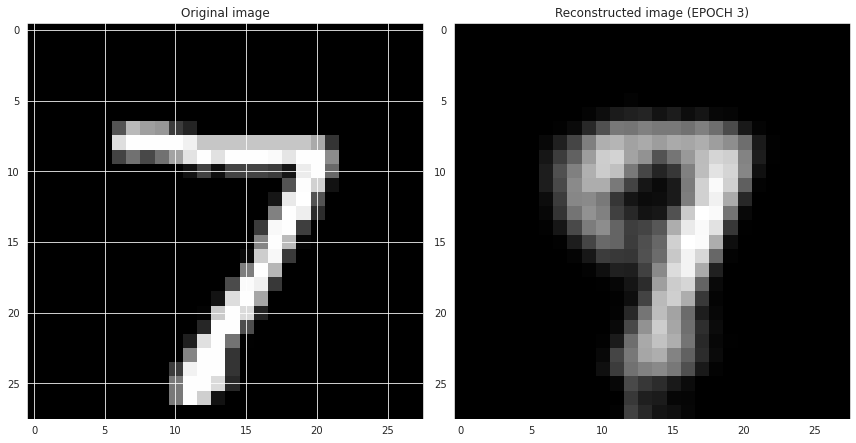

EPOCH 4/100
	 partial train loss (single batch): 0.053255
	 partial train loss (single batch): 0.052996
	 partial train loss (single batch): 0.054182
	 partial train loss (single batch): 0.052403
	 partial train loss (single batch): 0.051817
	 partial train loss (single batch): 0.053029
	 partial train loss (single batch): 0.050996
	 partial train loss (single batch): 0.053500
	 partial train loss (single batch): 0.053439
	 partial train loss (single batch): 0.052124
	 partial train loss (single batch): 0.049874
	 partial train loss (single batch): 0.053892
	 partial train loss (single batch): 0.052979
	 partial train loss (single batch): 0.053510
	 partial train loss (single batch): 0.052493
	 partial train loss (single batch): 0.054133
	 partial train loss (single batch): 0.053623
	 partial train loss (single batch): 0.050535
	 partial train loss (single batch): 0.051429
	 partial train loss (single batch): 0.050977
	 partial train loss (single batch): 0.054054
	 partial train loss (

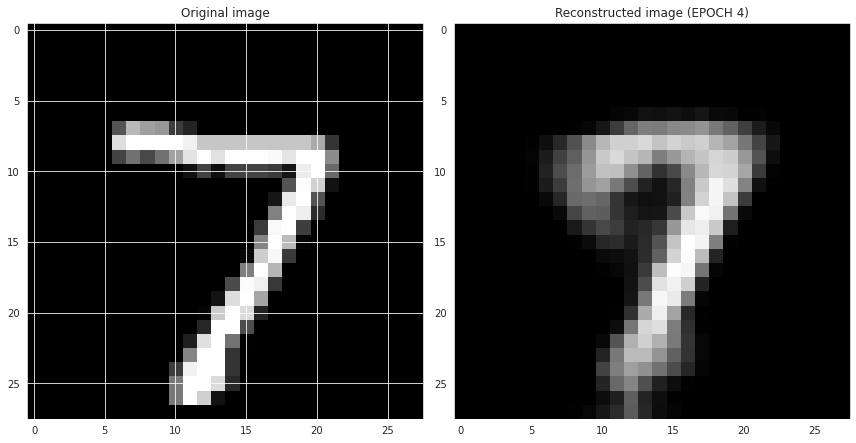

EPOCH 5/100
	 partial train loss (single batch): 0.049902
	 partial train loss (single batch): 0.051804
	 partial train loss (single batch): 0.049412
	 partial train loss (single batch): 0.051812
	 partial train loss (single batch): 0.051167
	 partial train loss (single batch): 0.051355
	 partial train loss (single batch): 0.048908
	 partial train loss (single batch): 0.049095
	 partial train loss (single batch): 0.050970
	 partial train loss (single batch): 0.049479
	 partial train loss (single batch): 0.050418
	 partial train loss (single batch): 0.051471
	 partial train loss (single batch): 0.051307
	 partial train loss (single batch): 0.048828
	 partial train loss (single batch): 0.050357
	 partial train loss (single batch): 0.048807
	 partial train loss (single batch): 0.050218
	 partial train loss (single batch): 0.048749
	 partial train loss (single batch): 0.048627
	 partial train loss (single batch): 0.049602
	 partial train loss (single batch): 0.050915
	 partial train loss (

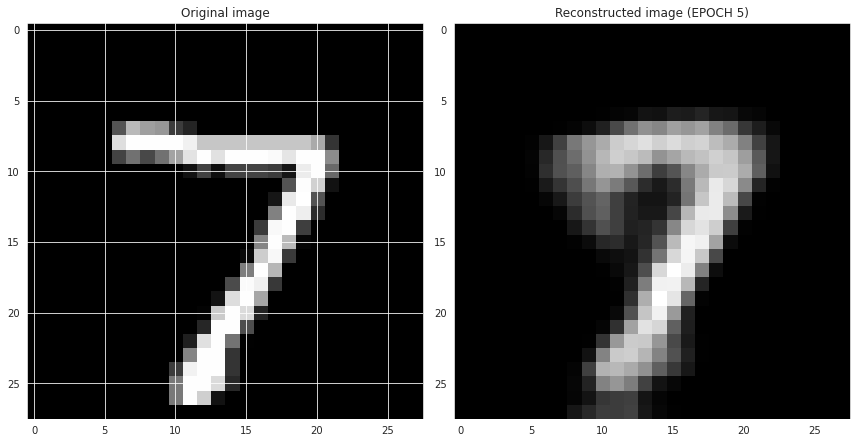

EPOCH 6/100
	 partial train loss (single batch): 0.048258
	 partial train loss (single batch): 0.048524
	 partial train loss (single batch): 0.049071
	 partial train loss (single batch): 0.049777
	 partial train loss (single batch): 0.047901
	 partial train loss (single batch): 0.048692
	 partial train loss (single batch): 0.046394
	 partial train loss (single batch): 0.049645
	 partial train loss (single batch): 0.050390
	 partial train loss (single batch): 0.048726
	 partial train loss (single batch): 0.048436
	 partial train loss (single batch): 0.050459
	 partial train loss (single batch): 0.051670
	 partial train loss (single batch): 0.049058
	 partial train loss (single batch): 0.049711
	 partial train loss (single batch): 0.048804
	 partial train loss (single batch): 0.050569
	 partial train loss (single batch): 0.047431
	 partial train loss (single batch): 0.049512
	 partial train loss (single batch): 0.047870
	 partial train loss (single batch): 0.051652
	 partial train loss (

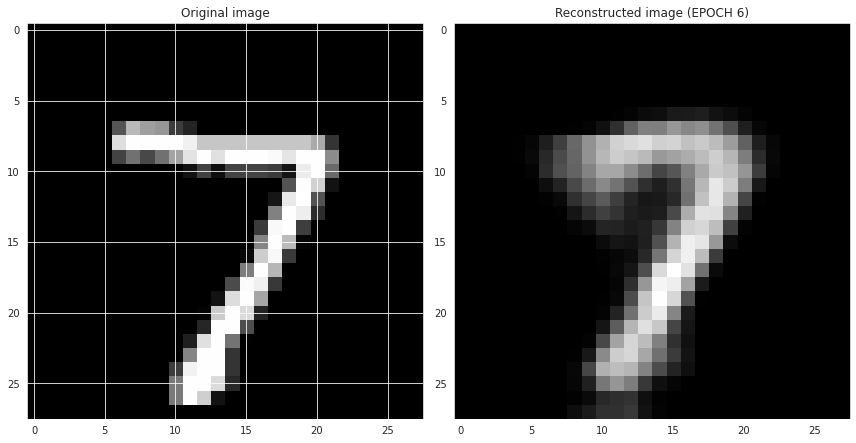

EPOCH 7/100
	 partial train loss (single batch): 0.048553
	 partial train loss (single batch): 0.048603
	 partial train loss (single batch): 0.046953
	 partial train loss (single batch): 0.048285
	 partial train loss (single batch): 0.046953
	 partial train loss (single batch): 0.047672
	 partial train loss (single batch): 0.049706
	 partial train loss (single batch): 0.048861
	 partial train loss (single batch): 0.047815
	 partial train loss (single batch): 0.048420
	 partial train loss (single batch): 0.048508
	 partial train loss (single batch): 0.050325
	 partial train loss (single batch): 0.046557
	 partial train loss (single batch): 0.046388
	 partial train loss (single batch): 0.048168
	 partial train loss (single batch): 0.048639
	 partial train loss (single batch): 0.047033
	 partial train loss (single batch): 0.047422
	 partial train loss (single batch): 0.049542
	 partial train loss (single batch): 0.046119
	 partial train loss (single batch): 0.048772
	 partial train loss (

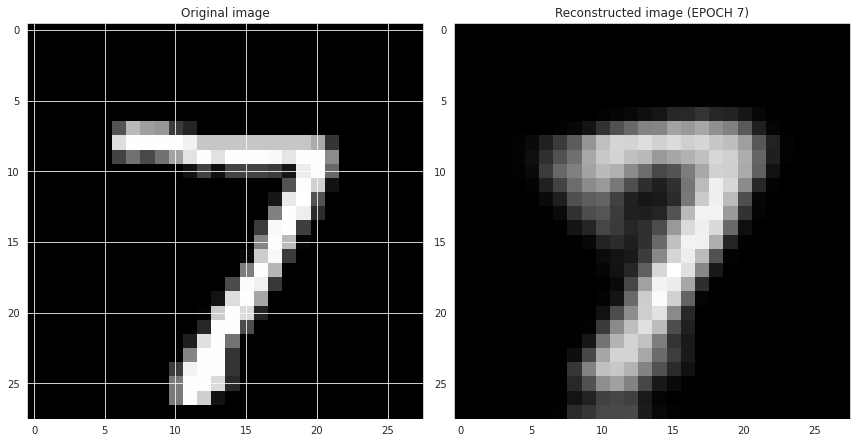

EPOCH 8/100
	 partial train loss (single batch): 0.045707
	 partial train loss (single batch): 0.047545
	 partial train loss (single batch): 0.044377
	 partial train loss (single batch): 0.047729
	 partial train loss (single batch): 0.048750
	 partial train loss (single batch): 0.049318
	 partial train loss (single batch): 0.048813
	 partial train loss (single batch): 0.044698
	 partial train loss (single batch): 0.045667
	 partial train loss (single batch): 0.047622
	 partial train loss (single batch): 0.045339
	 partial train loss (single batch): 0.048411
	 partial train loss (single batch): 0.046734
	 partial train loss (single batch): 0.045330
	 partial train loss (single batch): 0.046729
	 partial train loss (single batch): 0.047237
	 partial train loss (single batch): 0.046121
	 partial train loss (single batch): 0.046499
	 partial train loss (single batch): 0.047273
	 partial train loss (single batch): 0.047596
	 partial train loss (single batch): 0.046285
	 partial train loss (

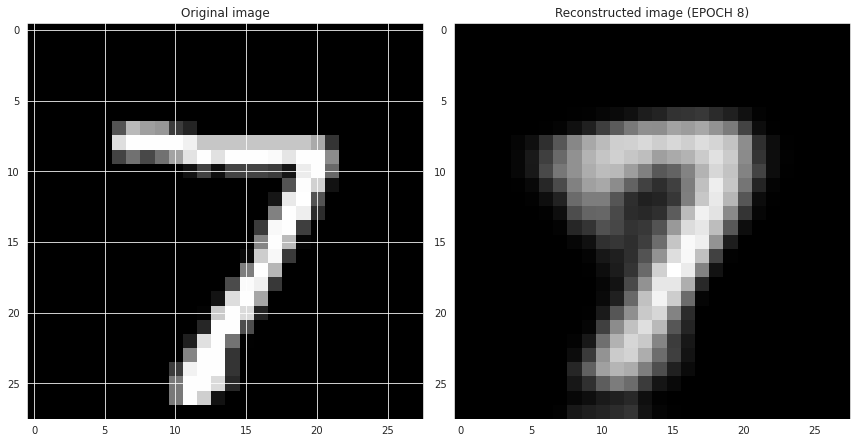

EPOCH 9/100
	 partial train loss (single batch): 0.045505
	 partial train loss (single batch): 0.047256
	 partial train loss (single batch): 0.046542
	 partial train loss (single batch): 0.046890
	 partial train loss (single batch): 0.046358
	 partial train loss (single batch): 0.047418
	 partial train loss (single batch): 0.046725
	 partial train loss (single batch): 0.046646
	 partial train loss (single batch): 0.047273
	 partial train loss (single batch): 0.046355
	 partial train loss (single batch): 0.047257
	 partial train loss (single batch): 0.046392
	 partial train loss (single batch): 0.047688
	 partial train loss (single batch): 0.047869
	 partial train loss (single batch): 0.045411
	 partial train loss (single batch): 0.044489
	 partial train loss (single batch): 0.045369
	 partial train loss (single batch): 0.047184
	 partial train loss (single batch): 0.046032
	 partial train loss (single batch): 0.047182
	 partial train loss (single batch): 0.046862
	 partial train loss (

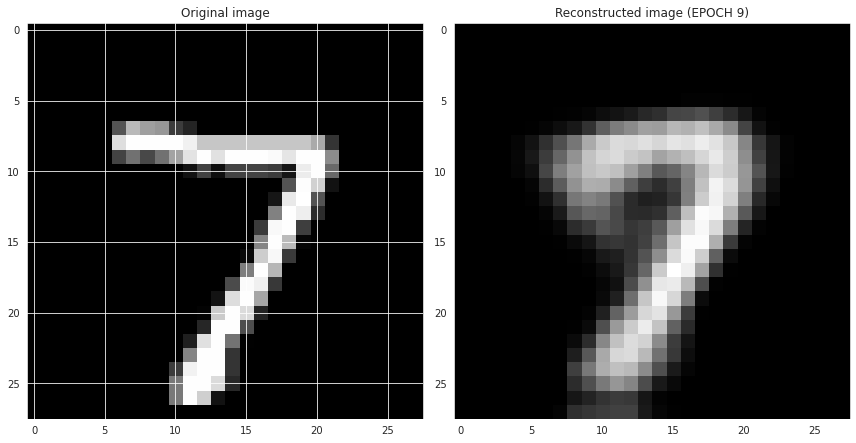

EPOCH 10/100
	 partial train loss (single batch): 0.046242
	 partial train loss (single batch): 0.046299
	 partial train loss (single batch): 0.046794
	 partial train loss (single batch): 0.047687
	 partial train loss (single batch): 0.047150
	 partial train loss (single batch): 0.045868
	 partial train loss (single batch): 0.045870
	 partial train loss (single batch): 0.045251
	 partial train loss (single batch): 0.045198
	 partial train loss (single batch): 0.046241
	 partial train loss (single batch): 0.046625
	 partial train loss (single batch): 0.046652
	 partial train loss (single batch): 0.046505
	 partial train loss (single batch): 0.044160
	 partial train loss (single batch): 0.047279
	 partial train loss (single batch): 0.043394
	 partial train loss (single batch): 0.045060
	 partial train loss (single batch): 0.046288
	 partial train loss (single batch): 0.045959
	 partial train loss (single batch): 0.045183
	 partial train loss (single batch): 0.045891
	 partial train loss 

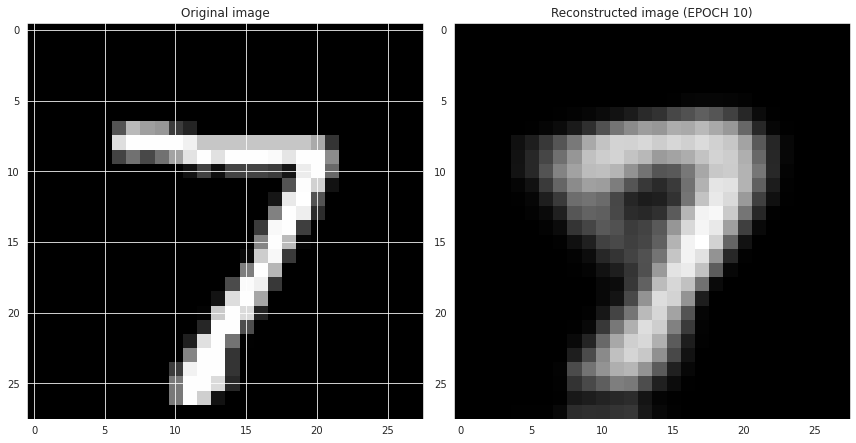

EPOCH 11/100
	 partial train loss (single batch): 0.045663
	 partial train loss (single batch): 0.043110
	 partial train loss (single batch): 0.044465
	 partial train loss (single batch): 0.046773
	 partial train loss (single batch): 0.046353
	 partial train loss (single batch): 0.046123
	 partial train loss (single batch): 0.042781
	 partial train loss (single batch): 0.047197
	 partial train loss (single batch): 0.045384
	 partial train loss (single batch): 0.045661
	 partial train loss (single batch): 0.045426
	 partial train loss (single batch): 0.045341
	 partial train loss (single batch): 0.046326
	 partial train loss (single batch): 0.047003
	 partial train loss (single batch): 0.046789
	 partial train loss (single batch): 0.045071
	 partial train loss (single batch): 0.046798
	 partial train loss (single batch): 0.046446
	 partial train loss (single batch): 0.044168
	 partial train loss (single batch): 0.043727
	 partial train loss (single batch): 0.043766
	 partial train loss 

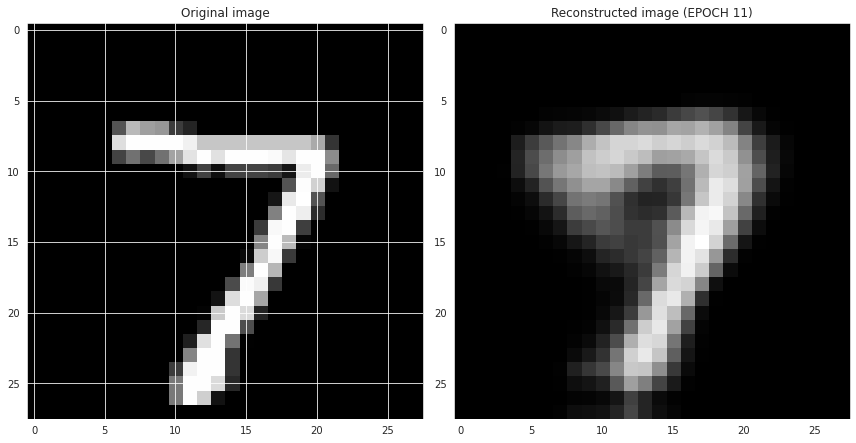

EPOCH 12/100
	 partial train loss (single batch): 0.046472
	 partial train loss (single batch): 0.044643
	 partial train loss (single batch): 0.044996
	 partial train loss (single batch): 0.043306
	 partial train loss (single batch): 0.045454
	 partial train loss (single batch): 0.044649
	 partial train loss (single batch): 0.042941
	 partial train loss (single batch): 0.044265
	 partial train loss (single batch): 0.046218
	 partial train loss (single batch): 0.045450
	 partial train loss (single batch): 0.045438
	 partial train loss (single batch): 0.045675
	 partial train loss (single batch): 0.045834
	 partial train loss (single batch): 0.043602
	 partial train loss (single batch): 0.044976
	 partial train loss (single batch): 0.046827
	 partial train loss (single batch): 0.045208
	 partial train loss (single batch): 0.043351
	 partial train loss (single batch): 0.044904
	 partial train loss (single batch): 0.046380
	 partial train loss (single batch): 0.043630
	 partial train loss 

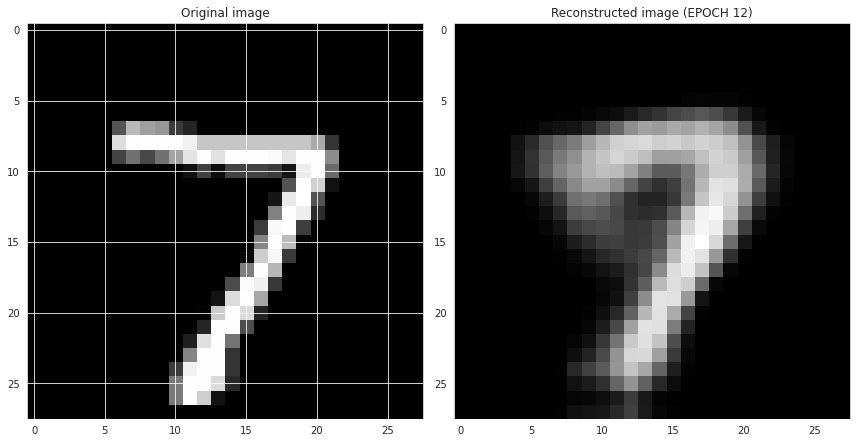

EPOCH 13/100
	 partial train loss (single batch): 0.043665
	 partial train loss (single batch): 0.045237
	 partial train loss (single batch): 0.044428
	 partial train loss (single batch): 0.044483
	 partial train loss (single batch): 0.045076
	 partial train loss (single batch): 0.043938
	 partial train loss (single batch): 0.047378
	 partial train loss (single batch): 0.042195
	 partial train loss (single batch): 0.044523
	 partial train loss (single batch): 0.044634
	 partial train loss (single batch): 0.044651
	 partial train loss (single batch): 0.046052
	 partial train loss (single batch): 0.043442
	 partial train loss (single batch): 0.046274
	 partial train loss (single batch): 0.045744
	 partial train loss (single batch): 0.045008
	 partial train loss (single batch): 0.044044
	 partial train loss (single batch): 0.044074
	 partial train loss (single batch): 0.044598
	 partial train loss (single batch): 0.044598
	 partial train loss (single batch): 0.044631
	 partial train loss 

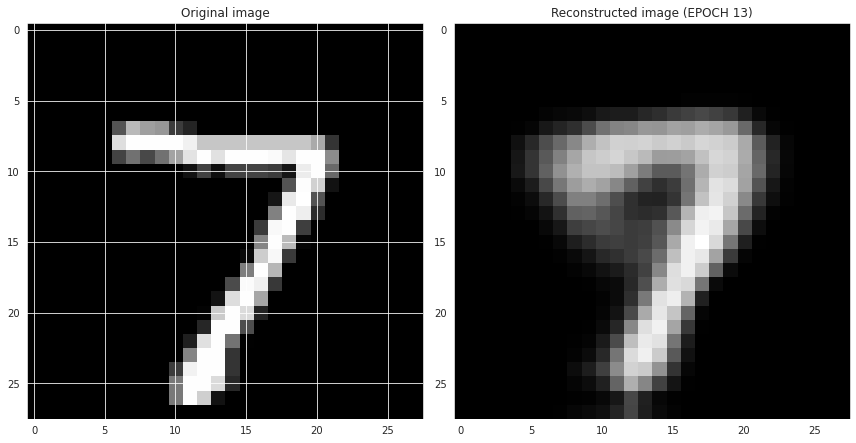

EPOCH 14/100
	 partial train loss (single batch): 0.044194
	 partial train loss (single batch): 0.045902
	 partial train loss (single batch): 0.044895
	 partial train loss (single batch): 0.045687
	 partial train loss (single batch): 0.042905
	 partial train loss (single batch): 0.043878
	 partial train loss (single batch): 0.045284
	 partial train loss (single batch): 0.046669
	 partial train loss (single batch): 0.043283
	 partial train loss (single batch): 0.043730
	 partial train loss (single batch): 0.044621
	 partial train loss (single batch): 0.044834
	 partial train loss (single batch): 0.044098
	 partial train loss (single batch): 0.045588
	 partial train loss (single batch): 0.044263
	 partial train loss (single batch): 0.044751
	 partial train loss (single batch): 0.045246
	 partial train loss (single batch): 0.044246
	 partial train loss (single batch): 0.046358
	 partial train loss (single batch): 0.043337
	 partial train loss (single batch): 0.044265
	 partial train loss 

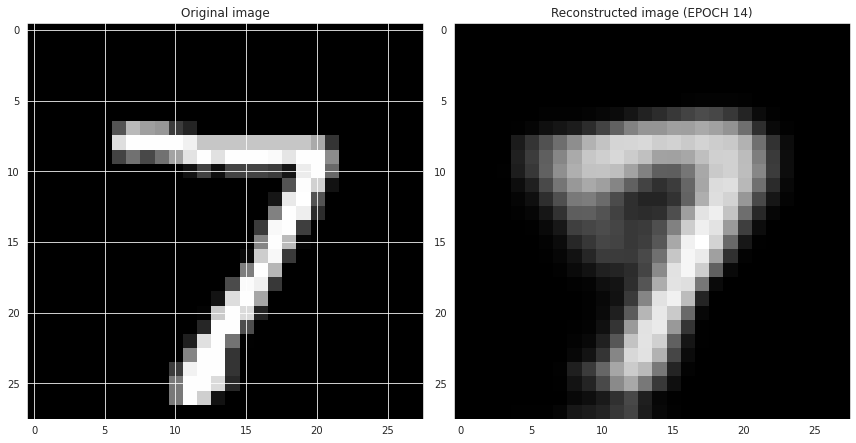

EPOCH 15/100
	 partial train loss (single batch): 0.044727
	 partial train loss (single batch): 0.045152
	 partial train loss (single batch): 0.044341
	 partial train loss (single batch): 0.044021
	 partial train loss (single batch): 0.046165
	 partial train loss (single batch): 0.047204
	 partial train loss (single batch): 0.043771
	 partial train loss (single batch): 0.046500
	 partial train loss (single batch): 0.042708
	 partial train loss (single batch): 0.043664
	 partial train loss (single batch): 0.042291
	 partial train loss (single batch): 0.043443
	 partial train loss (single batch): 0.041681
	 partial train loss (single batch): 0.045981
	 partial train loss (single batch): 0.044521
	 partial train loss (single batch): 0.044509
	 partial train loss (single batch): 0.044147
	 partial train loss (single batch): 0.045395
	 partial train loss (single batch): 0.043953
	 partial train loss (single batch): 0.045412
	 partial train loss (single batch): 0.043744
	 partial train loss 

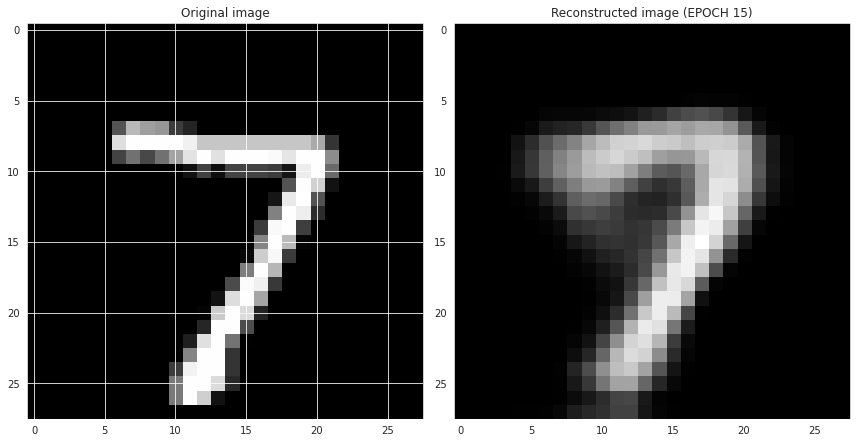

EPOCH 16/100
	 partial train loss (single batch): 0.044506
	 partial train loss (single batch): 0.044004
	 partial train loss (single batch): 0.044143
	 partial train loss (single batch): 0.042531
	 partial train loss (single batch): 0.044948
	 partial train loss (single batch): 0.043090
	 partial train loss (single batch): 0.046742
	 partial train loss (single batch): 0.044400
	 partial train loss (single batch): 0.043604
	 partial train loss (single batch): 0.044208
	 partial train loss (single batch): 0.043733
	 partial train loss (single batch): 0.043564
	 partial train loss (single batch): 0.043836
	 partial train loss (single batch): 0.044772
	 partial train loss (single batch): 0.042602
	 partial train loss (single batch): 0.043564
	 partial train loss (single batch): 0.045506
	 partial train loss (single batch): 0.044172
	 partial train loss (single batch): 0.044317
	 partial train loss (single batch): 0.043780
	 partial train loss (single batch): 0.045557
	 partial train loss 

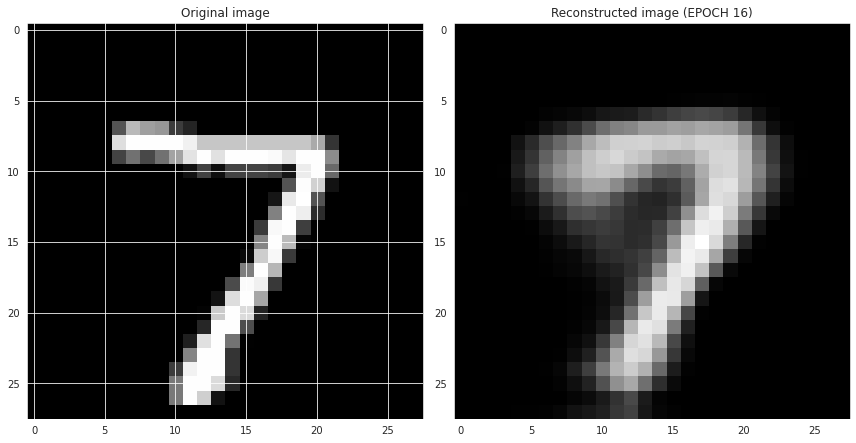

EPOCH 17/100
	 partial train loss (single batch): 0.042510
	 partial train loss (single batch): 0.043922
	 partial train loss (single batch): 0.044197
	 partial train loss (single batch): 0.046850
	 partial train loss (single batch): 0.043837
	 partial train loss (single batch): 0.045280
	 partial train loss (single batch): 0.044718
	 partial train loss (single batch): 0.044111
	 partial train loss (single batch): 0.044793
	 partial train loss (single batch): 0.044586
	 partial train loss (single batch): 0.043581
	 partial train loss (single batch): 0.044604
	 partial train loss (single batch): 0.045174
	 partial train loss (single batch): 0.044161
	 partial train loss (single batch): 0.044437
	 partial train loss (single batch): 0.044893
	 partial train loss (single batch): 0.043576
	 partial train loss (single batch): 0.043213
	 partial train loss (single batch): 0.042854
	 partial train loss (single batch): 0.042581
	 partial train loss (single batch): 0.043419
	 partial train loss 

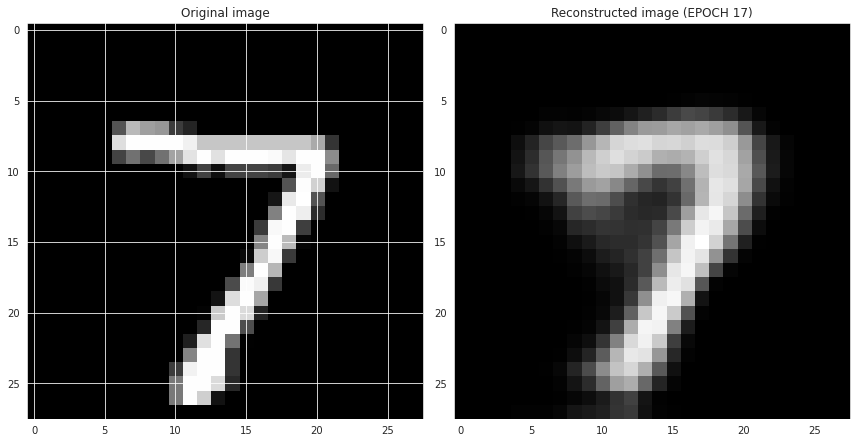

EPOCH 18/100
	 partial train loss (single batch): 0.042790
	 partial train loss (single batch): 0.042935
	 partial train loss (single batch): 0.044628
	 partial train loss (single batch): 0.044699
	 partial train loss (single batch): 0.042770
	 partial train loss (single batch): 0.042227
	 partial train loss (single batch): 0.043211
	 partial train loss (single batch): 0.045402
	 partial train loss (single batch): 0.043689
	 partial train loss (single batch): 0.044205
	 partial train loss (single batch): 0.044013
	 partial train loss (single batch): 0.045036
	 partial train loss (single batch): 0.043764
	 partial train loss (single batch): 0.044962
	 partial train loss (single batch): 0.043353
	 partial train loss (single batch): 0.043604
	 partial train loss (single batch): 0.044913
	 partial train loss (single batch): 0.043085
	 partial train loss (single batch): 0.044279
	 partial train loss (single batch): 0.043774
	 partial train loss (single batch): 0.044403
	 partial train loss 

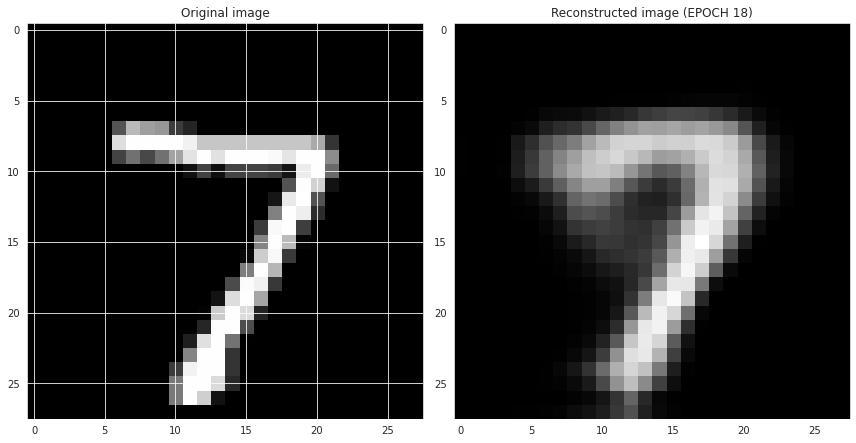

EPOCH 19/100
	 partial train loss (single batch): 0.042851
	 partial train loss (single batch): 0.044626
	 partial train loss (single batch): 0.042337
	 partial train loss (single batch): 0.043475
	 partial train loss (single batch): 0.044934
	 partial train loss (single batch): 0.041450
	 partial train loss (single batch): 0.044427
	 partial train loss (single batch): 0.043768
	 partial train loss (single batch): 0.044495
	 partial train loss (single batch): 0.044542
	 partial train loss (single batch): 0.044177
	 partial train loss (single batch): 0.042436
	 partial train loss (single batch): 0.043511
	 partial train loss (single batch): 0.042304
	 partial train loss (single batch): 0.044896
	 partial train loss (single batch): 0.043661
	 partial train loss (single batch): 0.043007
	 partial train loss (single batch): 0.042344
	 partial train loss (single batch): 0.043361
	 partial train loss (single batch): 0.043635
	 partial train loss (single batch): 0.043655
	 partial train loss 

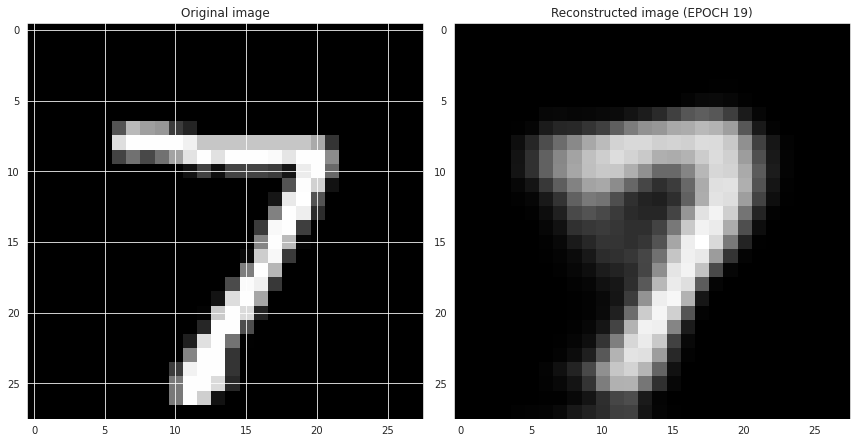

EPOCH 20/100
	 partial train loss (single batch): 0.042016
	 partial train loss (single batch): 0.043785
	 partial train loss (single batch): 0.043926
	 partial train loss (single batch): 0.044253
	 partial train loss (single batch): 0.042764
	 partial train loss (single batch): 0.043664
	 partial train loss (single batch): 0.044371
	 partial train loss (single batch): 0.043514
	 partial train loss (single batch): 0.042951
	 partial train loss (single batch): 0.044093
	 partial train loss (single batch): 0.043841
	 partial train loss (single batch): 0.044765
	 partial train loss (single batch): 0.044201
	 partial train loss (single batch): 0.044278
	 partial train loss (single batch): 0.042523
	 partial train loss (single batch): 0.044932
	 partial train loss (single batch): 0.042266
	 partial train loss (single batch): 0.044346
	 partial train loss (single batch): 0.042773
	 partial train loss (single batch): 0.043197
	 partial train loss (single batch): 0.043525
	 partial train loss 

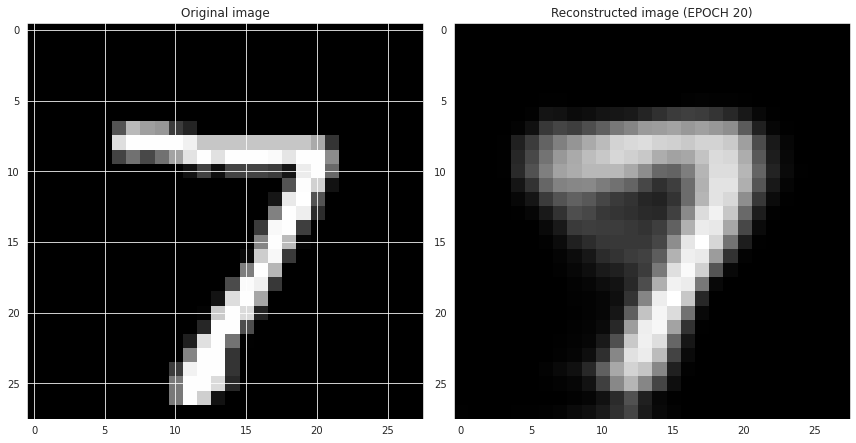

EPOCH 21/100
	 partial train loss (single batch): 0.044470
	 partial train loss (single batch): 0.045346
	 partial train loss (single batch): 0.043599
	 partial train loss (single batch): 0.044997
	 partial train loss (single batch): 0.044522
	 partial train loss (single batch): 0.042983
	 partial train loss (single batch): 0.042754
	 partial train loss (single batch): 0.044212
	 partial train loss (single batch): 0.042336
	 partial train loss (single batch): 0.043572
	 partial train loss (single batch): 0.043664
	 partial train loss (single batch): 0.043413
	 partial train loss (single batch): 0.043851
	 partial train loss (single batch): 0.042266
	 partial train loss (single batch): 0.044785
	 partial train loss (single batch): 0.043436
	 partial train loss (single batch): 0.042285
	 partial train loss (single batch): 0.043099
	 partial train loss (single batch): 0.042263
	 partial train loss (single batch): 0.044652
	 partial train loss (single batch): 0.042375
	 partial train loss 

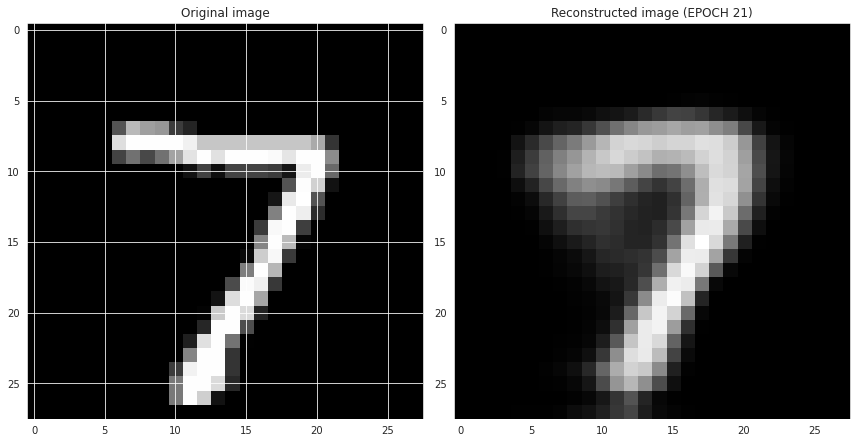

EPOCH 22/100
	 partial train loss (single batch): 0.042242
	 partial train loss (single batch): 0.043270
	 partial train loss (single batch): 0.044558
	 partial train loss (single batch): 0.042396
	 partial train loss (single batch): 0.045066
	 partial train loss (single batch): 0.043674
	 partial train loss (single batch): 0.044962
	 partial train loss (single batch): 0.044321
	 partial train loss (single batch): 0.043538
	 partial train loss (single batch): 0.044038
	 partial train loss (single batch): 0.044574
	 partial train loss (single batch): 0.042208
	 partial train loss (single batch): 0.040444
	 partial train loss (single batch): 0.043168
	 partial train loss (single batch): 0.043378
	 partial train loss (single batch): 0.043664
	 partial train loss (single batch): 0.041868
	 partial train loss (single batch): 0.042906
	 partial train loss (single batch): 0.044620
	 partial train loss (single batch): 0.044850
	 partial train loss (single batch): 0.043138
	 partial train loss 

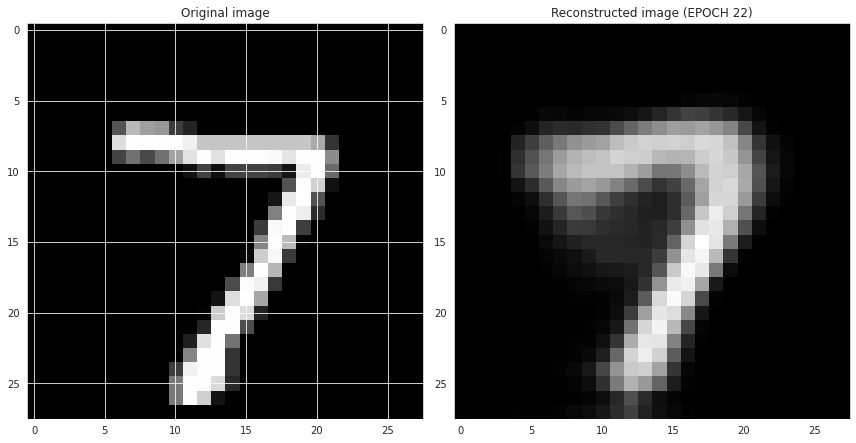

EPOCH 23/100
	 partial train loss (single batch): 0.041728
	 partial train loss (single batch): 0.042981
	 partial train loss (single batch): 0.042832
	 partial train loss (single batch): 0.043366
	 partial train loss (single batch): 0.043165
	 partial train loss (single batch): 0.044194
	 partial train loss (single batch): 0.043682
	 partial train loss (single batch): 0.043614
	 partial train loss (single batch): 0.044796
	 partial train loss (single batch): 0.043138
	 partial train loss (single batch): 0.043608
	 partial train loss (single batch): 0.042513
	 partial train loss (single batch): 0.042847
	 partial train loss (single batch): 0.043404
	 partial train loss (single batch): 0.043347
	 partial train loss (single batch): 0.042407
	 partial train loss (single batch): 0.044177
	 partial train loss (single batch): 0.043615
	 partial train loss (single batch): 0.043384
	 partial train loss (single batch): 0.043498
	 partial train loss (single batch): 0.041721
	 partial train loss 

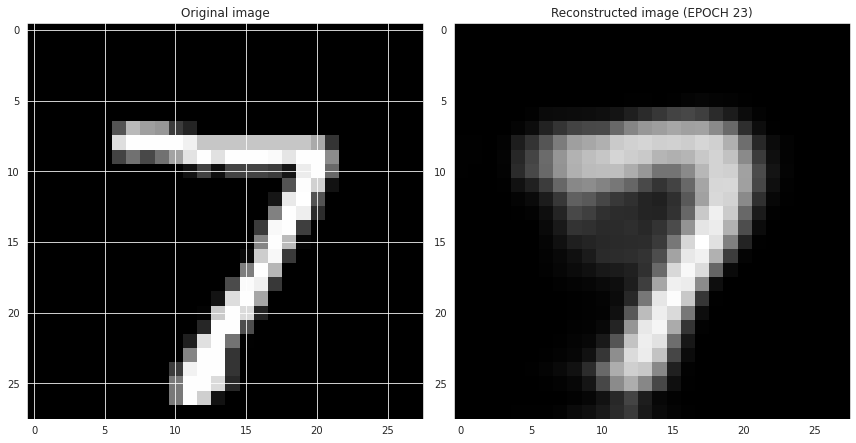

EPOCH 24/100
	 partial train loss (single batch): 0.043271
	 partial train loss (single batch): 0.041503
	 partial train loss (single batch): 0.043973
	 partial train loss (single batch): 0.044281
	 partial train loss (single batch): 0.041644
	 partial train loss (single batch): 0.043103
	 partial train loss (single batch): 0.042204
	 partial train loss (single batch): 0.044734
	 partial train loss (single batch): 0.042580
	 partial train loss (single batch): 0.044229
	 partial train loss (single batch): 0.042916
	 partial train loss (single batch): 0.043165
	 partial train loss (single batch): 0.041828
	 partial train loss (single batch): 0.044716
	 partial train loss (single batch): 0.042620
	 partial train loss (single batch): 0.043342
	 partial train loss (single batch): 0.044061
	 partial train loss (single batch): 0.045087
	 partial train loss (single batch): 0.043872
	 partial train loss (single batch): 0.043878
	 partial train loss (single batch): 0.041726
	 partial train loss 

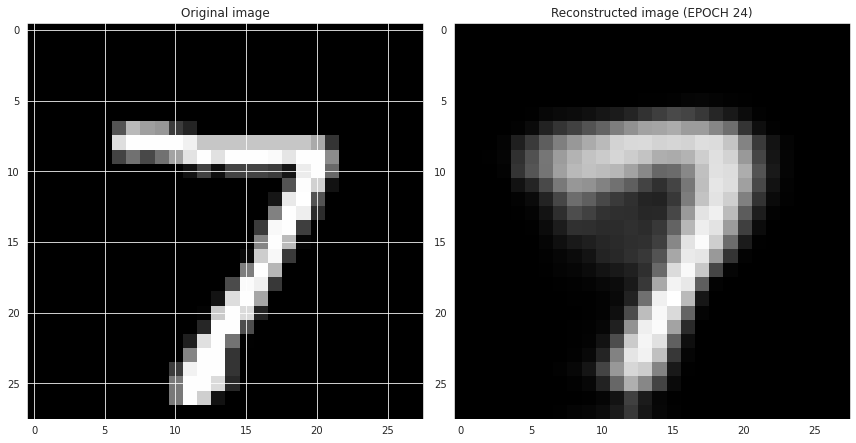

EPOCH 25/100
	 partial train loss (single batch): 0.042588
	 partial train loss (single batch): 0.043688
	 partial train loss (single batch): 0.041538
	 partial train loss (single batch): 0.044800
	 partial train loss (single batch): 0.042843
	 partial train loss (single batch): 0.041765
	 partial train loss (single batch): 0.044112
	 partial train loss (single batch): 0.042820
	 partial train loss (single batch): 0.042453
	 partial train loss (single batch): 0.042643
	 partial train loss (single batch): 0.044671
	 partial train loss (single batch): 0.043860
	 partial train loss (single batch): 0.042704
	 partial train loss (single batch): 0.041981
	 partial train loss (single batch): 0.042051
	 partial train loss (single batch): 0.042439
	 partial train loss (single batch): 0.042405
	 partial train loss (single batch): 0.043931
	 partial train loss (single batch): 0.044266
	 partial train loss (single batch): 0.042851
	 partial train loss (single batch): 0.041839
	 partial train loss 

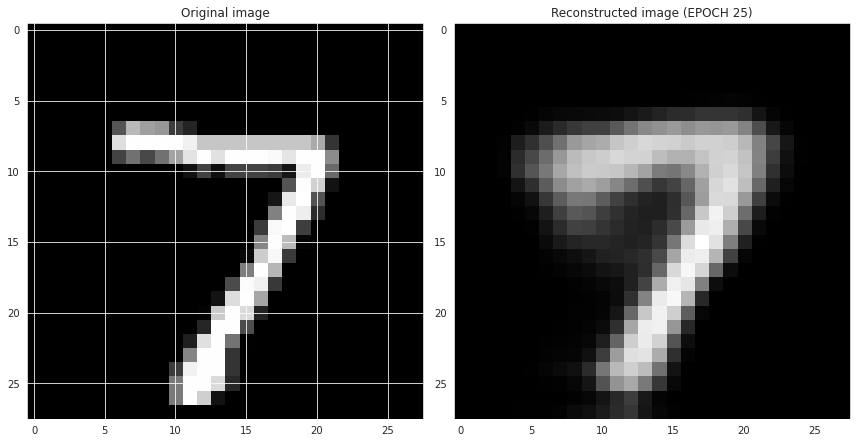

EPOCH 26/100
	 partial train loss (single batch): 0.042278
	 partial train loss (single batch): 0.043749
	 partial train loss (single batch): 0.044234
	 partial train loss (single batch): 0.042797
	 partial train loss (single batch): 0.043900
	 partial train loss (single batch): 0.041243
	 partial train loss (single batch): 0.043658
	 partial train loss (single batch): 0.042927
	 partial train loss (single batch): 0.043281
	 partial train loss (single batch): 0.039986
	 partial train loss (single batch): 0.044193
	 partial train loss (single batch): 0.042093
	 partial train loss (single batch): 0.042024
	 partial train loss (single batch): 0.042167
	 partial train loss (single batch): 0.041747
	 partial train loss (single batch): 0.043826
	 partial train loss (single batch): 0.042025
	 partial train loss (single batch): 0.041377
	 partial train loss (single batch): 0.042113
	 partial train loss (single batch): 0.041685
	 partial train loss (single batch): 0.043687
	 partial train loss 

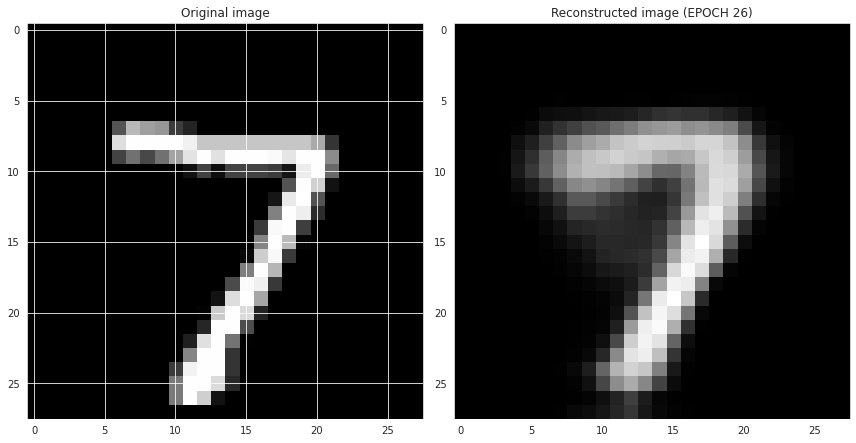

EPOCH 27/100
	 partial train loss (single batch): 0.044082
	 partial train loss (single batch): 0.044656
	 partial train loss (single batch): 0.040667
	 partial train loss (single batch): 0.043386
	 partial train loss (single batch): 0.042096
	 partial train loss (single batch): 0.043305
	 partial train loss (single batch): 0.042819
	 partial train loss (single batch): 0.043446
	 partial train loss (single batch): 0.043754
	 partial train loss (single batch): 0.042807
	 partial train loss (single batch): 0.044356
	 partial train loss (single batch): 0.043380
	 partial train loss (single batch): 0.042620
	 partial train loss (single batch): 0.042371
	 partial train loss (single batch): 0.044271
	 partial train loss (single batch): 0.043392
	 partial train loss (single batch): 0.042336
	 partial train loss (single batch): 0.042873
	 partial train loss (single batch): 0.043623
	 partial train loss (single batch): 0.043734
	 partial train loss (single batch): 0.040352
	 partial train loss 

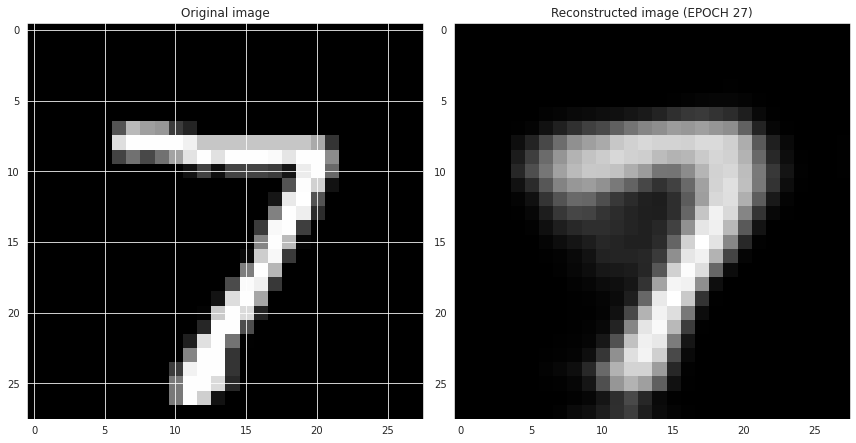

EPOCH 28/100
	 partial train loss (single batch): 0.044673
	 partial train loss (single batch): 0.042747
	 partial train loss (single batch): 0.043437
	 partial train loss (single batch): 0.044513
	 partial train loss (single batch): 0.042079
	 partial train loss (single batch): 0.043537
	 partial train loss (single batch): 0.042820
	 partial train loss (single batch): 0.040695
	 partial train loss (single batch): 0.041989
	 partial train loss (single batch): 0.042778
	 partial train loss (single batch): 0.040916
	 partial train loss (single batch): 0.044023
	 partial train loss (single batch): 0.041296
	 partial train loss (single batch): 0.043598
	 partial train loss (single batch): 0.042738
	 partial train loss (single batch): 0.042287
	 partial train loss (single batch): 0.042318
	 partial train loss (single batch): 0.043148
	 partial train loss (single batch): 0.043020
	 partial train loss (single batch): 0.042640
	 partial train loss (single batch): 0.040148
	 partial train loss 

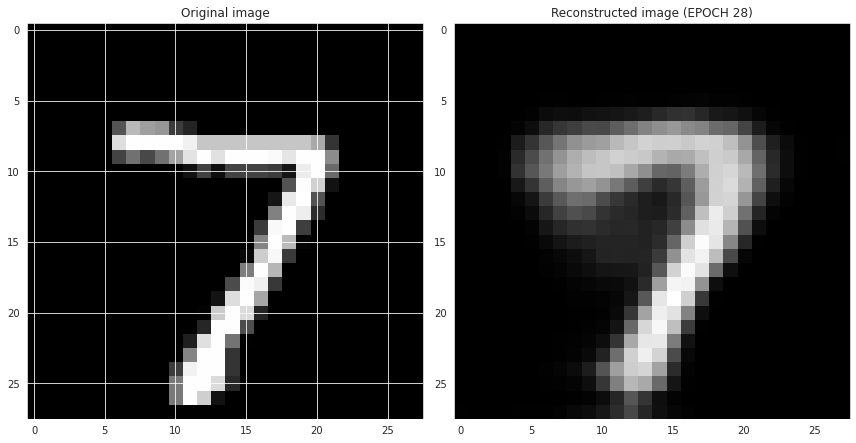

EPOCH 29/100
	 partial train loss (single batch): 0.042085
	 partial train loss (single batch): 0.043712
	 partial train loss (single batch): 0.043463
	 partial train loss (single batch): 0.042030
	 partial train loss (single batch): 0.042338
	 partial train loss (single batch): 0.041033
	 partial train loss (single batch): 0.043505
	 partial train loss (single batch): 0.044312
	 partial train loss (single batch): 0.042264
	 partial train loss (single batch): 0.043880
	 partial train loss (single batch): 0.041928
	 partial train loss (single batch): 0.042813
	 partial train loss (single batch): 0.042443
	 partial train loss (single batch): 0.042481
	 partial train loss (single batch): 0.042746
	 partial train loss (single batch): 0.042609
	 partial train loss (single batch): 0.042322
	 partial train loss (single batch): 0.043761
	 partial train loss (single batch): 0.043103
	 partial train loss (single batch): 0.044018
	 partial train loss (single batch): 0.042886
	 partial train loss 

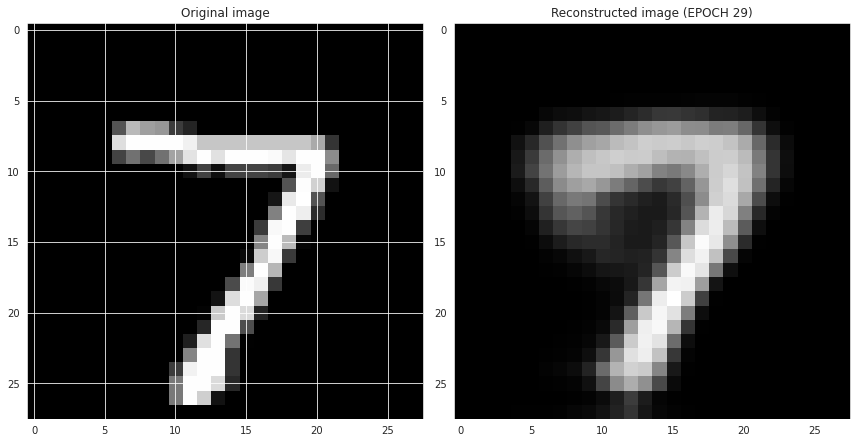

EPOCH 30/100
	 partial train loss (single batch): 0.042279
	 partial train loss (single batch): 0.043686
	 partial train loss (single batch): 0.042742
	 partial train loss (single batch): 0.042059
	 partial train loss (single batch): 0.045238
	 partial train loss (single batch): 0.039511
	 partial train loss (single batch): 0.044060
	 partial train loss (single batch): 0.043909
	 partial train loss (single batch): 0.044834
	 partial train loss (single batch): 0.042202
	 partial train loss (single batch): 0.042321
	 partial train loss (single batch): 0.042380
	 partial train loss (single batch): 0.043840
	 partial train loss (single batch): 0.042441
	 partial train loss (single batch): 0.042700
	 partial train loss (single batch): 0.043966
	 partial train loss (single batch): 0.041985
	 partial train loss (single batch): 0.042632
	 partial train loss (single batch): 0.041909
	 partial train loss (single batch): 0.042854
	 partial train loss (single batch): 0.043289
	 partial train loss 

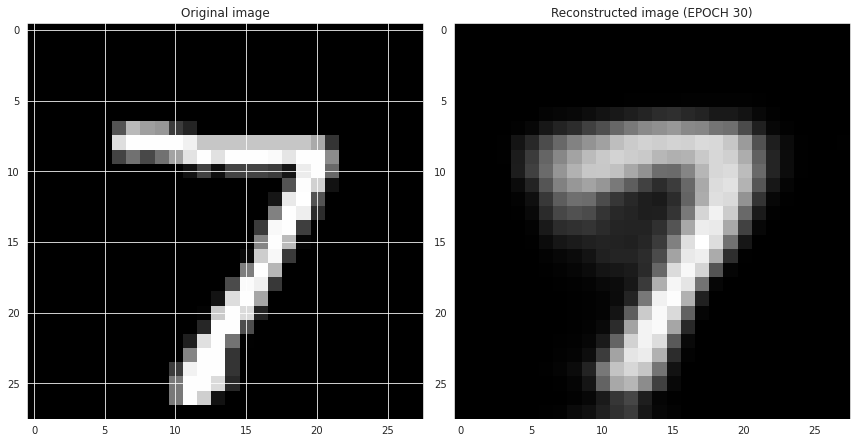

EPOCH 31/100
	 partial train loss (single batch): 0.042436
	 partial train loss (single batch): 0.044103
	 partial train loss (single batch): 0.044043
	 partial train loss (single batch): 0.041733
	 partial train loss (single batch): 0.044288
	 partial train loss (single batch): 0.042515
	 partial train loss (single batch): 0.044481
	 partial train loss (single batch): 0.042444
	 partial train loss (single batch): 0.043433
	 partial train loss (single batch): 0.045003
	 partial train loss (single batch): 0.040588
	 partial train loss (single batch): 0.043394
	 partial train loss (single batch): 0.044383
	 partial train loss (single batch): 0.041776
	 partial train loss (single batch): 0.044125
	 partial train loss (single batch): 0.043665
	 partial train loss (single batch): 0.042942
	 partial train loss (single batch): 0.042335
	 partial train loss (single batch): 0.042389
	 partial train loss (single batch): 0.042242
	 partial train loss (single batch): 0.041970
	 partial train loss 

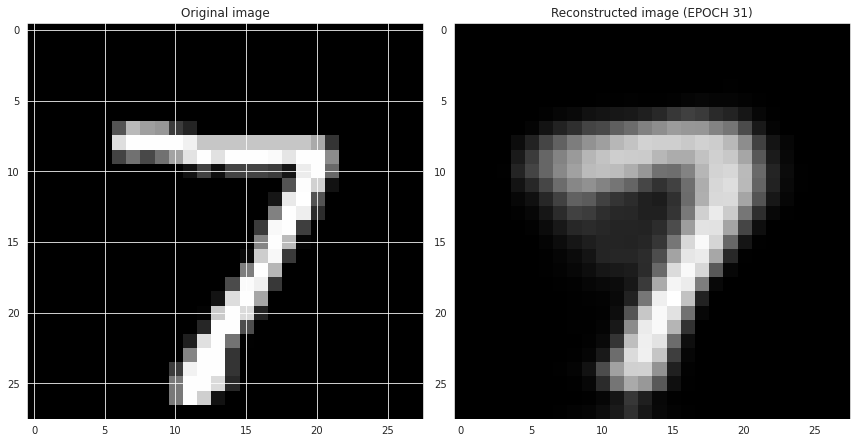

EPOCH 32/100
	 partial train loss (single batch): 0.041668
	 partial train loss (single batch): 0.042791
	 partial train loss (single batch): 0.043317
	 partial train loss (single batch): 0.043679
	 partial train loss (single batch): 0.044727
	 partial train loss (single batch): 0.042978
	 partial train loss (single batch): 0.041838
	 partial train loss (single batch): 0.042580
	 partial train loss (single batch): 0.041700
	 partial train loss (single batch): 0.041259
	 partial train loss (single batch): 0.042642
	 partial train loss (single batch): 0.043399
	 partial train loss (single batch): 0.043078
	 partial train loss (single batch): 0.043207
	 partial train loss (single batch): 0.043045
	 partial train loss (single batch): 0.041744
	 partial train loss (single batch): 0.042072
	 partial train loss (single batch): 0.043658
	 partial train loss (single batch): 0.040740
	 partial train loss (single batch): 0.042577
	 partial train loss (single batch): 0.041868
	 partial train loss 

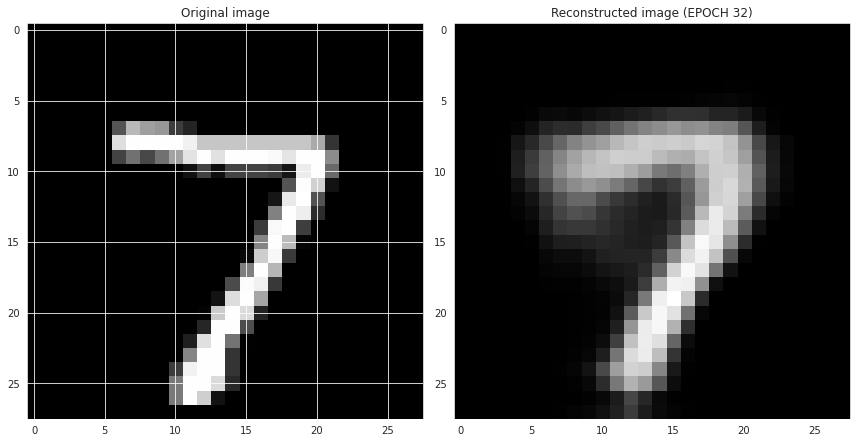

EPOCH 33/100
	 partial train loss (single batch): 0.042800
	 partial train loss (single batch): 0.042797
	 partial train loss (single batch): 0.040503
	 partial train loss (single batch): 0.042658
	 partial train loss (single batch): 0.042454
	 partial train loss (single batch): 0.043160
	 partial train loss (single batch): 0.041456
	 partial train loss (single batch): 0.042681
	 partial train loss (single batch): 0.043510
	 partial train loss (single batch): 0.044089
	 partial train loss (single batch): 0.043755
	 partial train loss (single batch): 0.043787
	 partial train loss (single batch): 0.044868
	 partial train loss (single batch): 0.045010
	 partial train loss (single batch): 0.042025
	 partial train loss (single batch): 0.041974
	 partial train loss (single batch): 0.041405
	 partial train loss (single batch): 0.040675
	 partial train loss (single batch): 0.042832
	 partial train loss (single batch): 0.042186
	 partial train loss (single batch): 0.041005
	 partial train loss 

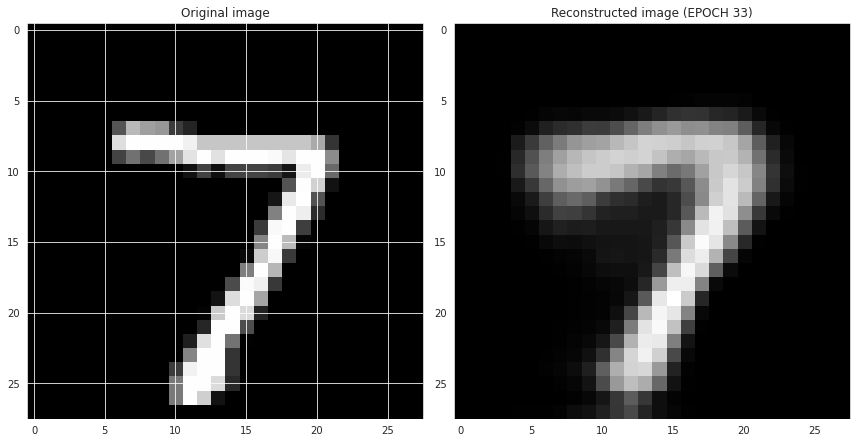

EPOCH 34/100
	 partial train loss (single batch): 0.044538
	 partial train loss (single batch): 0.041439
	 partial train loss (single batch): 0.041569
	 partial train loss (single batch): 0.041891
	 partial train loss (single batch): 0.041664
	 partial train loss (single batch): 0.040838
	 partial train loss (single batch): 0.041663
	 partial train loss (single batch): 0.042357
	 partial train loss (single batch): 0.044720
	 partial train loss (single batch): 0.042494
	 partial train loss (single batch): 0.043063
	 partial train loss (single batch): 0.041285
	 partial train loss (single batch): 0.042207
	 partial train loss (single batch): 0.043610
	 partial train loss (single batch): 0.040987
	 partial train loss (single batch): 0.044260
	 partial train loss (single batch): 0.042096
	 partial train loss (single batch): 0.041411
	 partial train loss (single batch): 0.042207
	 partial train loss (single batch): 0.041671
	 partial train loss (single batch): 0.041789
	 partial train loss 

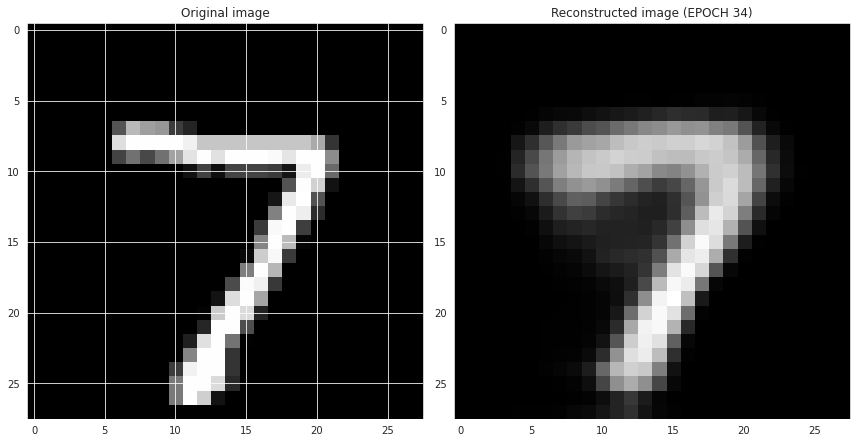

EPOCH 35/100
	 partial train loss (single batch): 0.042867
	 partial train loss (single batch): 0.042345
	 partial train loss (single batch): 0.043270
	 partial train loss (single batch): 0.042468
	 partial train loss (single batch): 0.043623
	 partial train loss (single batch): 0.043898
	 partial train loss (single batch): 0.043807
	 partial train loss (single batch): 0.043670
	 partial train loss (single batch): 0.042965
	 partial train loss (single batch): 0.045617
	 partial train loss (single batch): 0.044594
	 partial train loss (single batch): 0.042351
	 partial train loss (single batch): 0.043749
	 partial train loss (single batch): 0.044548
	 partial train loss (single batch): 0.043077
	 partial train loss (single batch): 0.042071
	 partial train loss (single batch): 0.042619
	 partial train loss (single batch): 0.041128
	 partial train loss (single batch): 0.043649
	 partial train loss (single batch): 0.042483
	 partial train loss (single batch): 0.043204
	 partial train loss 

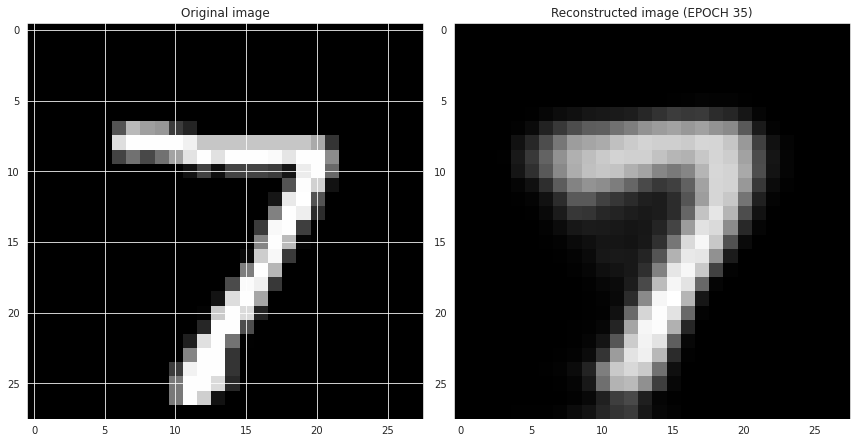

EPOCH 36/100
	 partial train loss (single batch): 0.043730
	 partial train loss (single batch): 0.042922
	 partial train loss (single batch): 0.042251
	 partial train loss (single batch): 0.043163
	 partial train loss (single batch): 0.042042
	 partial train loss (single batch): 0.045666
	 partial train loss (single batch): 0.043402
	 partial train loss (single batch): 0.045244
	 partial train loss (single batch): 0.042668
	 partial train loss (single batch): 0.043885
	 partial train loss (single batch): 0.041485
	 partial train loss (single batch): 0.042258
	 partial train loss (single batch): 0.044356
	 partial train loss (single batch): 0.043418
	 partial train loss (single batch): 0.042086
	 partial train loss (single batch): 0.042859
	 partial train loss (single batch): 0.042088
	 partial train loss (single batch): 0.040920
	 partial train loss (single batch): 0.042797
	 partial train loss (single batch): 0.042689
	 partial train loss (single batch): 0.042484
	 partial train loss 

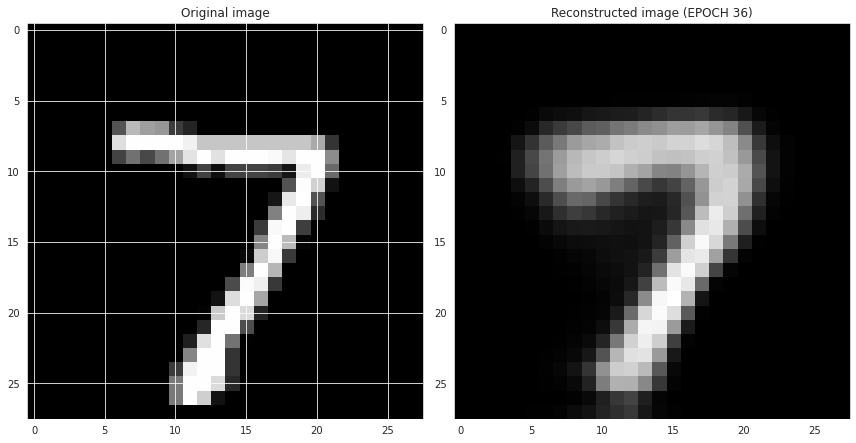

EPOCH 37/100
	 partial train loss (single batch): 0.042704
	 partial train loss (single batch): 0.044573
	 partial train loss (single batch): 0.040432
	 partial train loss (single batch): 0.041893
	 partial train loss (single batch): 0.042744
	 partial train loss (single batch): 0.043350
	 partial train loss (single batch): 0.042591
	 partial train loss (single batch): 0.042121
	 partial train loss (single batch): 0.043180
	 partial train loss (single batch): 0.042278
	 partial train loss (single batch): 0.042924
	 partial train loss (single batch): 0.045198
	 partial train loss (single batch): 0.041593
	 partial train loss (single batch): 0.044483
	 partial train loss (single batch): 0.043387
	 partial train loss (single batch): 0.041599
	 partial train loss (single batch): 0.043934
	 partial train loss (single batch): 0.040903
	 partial train loss (single batch): 0.040919
	 partial train loss (single batch): 0.043410
	 partial train loss (single batch): 0.043451
	 partial train loss 

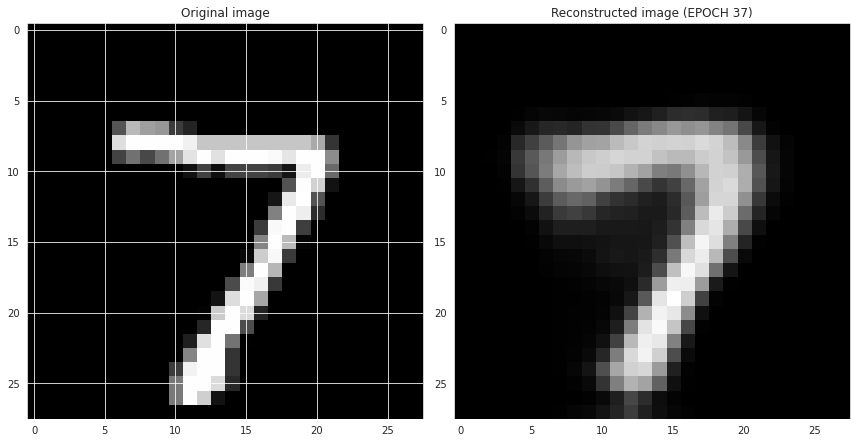

EPOCH 38/100
	 partial train loss (single batch): 0.041870
	 partial train loss (single batch): 0.044319
	 partial train loss (single batch): 0.041820
	 partial train loss (single batch): 0.042816
	 partial train loss (single batch): 0.042363
	 partial train loss (single batch): 0.044074
	 partial train loss (single batch): 0.042945
	 partial train loss (single batch): 0.043923
	 partial train loss (single batch): 0.041618
	 partial train loss (single batch): 0.042278
	 partial train loss (single batch): 0.042283
	 partial train loss (single batch): 0.041481
	 partial train loss (single batch): 0.042614
	 partial train loss (single batch): 0.043211
	 partial train loss (single batch): 0.042632
	 partial train loss (single batch): 0.044201
	 partial train loss (single batch): 0.041307
	 partial train loss (single batch): 0.042725
	 partial train loss (single batch): 0.042565
	 partial train loss (single batch): 0.042091
	 partial train loss (single batch): 0.042704
	 partial train loss 

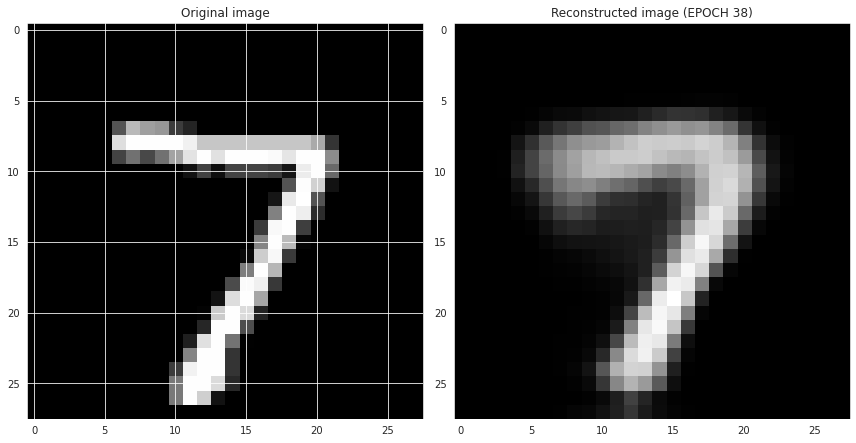

EPOCH 39/100
	 partial train loss (single batch): 0.042160
	 partial train loss (single batch): 0.040675
	 partial train loss (single batch): 0.042254
	 partial train loss (single batch): 0.042684
	 partial train loss (single batch): 0.045057
	 partial train loss (single batch): 0.042994
	 partial train loss (single batch): 0.042091
	 partial train loss (single batch): 0.042012
	 partial train loss (single batch): 0.041549
	 partial train loss (single batch): 0.042018
	 partial train loss (single batch): 0.041284
	 partial train loss (single batch): 0.043796
	 partial train loss (single batch): 0.043709
	 partial train loss (single batch): 0.041536
	 partial train loss (single batch): 0.043020
	 partial train loss (single batch): 0.041561
	 partial train loss (single batch): 0.040657
	 partial train loss (single batch): 0.043677
	 partial train loss (single batch): 0.044202
	 partial train loss (single batch): 0.041393
	 partial train loss (single batch): 0.044271
	 partial train loss 

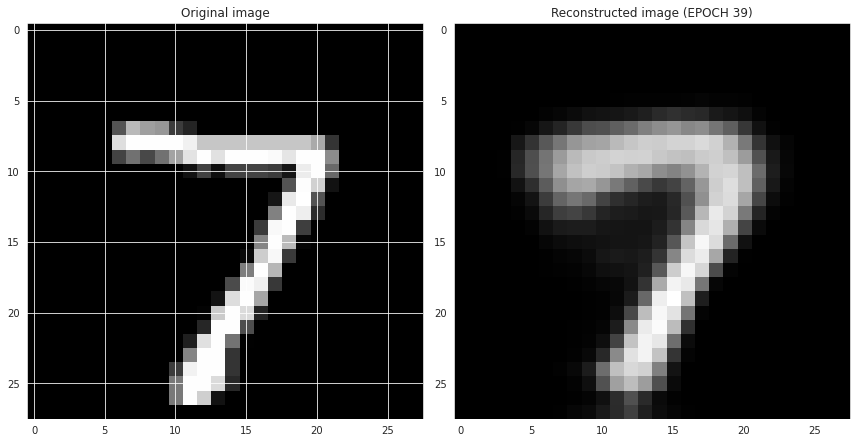

EPOCH 40/100
	 partial train loss (single batch): 0.042078
	 partial train loss (single batch): 0.042960
	 partial train loss (single batch): 0.041857
	 partial train loss (single batch): 0.041622
	 partial train loss (single batch): 0.041804
	 partial train loss (single batch): 0.042792
	 partial train loss (single batch): 0.041150
	 partial train loss (single batch): 0.042010
	 partial train loss (single batch): 0.041921
	 partial train loss (single batch): 0.041113
	 partial train loss (single batch): 0.041981
	 partial train loss (single batch): 0.042775
	 partial train loss (single batch): 0.041736
	 partial train loss (single batch): 0.041973
	 partial train loss (single batch): 0.042861
	 partial train loss (single batch): 0.044100
	 partial train loss (single batch): 0.040957
	 partial train loss (single batch): 0.043340
	 partial train loss (single batch): 0.043819
	 partial train loss (single batch): 0.040492
	 partial train loss (single batch): 0.040403
	 partial train loss 

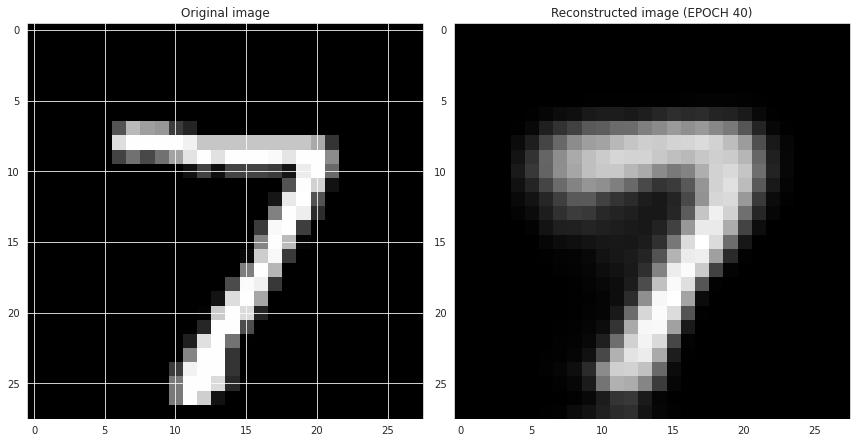

EPOCH 41/100
	 partial train loss (single batch): 0.042245
	 partial train loss (single batch): 0.042929
	 partial train loss (single batch): 0.043357
	 partial train loss (single batch): 0.044233
	 partial train loss (single batch): 0.043165
	 partial train loss (single batch): 0.040334
	 partial train loss (single batch): 0.040888
	 partial train loss (single batch): 0.042520
	 partial train loss (single batch): 0.042272
	 partial train loss (single batch): 0.041311
	 partial train loss (single batch): 0.043698
	 partial train loss (single batch): 0.042852
	 partial train loss (single batch): 0.043274
	 partial train loss (single batch): 0.043335
	 partial train loss (single batch): 0.041858
	 partial train loss (single batch): 0.044094
	 partial train loss (single batch): 0.043924
	 partial train loss (single batch): 0.042074
	 partial train loss (single batch): 0.041761
	 partial train loss (single batch): 0.041809
	 partial train loss (single batch): 0.040204
	 partial train loss 

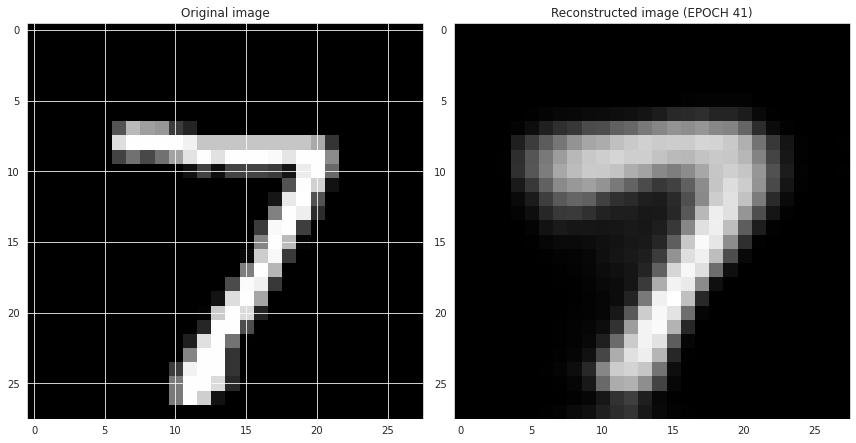

EPOCH 42/100
	 partial train loss (single batch): 0.041230
	 partial train loss (single batch): 0.043594
	 partial train loss (single batch): 0.042651
	 partial train loss (single batch): 0.041039
	 partial train loss (single batch): 0.041338
	 partial train loss (single batch): 0.041156
	 partial train loss (single batch): 0.041797
	 partial train loss (single batch): 0.043830
	 partial train loss (single batch): 0.044604
	 partial train loss (single batch): 0.041934
	 partial train loss (single batch): 0.042498
	 partial train loss (single batch): 0.042699
	 partial train loss (single batch): 0.041323
	 partial train loss (single batch): 0.041827
	 partial train loss (single batch): 0.043581
	 partial train loss (single batch): 0.044185
	 partial train loss (single batch): 0.042288
	 partial train loss (single batch): 0.043923
	 partial train loss (single batch): 0.041652
	 partial train loss (single batch): 0.039927
	 partial train loss (single batch): 0.042658
	 partial train loss 

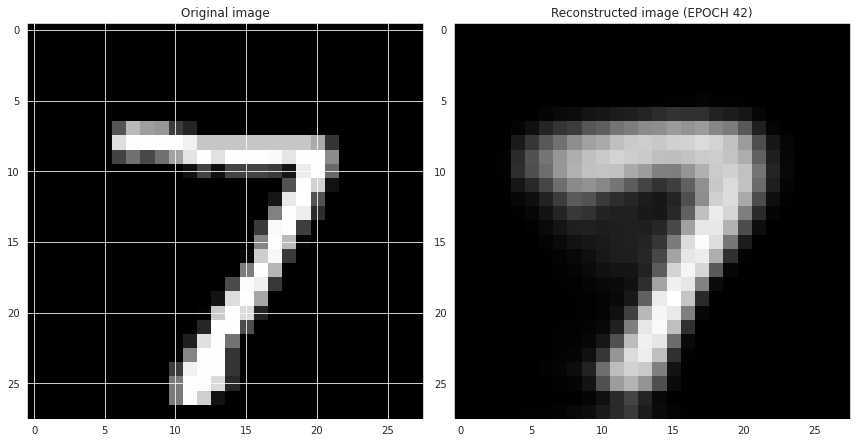

EPOCH 43/100
	 partial train loss (single batch): 0.043068
	 partial train loss (single batch): 0.043954
	 partial train loss (single batch): 0.043141
	 partial train loss (single batch): 0.042696
	 partial train loss (single batch): 0.042827
	 partial train loss (single batch): 0.040793
	 partial train loss (single batch): 0.042767
	 partial train loss (single batch): 0.042992
	 partial train loss (single batch): 0.042446
	 partial train loss (single batch): 0.041594
	 partial train loss (single batch): 0.042728
	 partial train loss (single batch): 0.042576
	 partial train loss (single batch): 0.042810
	 partial train loss (single batch): 0.042298
	 partial train loss (single batch): 0.043880
	 partial train loss (single batch): 0.042433
	 partial train loss (single batch): 0.041723
	 partial train loss (single batch): 0.043170
	 partial train loss (single batch): 0.041794
	 partial train loss (single batch): 0.043997
	 partial train loss (single batch): 0.041331
	 partial train loss 

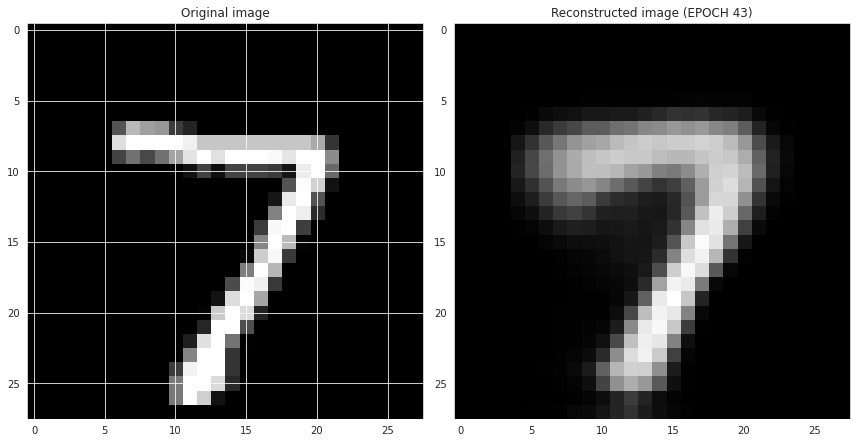

EPOCH 44/100
	 partial train loss (single batch): 0.043037
	 partial train loss (single batch): 0.042883
	 partial train loss (single batch): 0.039893
	 partial train loss (single batch): 0.043061
	 partial train loss (single batch): 0.042978
	 partial train loss (single batch): 0.040316
	 partial train loss (single batch): 0.042972
	 partial train loss (single batch): 0.042685
	 partial train loss (single batch): 0.040912
	 partial train loss (single batch): 0.040849
	 partial train loss (single batch): 0.042462
	 partial train loss (single batch): 0.040267
	 partial train loss (single batch): 0.041984
	 partial train loss (single batch): 0.044678
	 partial train loss (single batch): 0.042057
	 partial train loss (single batch): 0.041045
	 partial train loss (single batch): 0.042432
	 partial train loss (single batch): 0.042347
	 partial train loss (single batch): 0.040165
	 partial train loss (single batch): 0.040744
	 partial train loss (single batch): 0.042015
	 partial train loss 

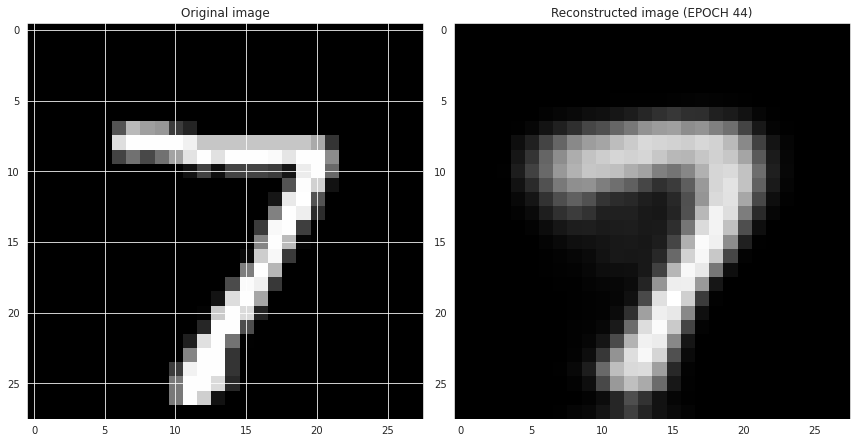

EPOCH 45/100
	 partial train loss (single batch): 0.040835
	 partial train loss (single batch): 0.043624
	 partial train loss (single batch): 0.042409
	 partial train loss (single batch): 0.042784
	 partial train loss (single batch): 0.042226
	 partial train loss (single batch): 0.040529
	 partial train loss (single batch): 0.042927
	 partial train loss (single batch): 0.040997
	 partial train loss (single batch): 0.044266
	 partial train loss (single batch): 0.039769
	 partial train loss (single batch): 0.040803
	 partial train loss (single batch): 0.041274
	 partial train loss (single batch): 0.042016
	 partial train loss (single batch): 0.043733
	 partial train loss (single batch): 0.040470
	 partial train loss (single batch): 0.041028
	 partial train loss (single batch): 0.045915
	 partial train loss (single batch): 0.041354
	 partial train loss (single batch): 0.041433
	 partial train loss (single batch): 0.042420
	 partial train loss (single batch): 0.040639
	 partial train loss 

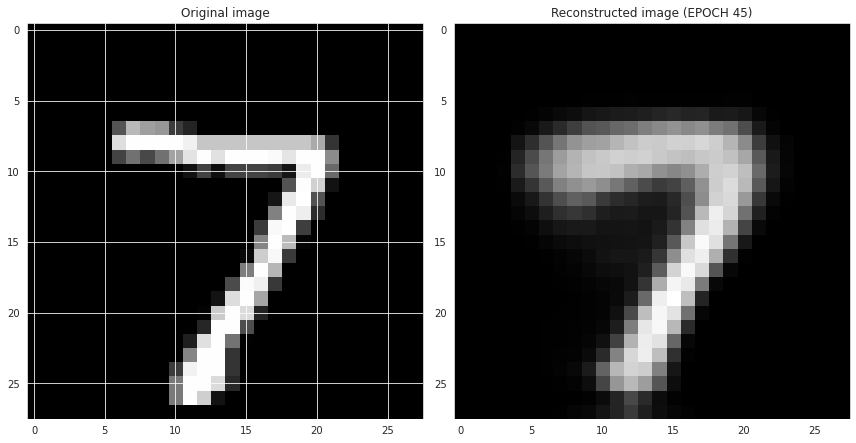

EPOCH 46/100
	 partial train loss (single batch): 0.043187
	 partial train loss (single batch): 0.042139
	 partial train loss (single batch): 0.042789
	 partial train loss (single batch): 0.041694
	 partial train loss (single batch): 0.043730
	 partial train loss (single batch): 0.040868
	 partial train loss (single batch): 0.042591
	 partial train loss (single batch): 0.041036
	 partial train loss (single batch): 0.041978
	 partial train loss (single batch): 0.041209
	 partial train loss (single batch): 0.040802
	 partial train loss (single batch): 0.041955
	 partial train loss (single batch): 0.041158
	 partial train loss (single batch): 0.046099
	 partial train loss (single batch): 0.040965
	 partial train loss (single batch): 0.043288
	 partial train loss (single batch): 0.041021
	 partial train loss (single batch): 0.042089
	 partial train loss (single batch): 0.041703
	 partial train loss (single batch): 0.043281
	 partial train loss (single batch): 0.041834
	 partial train loss 

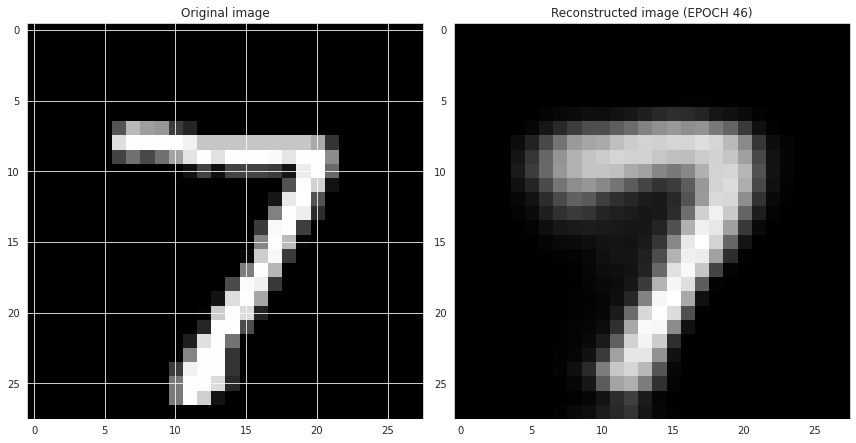

EPOCH 47/100
	 partial train loss (single batch): 0.041708
	 partial train loss (single batch): 0.040438
	 partial train loss (single batch): 0.042205
	 partial train loss (single batch): 0.042180
	 partial train loss (single batch): 0.039445
	 partial train loss (single batch): 0.044115
	 partial train loss (single batch): 0.041227
	 partial train loss (single batch): 0.043221
	 partial train loss (single batch): 0.042144
	 partial train loss (single batch): 0.042458
	 partial train loss (single batch): 0.043497
	 partial train loss (single batch): 0.044057
	 partial train loss (single batch): 0.042407
	 partial train loss (single batch): 0.042435
	 partial train loss (single batch): 0.042414
	 partial train loss (single batch): 0.041278
	 partial train loss (single batch): 0.042026
	 partial train loss (single batch): 0.042144
	 partial train loss (single batch): 0.041490
	 partial train loss (single batch): 0.040708
	 partial train loss (single batch): 0.041751
	 partial train loss 

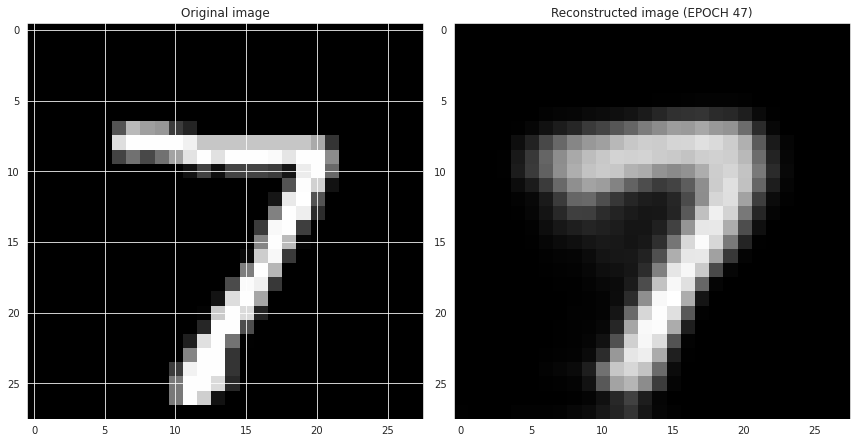

EPOCH 48/100
	 partial train loss (single batch): 0.041966
	 partial train loss (single batch): 0.043691
	 partial train loss (single batch): 0.041207
	 partial train loss (single batch): 0.043850
	 partial train loss (single batch): 0.040154
	 partial train loss (single batch): 0.041466
	 partial train loss (single batch): 0.042033
	 partial train loss (single batch): 0.041389
	 partial train loss (single batch): 0.043422
	 partial train loss (single batch): 0.042655
	 partial train loss (single batch): 0.041636
	 partial train loss (single batch): 0.040925
	 partial train loss (single batch): 0.040878
	 partial train loss (single batch): 0.043113
	 partial train loss (single batch): 0.040560
	 partial train loss (single batch): 0.041917
	 partial train loss (single batch): 0.041532
	 partial train loss (single batch): 0.044097
	 partial train loss (single batch): 0.039541
	 partial train loss (single batch): 0.042946
	 partial train loss (single batch): 0.040771
	 partial train loss 

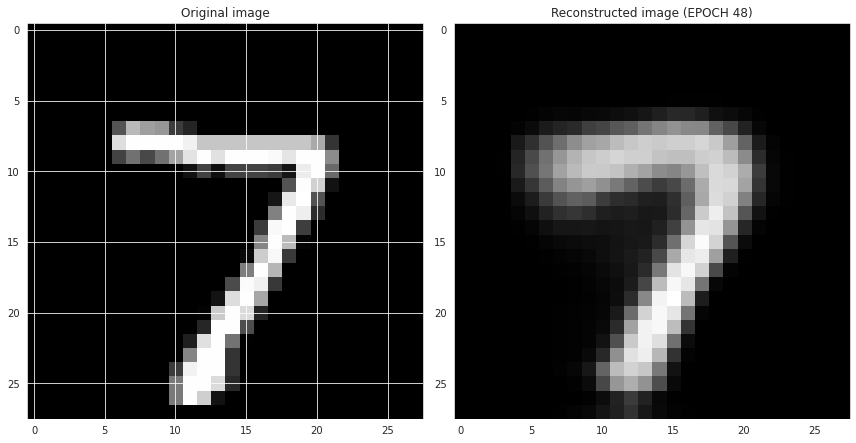

EPOCH 49/100
	 partial train loss (single batch): 0.043001
	 partial train loss (single batch): 0.042016
	 partial train loss (single batch): 0.040905
	 partial train loss (single batch): 0.042374
	 partial train loss (single batch): 0.040531
	 partial train loss (single batch): 0.043394
	 partial train loss (single batch): 0.041139
	 partial train loss (single batch): 0.041122
	 partial train loss (single batch): 0.042784
	 partial train loss (single batch): 0.040934
	 partial train loss (single batch): 0.042617
	 partial train loss (single batch): 0.042904
	 partial train loss (single batch): 0.042458
	 partial train loss (single batch): 0.041819
	 partial train loss (single batch): 0.041571
	 partial train loss (single batch): 0.042848
	 partial train loss (single batch): 0.041308
	 partial train loss (single batch): 0.040272
	 partial train loss (single batch): 0.040486
	 partial train loss (single batch): 0.040402
	 partial train loss (single batch): 0.042696
	 partial train loss 

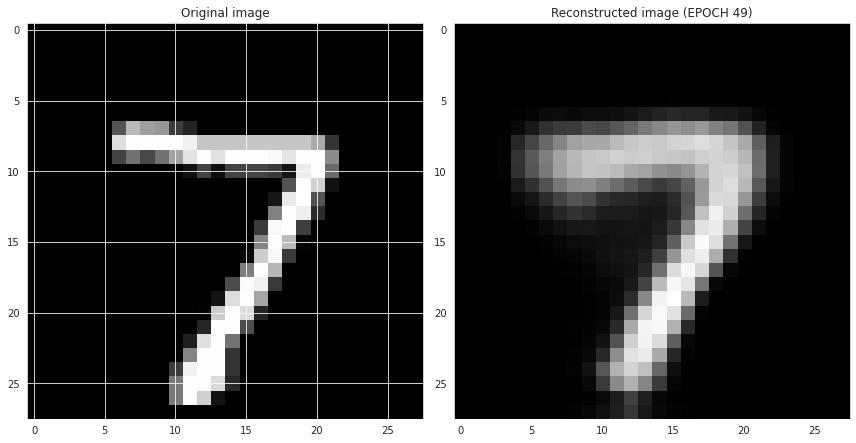

EPOCH 50/100
	 partial train loss (single batch): 0.043155
	 partial train loss (single batch): 0.040585
	 partial train loss (single batch): 0.042457
	 partial train loss (single batch): 0.042720
	 partial train loss (single batch): 0.040969
	 partial train loss (single batch): 0.042446
	 partial train loss (single batch): 0.042032
	 partial train loss (single batch): 0.042010
	 partial train loss (single batch): 0.042241
	 partial train loss (single batch): 0.041847
	 partial train loss (single batch): 0.044124
	 partial train loss (single batch): 0.042206
	 partial train loss (single batch): 0.040722
	 partial train loss (single batch): 0.042651
	 partial train loss (single batch): 0.042743
	 partial train loss (single batch): 0.043443
	 partial train loss (single batch): 0.041878
	 partial train loss (single batch): 0.041196
	 partial train loss (single batch): 0.041451
	 partial train loss (single batch): 0.039838
	 partial train loss (single batch): 0.041710
	 partial train loss 

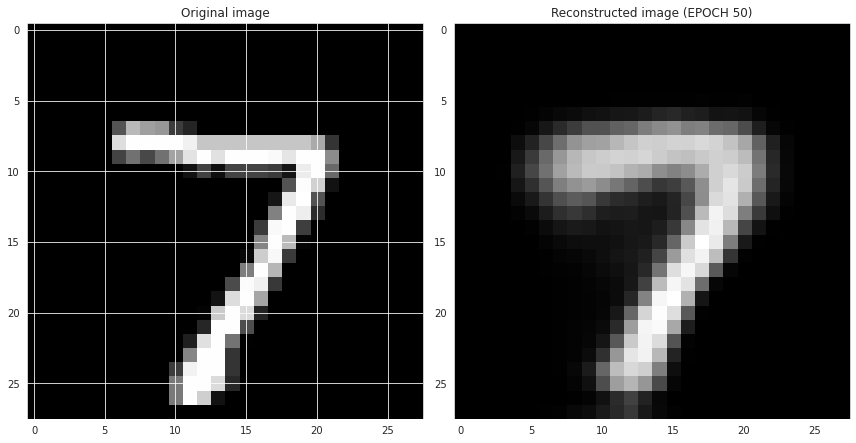

EPOCH 51/100
	 partial train loss (single batch): 0.041694
	 partial train loss (single batch): 0.041847
	 partial train loss (single batch): 0.041173
	 partial train loss (single batch): 0.041044
	 partial train loss (single batch): 0.044468
	 partial train loss (single batch): 0.040661
	 partial train loss (single batch): 0.040611
	 partial train loss (single batch): 0.041579
	 partial train loss (single batch): 0.043698
	 partial train loss (single batch): 0.043497
	 partial train loss (single batch): 0.043028
	 partial train loss (single batch): 0.040708
	 partial train loss (single batch): 0.042716
	 partial train loss (single batch): 0.043946
	 partial train loss (single batch): 0.042478
	 partial train loss (single batch): 0.041041
	 partial train loss (single batch): 0.041662
	 partial train loss (single batch): 0.042030
	 partial train loss (single batch): 0.041044
	 partial train loss (single batch): 0.042430
	 partial train loss (single batch): 0.041153
	 partial train loss 

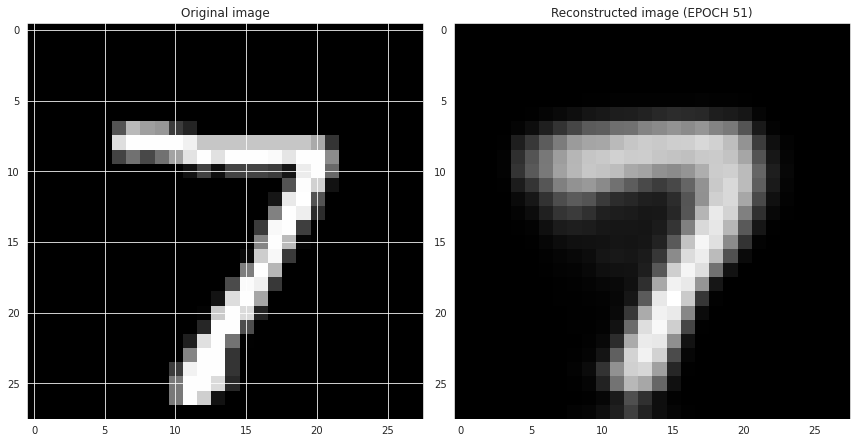

EPOCH 52/100
	 partial train loss (single batch): 0.044076
	 partial train loss (single batch): 0.043065
	 partial train loss (single batch): 0.042076
	 partial train loss (single batch): 0.039614
	 partial train loss (single batch): 0.041457
	 partial train loss (single batch): 0.042574
	 partial train loss (single batch): 0.043998
	 partial train loss (single batch): 0.043178
	 partial train loss (single batch): 0.042857
	 partial train loss (single batch): 0.040170
	 partial train loss (single batch): 0.041084
	 partial train loss (single batch): 0.040867
	 partial train loss (single batch): 0.040892
	 partial train loss (single batch): 0.043122
	 partial train loss (single batch): 0.042168
	 partial train loss (single batch): 0.042583
	 partial train loss (single batch): 0.043603
	 partial train loss (single batch): 0.041576
	 partial train loss (single batch): 0.045412
	 partial train loss (single batch): 0.042593
	 partial train loss (single batch): 0.043616
	 partial train loss 

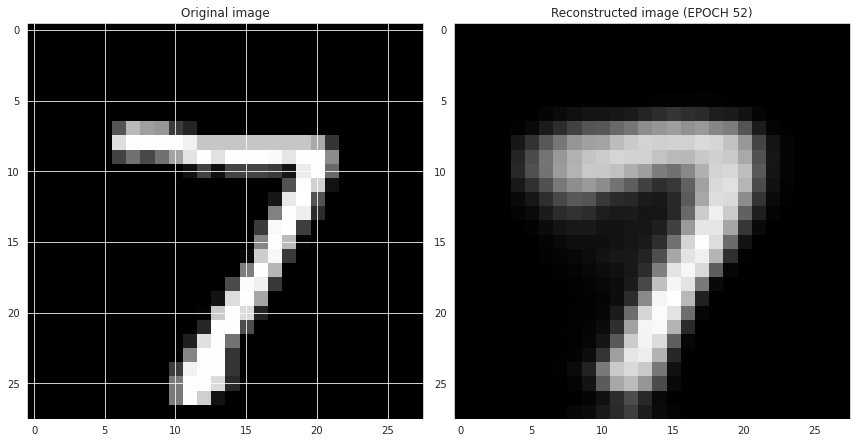

EPOCH 53/100
	 partial train loss (single batch): 0.042036
	 partial train loss (single batch): 0.042639
	 partial train loss (single batch): 0.042197
	 partial train loss (single batch): 0.044775
	 partial train loss (single batch): 0.041231
	 partial train loss (single batch): 0.041274
	 partial train loss (single batch): 0.041587
	 partial train loss (single batch): 0.041428
	 partial train loss (single batch): 0.039765
	 partial train loss (single batch): 0.042490
	 partial train loss (single batch): 0.042767
	 partial train loss (single batch): 0.041191
	 partial train loss (single batch): 0.042867
	 partial train loss (single batch): 0.042364
	 partial train loss (single batch): 0.042657
	 partial train loss (single batch): 0.042366
	 partial train loss (single batch): 0.041448
	 partial train loss (single batch): 0.042046
	 partial train loss (single batch): 0.042478
	 partial train loss (single batch): 0.043542
	 partial train loss (single batch): 0.040703
	 partial train loss 

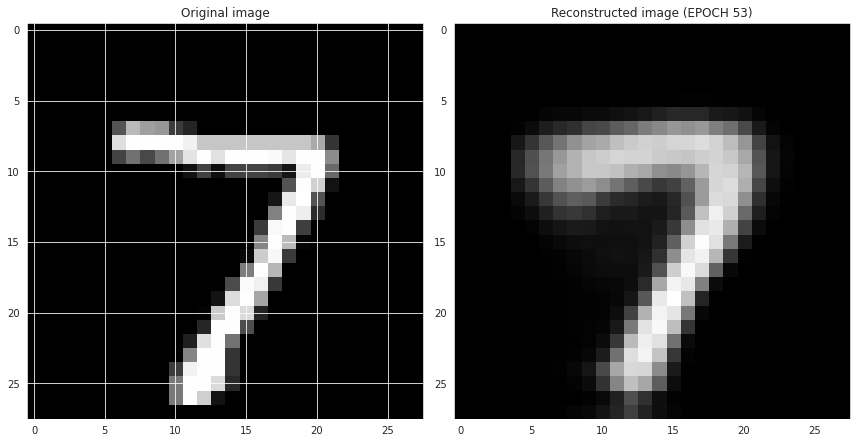

EPOCH 54/100
	 partial train loss (single batch): 0.042988
	 partial train loss (single batch): 0.041539
	 partial train loss (single batch): 0.043600
	 partial train loss (single batch): 0.042698
	 partial train loss (single batch): 0.041394
	 partial train loss (single batch): 0.042769
	 partial train loss (single batch): 0.039886
	 partial train loss (single batch): 0.043982
	 partial train loss (single batch): 0.042506
	 partial train loss (single batch): 0.042200
	 partial train loss (single batch): 0.040981
	 partial train loss (single batch): 0.043529
	 partial train loss (single batch): 0.040412
	 partial train loss (single batch): 0.041881
	 partial train loss (single batch): 0.042740
	 partial train loss (single batch): 0.041529
	 partial train loss (single batch): 0.043025
	 partial train loss (single batch): 0.043725
	 partial train loss (single batch): 0.041749
	 partial train loss (single batch): 0.041862
	 partial train loss (single batch): 0.043870
	 partial train loss 

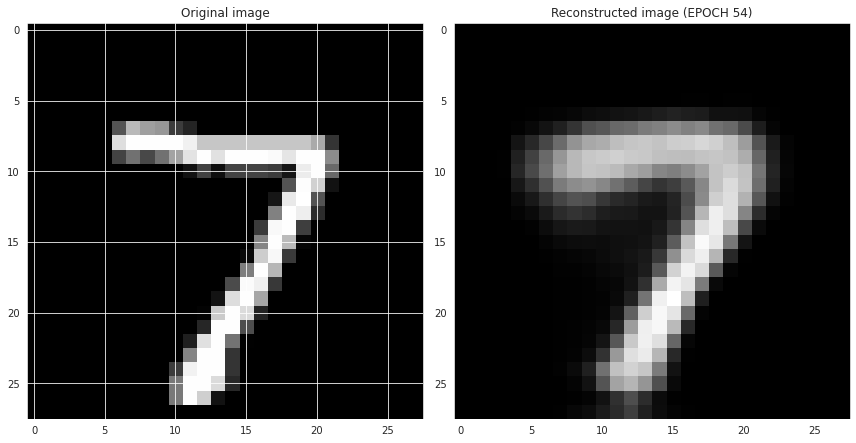

EPOCH 55/100
	 partial train loss (single batch): 0.040323
	 partial train loss (single batch): 0.041417
	 partial train loss (single batch): 0.042208
	 partial train loss (single batch): 0.044378
	 partial train loss (single batch): 0.040835
	 partial train loss (single batch): 0.042638
	 partial train loss (single batch): 0.040430
	 partial train loss (single batch): 0.042933
	 partial train loss (single batch): 0.040987
	 partial train loss (single batch): 0.042549
	 partial train loss (single batch): 0.042495
	 partial train loss (single batch): 0.042137
	 partial train loss (single batch): 0.042940
	 partial train loss (single batch): 0.043302
	 partial train loss (single batch): 0.043396
	 partial train loss (single batch): 0.044118
	 partial train loss (single batch): 0.042096
	 partial train loss (single batch): 0.042711
	 partial train loss (single batch): 0.041852
	 partial train loss (single batch): 0.041684
	 partial train loss (single batch): 0.043342
	 partial train loss 

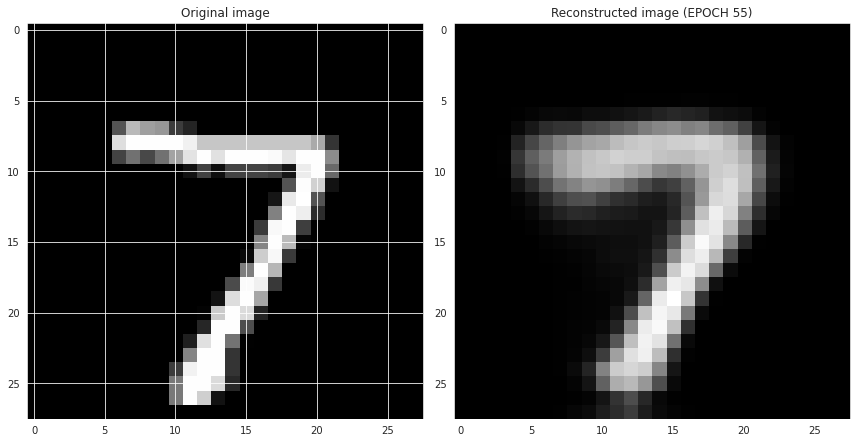

EPOCH 56/100
	 partial train loss (single batch): 0.042843
	 partial train loss (single batch): 0.043239
	 partial train loss (single batch): 0.041758
	 partial train loss (single batch): 0.041279
	 partial train loss (single batch): 0.045029
	 partial train loss (single batch): 0.041327
	 partial train loss (single batch): 0.041581
	 partial train loss (single batch): 0.043873
	 partial train loss (single batch): 0.041511
	 partial train loss (single batch): 0.042189
	 partial train loss (single batch): 0.043759
	 partial train loss (single batch): 0.041229
	 partial train loss (single batch): 0.042839
	 partial train loss (single batch): 0.042480
	 partial train loss (single batch): 0.043558
	 partial train loss (single batch): 0.043827
	 partial train loss (single batch): 0.042213
	 partial train loss (single batch): 0.041089
	 partial train loss (single batch): 0.042318
	 partial train loss (single batch): 0.044062
	 partial train loss (single batch): 0.040674
	 partial train loss 

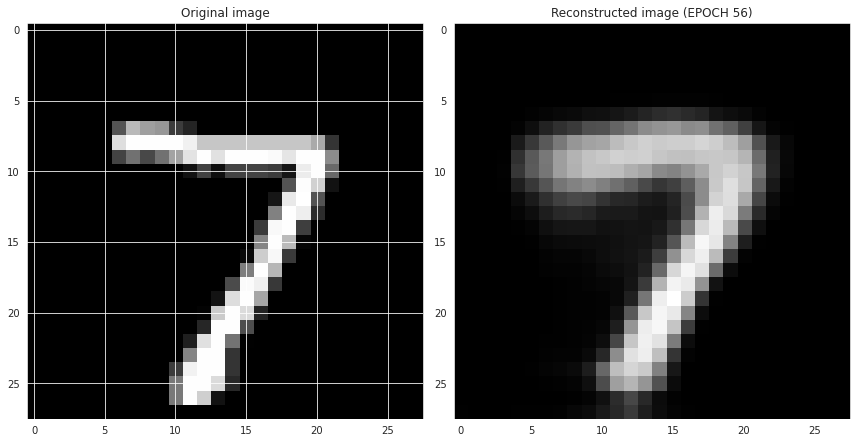

EPOCH 57/100
	 partial train loss (single batch): 0.042847
	 partial train loss (single batch): 0.041623
	 partial train loss (single batch): 0.042991
	 partial train loss (single batch): 0.042936
	 partial train loss (single batch): 0.042015
	 partial train loss (single batch): 0.041039
	 partial train loss (single batch): 0.041357
	 partial train loss (single batch): 0.042471
	 partial train loss (single batch): 0.041365
	 partial train loss (single batch): 0.042838
	 partial train loss (single batch): 0.040581
	 partial train loss (single batch): 0.040784
	 partial train loss (single batch): 0.042998
	 partial train loss (single batch): 0.041793
	 partial train loss (single batch): 0.041787
	 partial train loss (single batch): 0.042885
	 partial train loss (single batch): 0.043911
	 partial train loss (single batch): 0.042817
	 partial train loss (single batch): 0.044302
	 partial train loss (single batch): 0.041360
	 partial train loss (single batch): 0.041895
	 partial train loss 

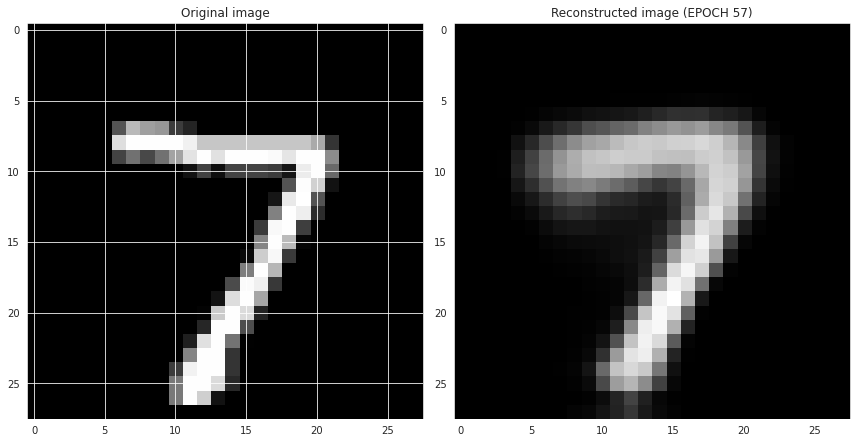

EPOCH 58/100
	 partial train loss (single batch): 0.043022
	 partial train loss (single batch): 0.043421
	 partial train loss (single batch): 0.041214
	 partial train loss (single batch): 0.040258
	 partial train loss (single batch): 0.043070
	 partial train loss (single batch): 0.042694
	 partial train loss (single batch): 0.041744
	 partial train loss (single batch): 0.040802
	 partial train loss (single batch): 0.040816
	 partial train loss (single batch): 0.040537
	 partial train loss (single batch): 0.040735
	 partial train loss (single batch): 0.042341
	 partial train loss (single batch): 0.041169
	 partial train loss (single batch): 0.042312
	 partial train loss (single batch): 0.042687
	 partial train loss (single batch): 0.040462
	 partial train loss (single batch): 0.044202
	 partial train loss (single batch): 0.042504
	 partial train loss (single batch): 0.041617
	 partial train loss (single batch): 0.040893
	 partial train loss (single batch): 0.042827
	 partial train loss 

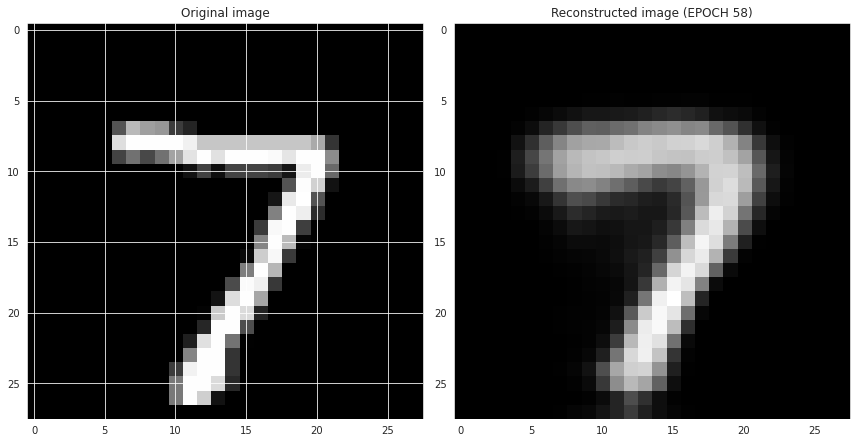

EPOCH 59/100
	 partial train loss (single batch): 0.041391
	 partial train loss (single batch): 0.041650
	 partial train loss (single batch): 0.041818
	 partial train loss (single batch): 0.041557
	 partial train loss (single batch): 0.042588
	 partial train loss (single batch): 0.043246
	 partial train loss (single batch): 0.041824
	 partial train loss (single batch): 0.040664
	 partial train loss (single batch): 0.042281
	 partial train loss (single batch): 0.042188
	 partial train loss (single batch): 0.040656
	 partial train loss (single batch): 0.043696
	 partial train loss (single batch): 0.042153
	 partial train loss (single batch): 0.043174
	 partial train loss (single batch): 0.043728
	 partial train loss (single batch): 0.041887
	 partial train loss (single batch): 0.041906
	 partial train loss (single batch): 0.042785
	 partial train loss (single batch): 0.043252
	 partial train loss (single batch): 0.042563
	 partial train loss (single batch): 0.043439
	 partial train loss 

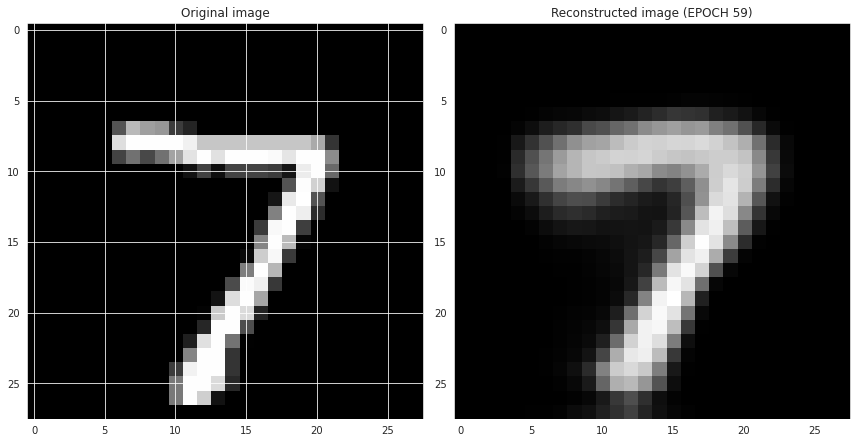

EPOCH 60/100
	 partial train loss (single batch): 0.042257
	 partial train loss (single batch): 0.043120
	 partial train loss (single batch): 0.044392
	 partial train loss (single batch): 0.041527
	 partial train loss (single batch): 0.041572
	 partial train loss (single batch): 0.043357
	 partial train loss (single batch): 0.041856
	 partial train loss (single batch): 0.043546
	 partial train loss (single batch): 0.041874
	 partial train loss (single batch): 0.043269
	 partial train loss (single batch): 0.043012
	 partial train loss (single batch): 0.043140
	 partial train loss (single batch): 0.043854
	 partial train loss (single batch): 0.040243
	 partial train loss (single batch): 0.042467
	 partial train loss (single batch): 0.042161
	 partial train loss (single batch): 0.040960
	 partial train loss (single batch): 0.040747
	 partial train loss (single batch): 0.042828
	 partial train loss (single batch): 0.042338
	 partial train loss (single batch): 0.041935
	 partial train loss 

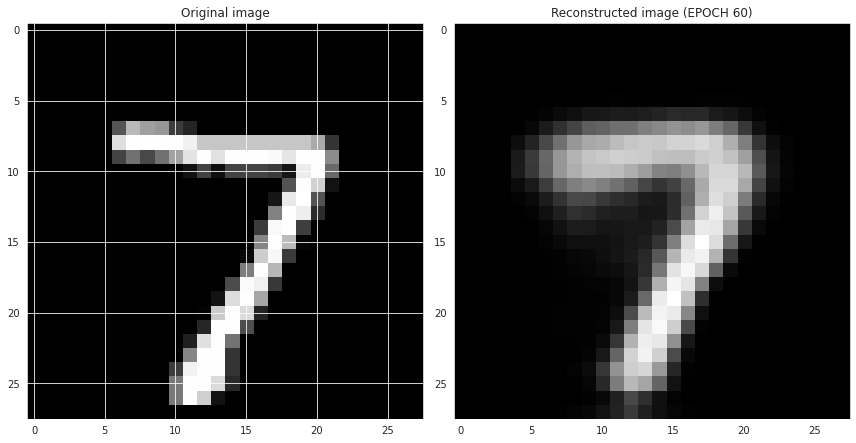

EPOCH 61/100
	 partial train loss (single batch): 0.041770
	 partial train loss (single batch): 0.042441
	 partial train loss (single batch): 0.042628
	 partial train loss (single batch): 0.043503
	 partial train loss (single batch): 0.040903
	 partial train loss (single batch): 0.041151
	 partial train loss (single batch): 0.041639
	 partial train loss (single batch): 0.041819
	 partial train loss (single batch): 0.041767
	 partial train loss (single batch): 0.041437
	 partial train loss (single batch): 0.042872
	 partial train loss (single batch): 0.041572
	 partial train loss (single batch): 0.042484
	 partial train loss (single batch): 0.040291
	 partial train loss (single batch): 0.041575
	 partial train loss (single batch): 0.043626
	 partial train loss (single batch): 0.041172
	 partial train loss (single batch): 0.042520
	 partial train loss (single batch): 0.043121
	 partial train loss (single batch): 0.041216
	 partial train loss (single batch): 0.042089
	 partial train loss 

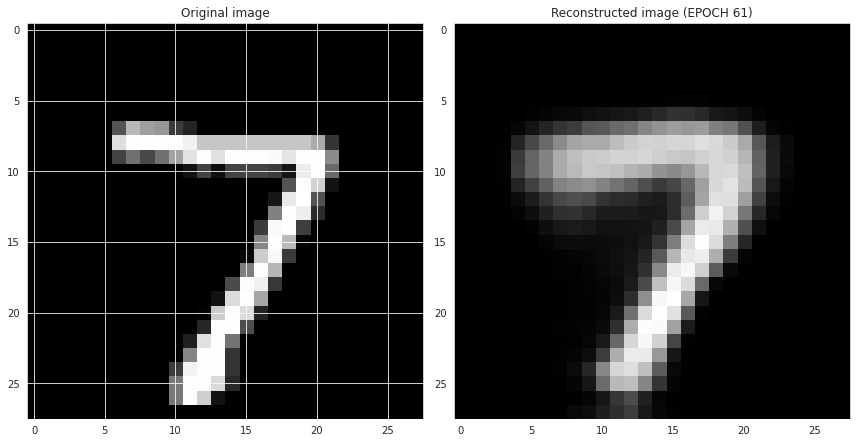

EPOCH 62/100
	 partial train loss (single batch): 0.040163
	 partial train loss (single batch): 0.041579
	 partial train loss (single batch): 0.043799
	 partial train loss (single batch): 0.041290
	 partial train loss (single batch): 0.041678
	 partial train loss (single batch): 0.041102
	 partial train loss (single batch): 0.041828
	 partial train loss (single batch): 0.042746
	 partial train loss (single batch): 0.043006
	 partial train loss (single batch): 0.044231
	 partial train loss (single batch): 0.042768
	 partial train loss (single batch): 0.042175
	 partial train loss (single batch): 0.040427
	 partial train loss (single batch): 0.040007
	 partial train loss (single batch): 0.042761
	 partial train loss (single batch): 0.043870
	 partial train loss (single batch): 0.042639
	 partial train loss (single batch): 0.042350
	 partial train loss (single batch): 0.042296
	 partial train loss (single batch): 0.041586
	 partial train loss (single batch): 0.044202
	 partial train loss 

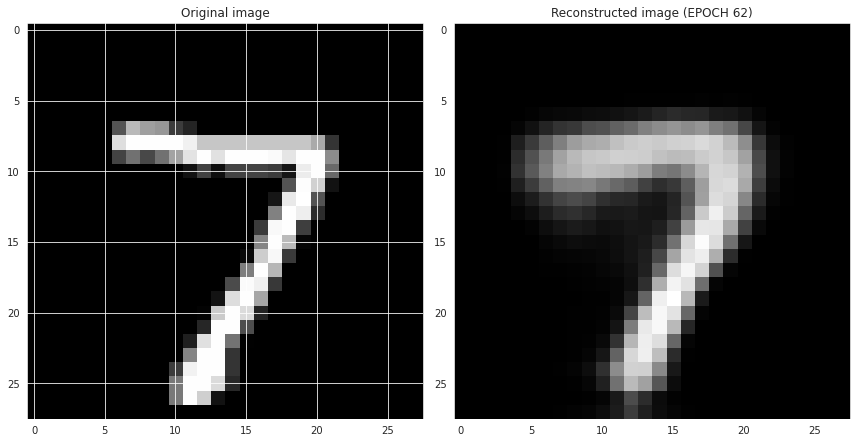

EPOCH 63/100
	 partial train loss (single batch): 0.042730
	 partial train loss (single batch): 0.042879
	 partial train loss (single batch): 0.042177
	 partial train loss (single batch): 0.040177
	 partial train loss (single batch): 0.040480
	 partial train loss (single batch): 0.041091
	 partial train loss (single batch): 0.041695
	 partial train loss (single batch): 0.042305
	 partial train loss (single batch): 0.042647
	 partial train loss (single batch): 0.039881
	 partial train loss (single batch): 0.039767
	 partial train loss (single batch): 0.043607
	 partial train loss (single batch): 0.040910
	 partial train loss (single batch): 0.042404
	 partial train loss (single batch): 0.041625
	 partial train loss (single batch): 0.042626
	 partial train loss (single batch): 0.042745
	 partial train loss (single batch): 0.042388
	 partial train loss (single batch): 0.041635
	 partial train loss (single batch): 0.041718
	 partial train loss (single batch): 0.040882
	 partial train loss 

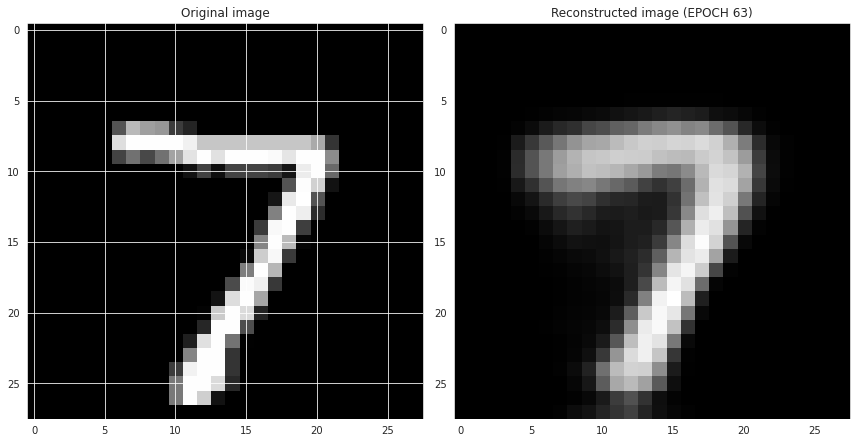

EPOCH 64/100
	 partial train loss (single batch): 0.041461
	 partial train loss (single batch): 0.042044
	 partial train loss (single batch): 0.041098
	 partial train loss (single batch): 0.041615
	 partial train loss (single batch): 0.042113
	 partial train loss (single batch): 0.041647
	 partial train loss (single batch): 0.041988
	 partial train loss (single batch): 0.043075
	 partial train loss (single batch): 0.042466
	 partial train loss (single batch): 0.041472
	 partial train loss (single batch): 0.039967
	 partial train loss (single batch): 0.040477
	 partial train loss (single batch): 0.042513
	 partial train loss (single batch): 0.042300
	 partial train loss (single batch): 0.043636
	 partial train loss (single batch): 0.041560
	 partial train loss (single batch): 0.041886
	 partial train loss (single batch): 0.042783
	 partial train loss (single batch): 0.042697
	 partial train loss (single batch): 0.041681
	 partial train loss (single batch): 0.041104
	 partial train loss 

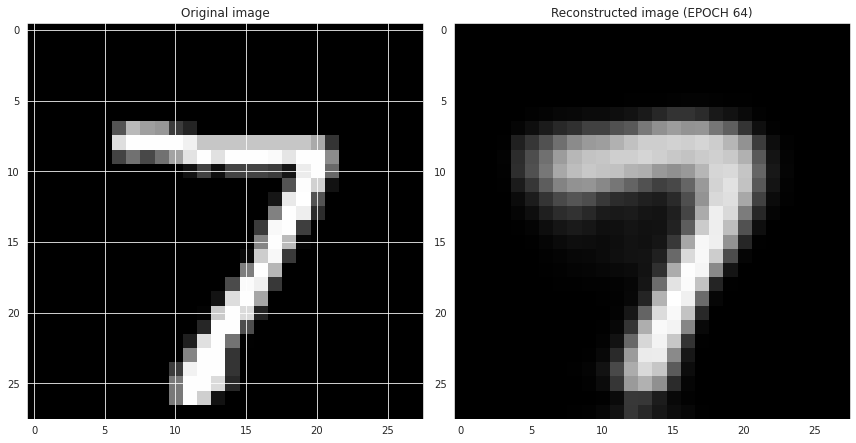

EPOCH 65/100
	 partial train loss (single batch): 0.042964
	 partial train loss (single batch): 0.042973
	 partial train loss (single batch): 0.042245
	 partial train loss (single batch): 0.043461
	 partial train loss (single batch): 0.041745
	 partial train loss (single batch): 0.042094
	 partial train loss (single batch): 0.041462
	 partial train loss (single batch): 0.043257
	 partial train loss (single batch): 0.041630
	 partial train loss (single batch): 0.040507
	 partial train loss (single batch): 0.042386
	 partial train loss (single batch): 0.042928
	 partial train loss (single batch): 0.041568
	 partial train loss (single batch): 0.040972
	 partial train loss (single batch): 0.044759
	 partial train loss (single batch): 0.042818
	 partial train loss (single batch): 0.041786
	 partial train loss (single batch): 0.042554
	 partial train loss (single batch): 0.041397
	 partial train loss (single batch): 0.040460
	 partial train loss (single batch): 0.041620
	 partial train loss 

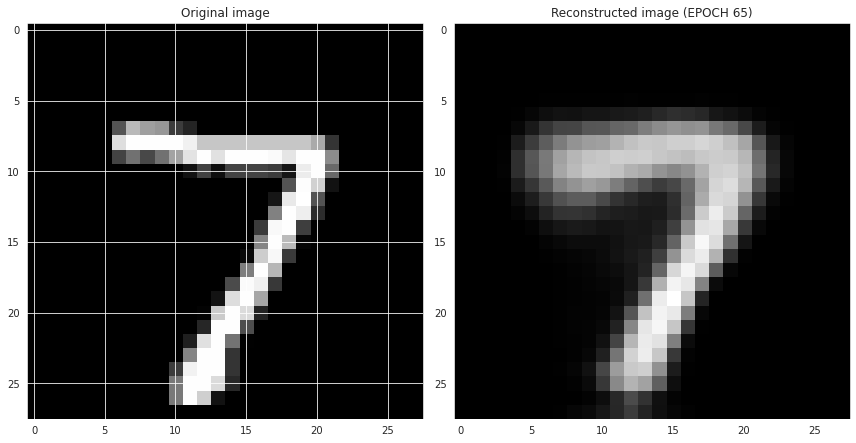

EPOCH 66/100
	 partial train loss (single batch): 0.042565
	 partial train loss (single batch): 0.041824
	 partial train loss (single batch): 0.044042
	 partial train loss (single batch): 0.042174
	 partial train loss (single batch): 0.043099
	 partial train loss (single batch): 0.043679
	 partial train loss (single batch): 0.041369
	 partial train loss (single batch): 0.042364
	 partial train loss (single batch): 0.041917
	 partial train loss (single batch): 0.045365
	 partial train loss (single batch): 0.042547
	 partial train loss (single batch): 0.041528
	 partial train loss (single batch): 0.042308
	 partial train loss (single batch): 0.040106
	 partial train loss (single batch): 0.041677
	 partial train loss (single batch): 0.040948
	 partial train loss (single batch): 0.039568
	 partial train loss (single batch): 0.041562
	 partial train loss (single batch): 0.041375
	 partial train loss (single batch): 0.039453
	 partial train loss (single batch): 0.043542
	 partial train loss 

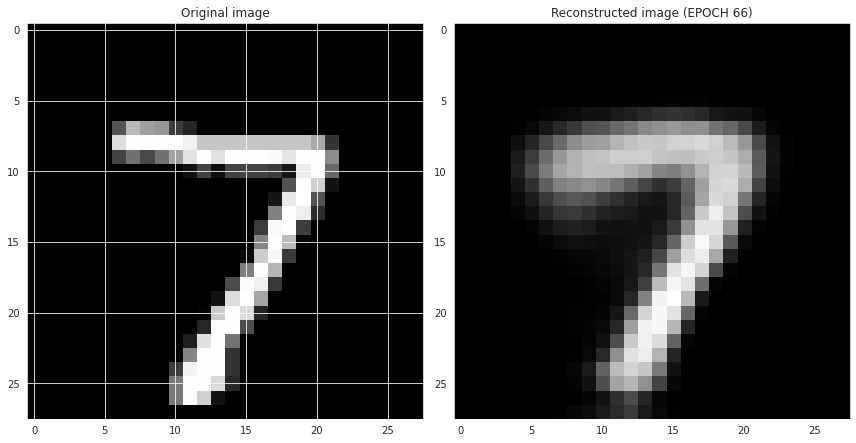

EPOCH 67/100
	 partial train loss (single batch): 0.041845
	 partial train loss (single batch): 0.041577
	 partial train loss (single batch): 0.042533
	 partial train loss (single batch): 0.041079
	 partial train loss (single batch): 0.043593
	 partial train loss (single batch): 0.041063
	 partial train loss (single batch): 0.042559
	 partial train loss (single batch): 0.041900
	 partial train loss (single batch): 0.040404
	 partial train loss (single batch): 0.042447
	 partial train loss (single batch): 0.041026
	 partial train loss (single batch): 0.041405
	 partial train loss (single batch): 0.043080
	 partial train loss (single batch): 0.041448
	 partial train loss (single batch): 0.040930
	 partial train loss (single batch): 0.042094
	 partial train loss (single batch): 0.040433
	 partial train loss (single batch): 0.042009
	 partial train loss (single batch): 0.040215
	 partial train loss (single batch): 0.040644
	 partial train loss (single batch): 0.042239
	 partial train loss 

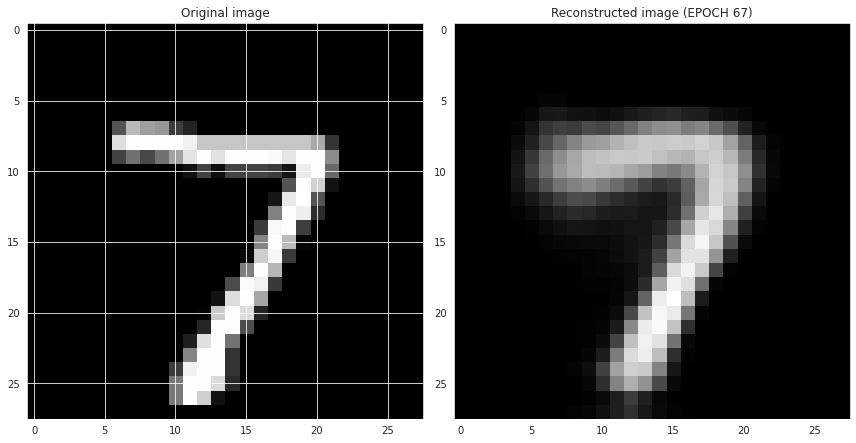

EPOCH 68/100
	 partial train loss (single batch): 0.041787
	 partial train loss (single batch): 0.041409
	 partial train loss (single batch): 0.040362
	 partial train loss (single batch): 0.043193
	 partial train loss (single batch): 0.042530
	 partial train loss (single batch): 0.042107
	 partial train loss (single batch): 0.041741
	 partial train loss (single batch): 0.044639
	 partial train loss (single batch): 0.043219
	 partial train loss (single batch): 0.042351
	 partial train loss (single batch): 0.039033
	 partial train loss (single batch): 0.041721
	 partial train loss (single batch): 0.042301
	 partial train loss (single batch): 0.042661
	 partial train loss (single batch): 0.042221
	 partial train loss (single batch): 0.041858
	 partial train loss (single batch): 0.042154
	 partial train loss (single batch): 0.040956
	 partial train loss (single batch): 0.040130
	 partial train loss (single batch): 0.041971
	 partial train loss (single batch): 0.042342
	 partial train loss 

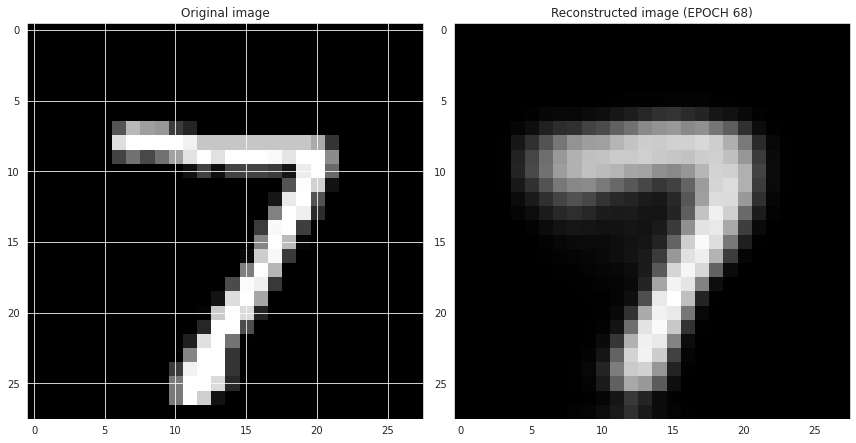

EPOCH 69/100
	 partial train loss (single batch): 0.042308
	 partial train loss (single batch): 0.042053
	 partial train loss (single batch): 0.043030
	 partial train loss (single batch): 0.040392
	 partial train loss (single batch): 0.041250
	 partial train loss (single batch): 0.043069
	 partial train loss (single batch): 0.041974
	 partial train loss (single batch): 0.042694
	 partial train loss (single batch): 0.041279
	 partial train loss (single batch): 0.042979
	 partial train loss (single batch): 0.041131
	 partial train loss (single batch): 0.043126
	 partial train loss (single batch): 0.041216
	 partial train loss (single batch): 0.043061
	 partial train loss (single batch): 0.043283
	 partial train loss (single batch): 0.042792
	 partial train loss (single batch): 0.042016
	 partial train loss (single batch): 0.044150
	 partial train loss (single batch): 0.042279
	 partial train loss (single batch): 0.043114
	 partial train loss (single batch): 0.042789
	 partial train loss 

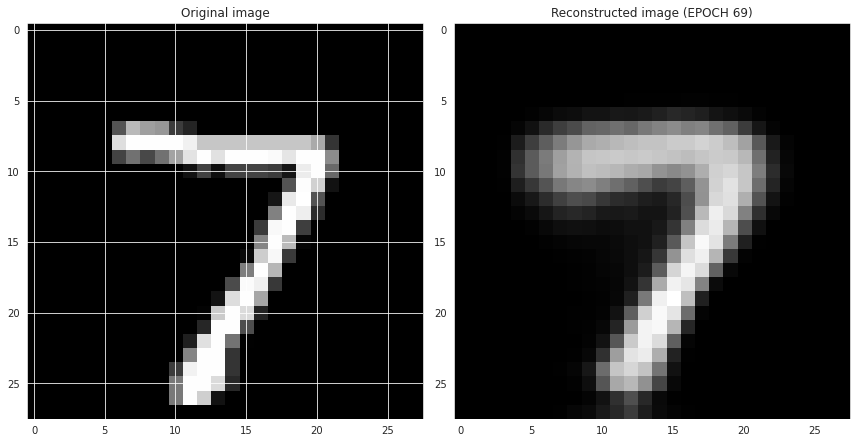

EPOCH 70/100
	 partial train loss (single batch): 0.042174
	 partial train loss (single batch): 0.042572
	 partial train loss (single batch): 0.040879
	 partial train loss (single batch): 0.040961
	 partial train loss (single batch): 0.041338
	 partial train loss (single batch): 0.042487
	 partial train loss (single batch): 0.041591
	 partial train loss (single batch): 0.040025
	 partial train loss (single batch): 0.042438
	 partial train loss (single batch): 0.041598
	 partial train loss (single batch): 0.042153
	 partial train loss (single batch): 0.042409
	 partial train loss (single batch): 0.039928
	 partial train loss (single batch): 0.043978
	 partial train loss (single batch): 0.041295
	 partial train loss (single batch): 0.043333
	 partial train loss (single batch): 0.043787
	 partial train loss (single batch): 0.042714
	 partial train loss (single batch): 0.040746
	 partial train loss (single batch): 0.040351
	 partial train loss (single batch): 0.041889
	 partial train loss 

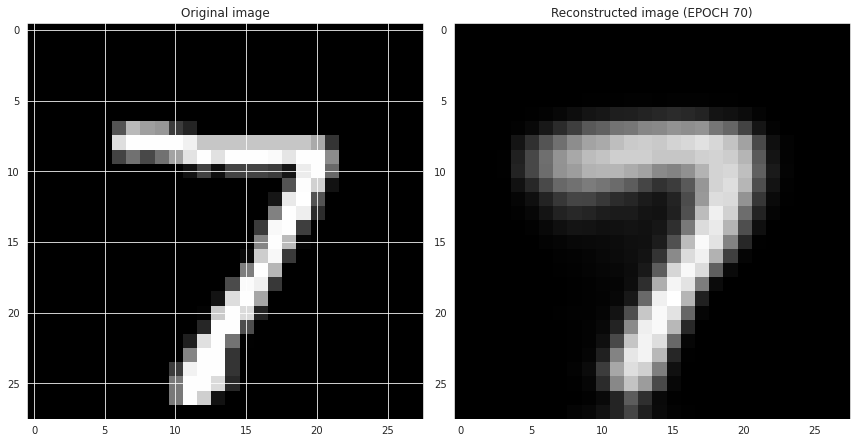

EPOCH 71/100
	 partial train loss (single batch): 0.043364
	 partial train loss (single batch): 0.041893
	 partial train loss (single batch): 0.040302
	 partial train loss (single batch): 0.043888
	 partial train loss (single batch): 0.042462
	 partial train loss (single batch): 0.041913
	 partial train loss (single batch): 0.043648
	 partial train loss (single batch): 0.041084
	 partial train loss (single batch): 0.043102
	 partial train loss (single batch): 0.043029
	 partial train loss (single batch): 0.041271
	 partial train loss (single batch): 0.040127
	 partial train loss (single batch): 0.041979
	 partial train loss (single batch): 0.044008
	 partial train loss (single batch): 0.042372
	 partial train loss (single batch): 0.040653
	 partial train loss (single batch): 0.042521
	 partial train loss (single batch): 0.041352
	 partial train loss (single batch): 0.039968
	 partial train loss (single batch): 0.041079
	 partial train loss (single batch): 0.041716
	 partial train loss 

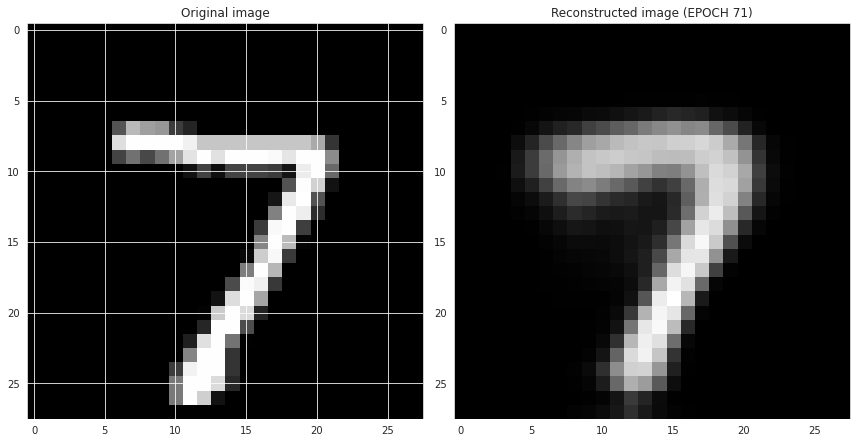

EPOCH 72/100
	 partial train loss (single batch): 0.042062
	 partial train loss (single batch): 0.043693
	 partial train loss (single batch): 0.043664
	 partial train loss (single batch): 0.041453
	 partial train loss (single batch): 0.042724
	 partial train loss (single batch): 0.041332
	 partial train loss (single batch): 0.042439
	 partial train loss (single batch): 0.041831
	 partial train loss (single batch): 0.040158
	 partial train loss (single batch): 0.040894
	 partial train loss (single batch): 0.042547
	 partial train loss (single batch): 0.041629
	 partial train loss (single batch): 0.041705
	 partial train loss (single batch): 0.040918
	 partial train loss (single batch): 0.041869
	 partial train loss (single batch): 0.042880
	 partial train loss (single batch): 0.040653
	 partial train loss (single batch): 0.044121
	 partial train loss (single batch): 0.040377
	 partial train loss (single batch): 0.040591
	 partial train loss (single batch): 0.040831
	 partial train loss 

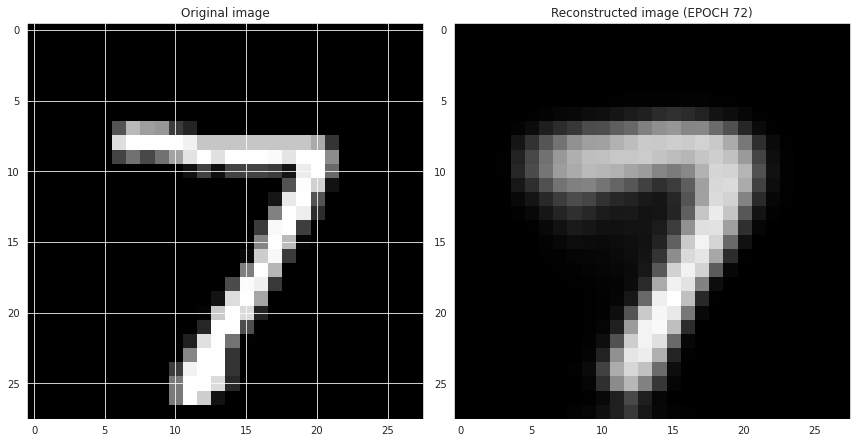

EPOCH 73/100
	 partial train loss (single batch): 0.042019
	 partial train loss (single batch): 0.041778
	 partial train loss (single batch): 0.041496
	 partial train loss (single batch): 0.043927
	 partial train loss (single batch): 0.042127
	 partial train loss (single batch): 0.041474
	 partial train loss (single batch): 0.041081
	 partial train loss (single batch): 0.042524
	 partial train loss (single batch): 0.042011
	 partial train loss (single batch): 0.041513
	 partial train loss (single batch): 0.043608
	 partial train loss (single batch): 0.040965
	 partial train loss (single batch): 0.041860
	 partial train loss (single batch): 0.040598
	 partial train loss (single batch): 0.041507
	 partial train loss (single batch): 0.041045
	 partial train loss (single batch): 0.040954
	 partial train loss (single batch): 0.041900
	 partial train loss (single batch): 0.042631
	 partial train loss (single batch): 0.040713
	 partial train loss (single batch): 0.043015
	 partial train loss 

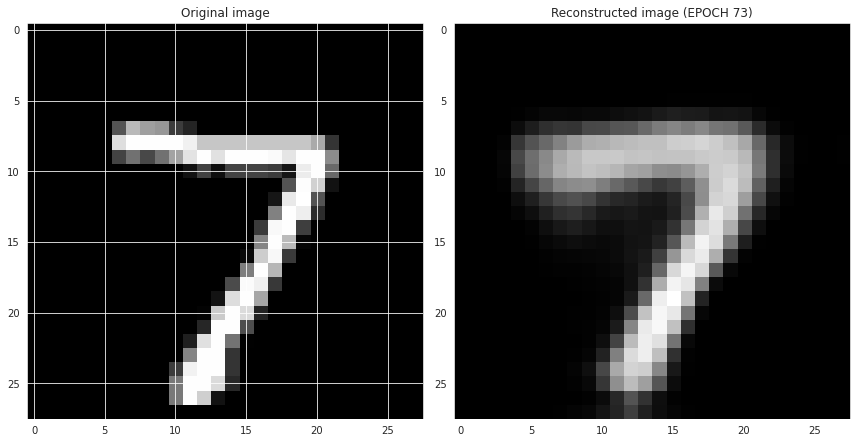

EPOCH 74/100
	 partial train loss (single batch): 0.041973
	 partial train loss (single batch): 0.041974
	 partial train loss (single batch): 0.040228
	 partial train loss (single batch): 0.039746
	 partial train loss (single batch): 0.042938
	 partial train loss (single batch): 0.042276
	 partial train loss (single batch): 0.042804
	 partial train loss (single batch): 0.042286
	 partial train loss (single batch): 0.043700
	 partial train loss (single batch): 0.042827
	 partial train loss (single batch): 0.044140
	 partial train loss (single batch): 0.043780
	 partial train loss (single batch): 0.042552
	 partial train loss (single batch): 0.043598
	 partial train loss (single batch): 0.044207
	 partial train loss (single batch): 0.040506
	 partial train loss (single batch): 0.039890
	 partial train loss (single batch): 0.042364
	 partial train loss (single batch): 0.042679
	 partial train loss (single batch): 0.042893
	 partial train loss (single batch): 0.041199
	 partial train loss 

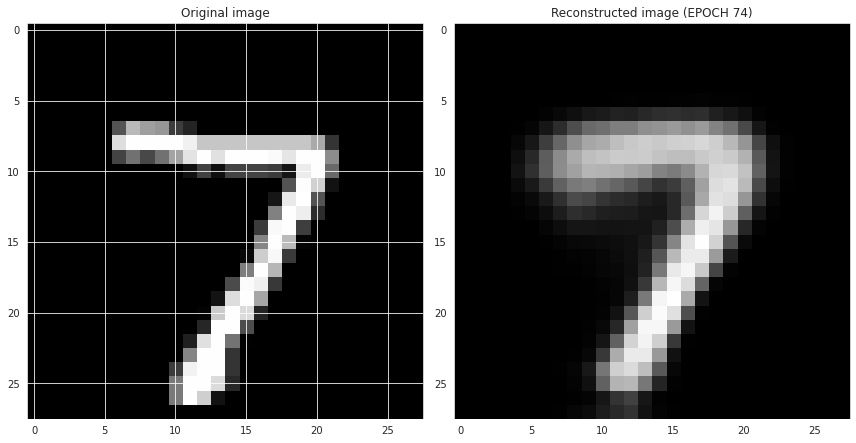

EPOCH 75/100
	 partial train loss (single batch): 0.040759
	 partial train loss (single batch): 0.042690
	 partial train loss (single batch): 0.041927
	 partial train loss (single batch): 0.042360
	 partial train loss (single batch): 0.041224
	 partial train loss (single batch): 0.040282
	 partial train loss (single batch): 0.042688
	 partial train loss (single batch): 0.042285
	 partial train loss (single batch): 0.042480
	 partial train loss (single batch): 0.041239
	 partial train loss (single batch): 0.042091
	 partial train loss (single batch): 0.040520
	 partial train loss (single batch): 0.040262
	 partial train loss (single batch): 0.042566
	 partial train loss (single batch): 0.040715
	 partial train loss (single batch): 0.041331
	 partial train loss (single batch): 0.042669
	 partial train loss (single batch): 0.040170
	 partial train loss (single batch): 0.042099
	 partial train loss (single batch): 0.040877
	 partial train loss (single batch): 0.040280
	 partial train loss 

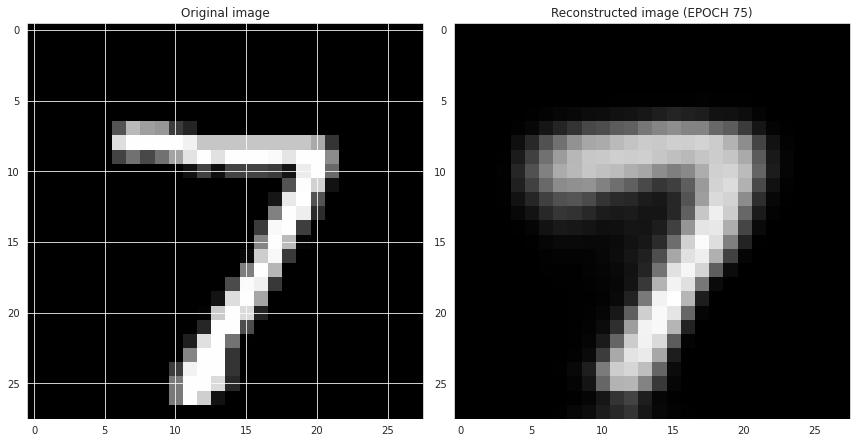

EPOCH 76/100
	 partial train loss (single batch): 0.042380
	 partial train loss (single batch): 0.041152
	 partial train loss (single batch): 0.039664
	 partial train loss (single batch): 0.041398
	 partial train loss (single batch): 0.042268
	 partial train loss (single batch): 0.043197
	 partial train loss (single batch): 0.040798
	 partial train loss (single batch): 0.041103
	 partial train loss (single batch): 0.041247
	 partial train loss (single batch): 0.044159
	 partial train loss (single batch): 0.043313
	 partial train loss (single batch): 0.041583
	 partial train loss (single batch): 0.042427
	 partial train loss (single batch): 0.040442
	 partial train loss (single batch): 0.042880
	 partial train loss (single batch): 0.041749
	 partial train loss (single batch): 0.043178
	 partial train loss (single batch): 0.042805
	 partial train loss (single batch): 0.042270
	 partial train loss (single batch): 0.043112
	 partial train loss (single batch): 0.042186
	 partial train loss 

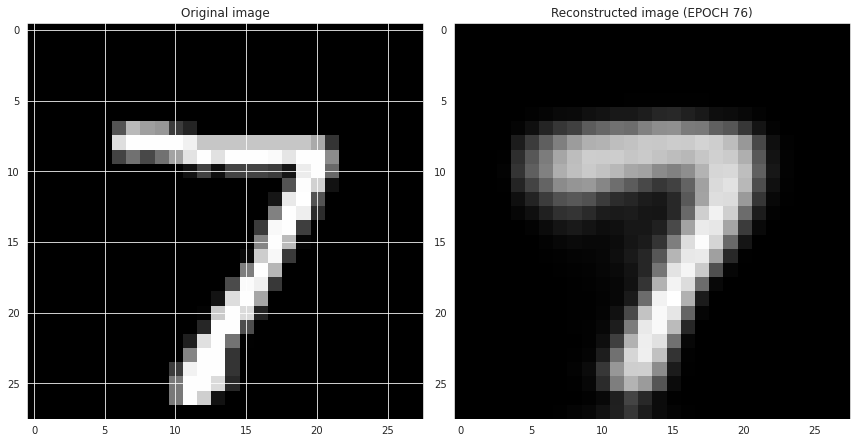

EPOCH 77/100
	 partial train loss (single batch): 0.041738
	 partial train loss (single batch): 0.040802
	 partial train loss (single batch): 0.042499
	 partial train loss (single batch): 0.041257
	 partial train loss (single batch): 0.042385
	 partial train loss (single batch): 0.043165
	 partial train loss (single batch): 0.041343
	 partial train loss (single batch): 0.043179
	 partial train loss (single batch): 0.043078
	 partial train loss (single batch): 0.042316
	 partial train loss (single batch): 0.042831
	 partial train loss (single batch): 0.042645
	 partial train loss (single batch): 0.041986
	 partial train loss (single batch): 0.041757
	 partial train loss (single batch): 0.042080
	 partial train loss (single batch): 0.041369
	 partial train loss (single batch): 0.041478
	 partial train loss (single batch): 0.041762
	 partial train loss (single batch): 0.041507
	 partial train loss (single batch): 0.040536
	 partial train loss (single batch): 0.041358
	 partial train loss 

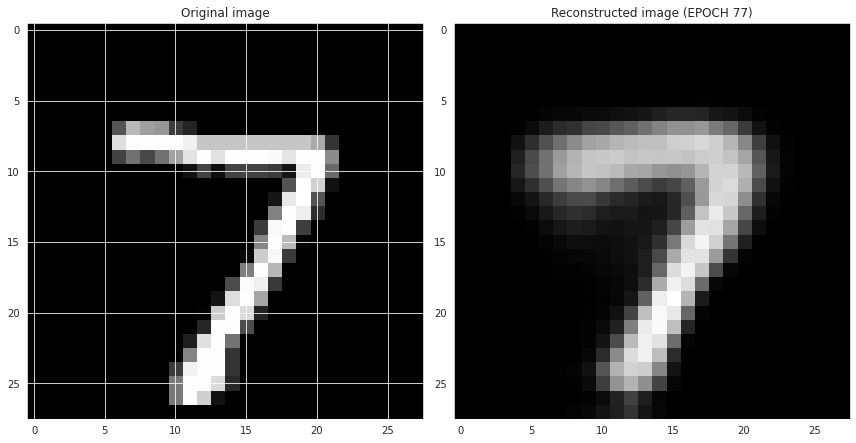

EPOCH 78/100
	 partial train loss (single batch): 0.042260
	 partial train loss (single batch): 0.041712
	 partial train loss (single batch): 0.041398
	 partial train loss (single batch): 0.040646
	 partial train loss (single batch): 0.042272
	 partial train loss (single batch): 0.042031
	 partial train loss (single batch): 0.041408
	 partial train loss (single batch): 0.040319
	 partial train loss (single batch): 0.040375
	 partial train loss (single batch): 0.041423
	 partial train loss (single batch): 0.043001
	 partial train loss (single batch): 0.041509
	 partial train loss (single batch): 0.042158
	 partial train loss (single batch): 0.041760
	 partial train loss (single batch): 0.042430
	 partial train loss (single batch): 0.042936
	 partial train loss (single batch): 0.039671
	 partial train loss (single batch): 0.041197
	 partial train loss (single batch): 0.043012
	 partial train loss (single batch): 0.041287
	 partial train loss (single batch): 0.041105
	 partial train loss 

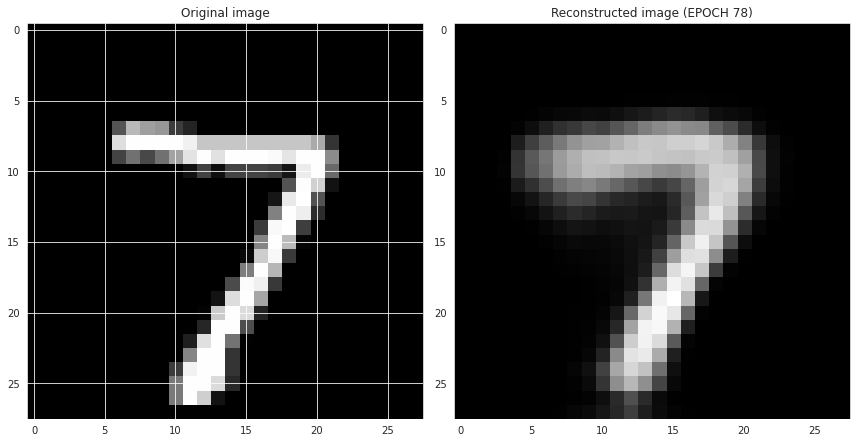

EPOCH 79/100
	 partial train loss (single batch): 0.041595
	 partial train loss (single batch): 0.040708
	 partial train loss (single batch): 0.040977
	 partial train loss (single batch): 0.041572
	 partial train loss (single batch): 0.041740
	 partial train loss (single batch): 0.040097
	 partial train loss (single batch): 0.041572
	 partial train loss (single batch): 0.041987
	 partial train loss (single batch): 0.041822
	 partial train loss (single batch): 0.042552
	 partial train loss (single batch): 0.043089
	 partial train loss (single batch): 0.042746
	 partial train loss (single batch): 0.044696
	 partial train loss (single batch): 0.041023
	 partial train loss (single batch): 0.040201
	 partial train loss (single batch): 0.043476
	 partial train loss (single batch): 0.040842
	 partial train loss (single batch): 0.041382
	 partial train loss (single batch): 0.042211
	 partial train loss (single batch): 0.042768
	 partial train loss (single batch): 0.042005
	 partial train loss 

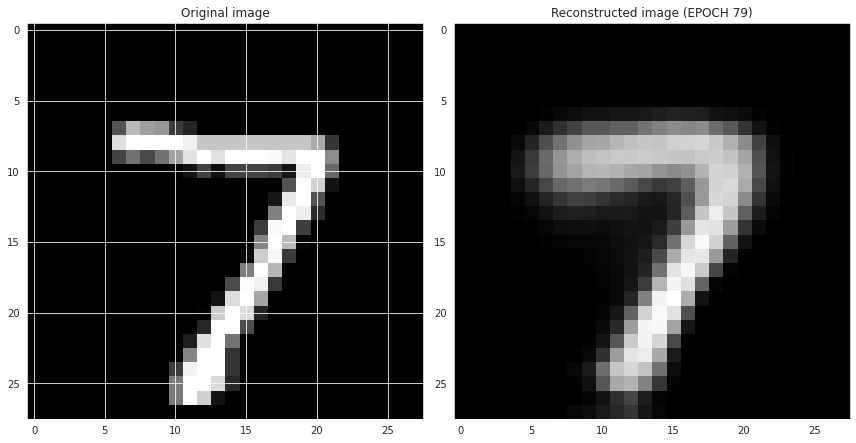

EPOCH 80/100
	 partial train loss (single batch): 0.044999
	 partial train loss (single batch): 0.041827
	 partial train loss (single batch): 0.043749
	 partial train loss (single batch): 0.040934
	 partial train loss (single batch): 0.041338
	 partial train loss (single batch): 0.042318
	 partial train loss (single batch): 0.039863
	 partial train loss (single batch): 0.041210
	 partial train loss (single batch): 0.041911
	 partial train loss (single batch): 0.042120
	 partial train loss (single batch): 0.041503
	 partial train loss (single batch): 0.039734
	 partial train loss (single batch): 0.042533
	 partial train loss (single batch): 0.042942
	 partial train loss (single batch): 0.039534
	 partial train loss (single batch): 0.041902
	 partial train loss (single batch): 0.044189
	 partial train loss (single batch): 0.043207
	 partial train loss (single batch): 0.041928
	 partial train loss (single batch): 0.041954
	 partial train loss (single batch): 0.040204
	 partial train loss 

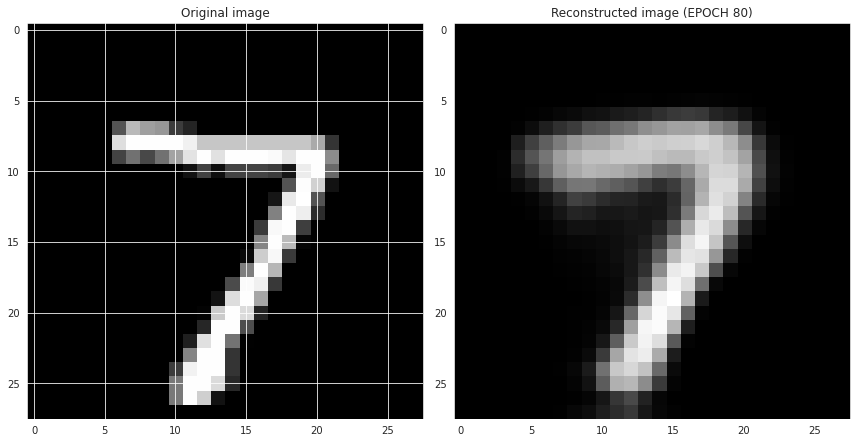

EPOCH 81/100
	 partial train loss (single batch): 0.041228
	 partial train loss (single batch): 0.041077
	 partial train loss (single batch): 0.041540
	 partial train loss (single batch): 0.042254
	 partial train loss (single batch): 0.041354
	 partial train loss (single batch): 0.041756
	 partial train loss (single batch): 0.041936
	 partial train loss (single batch): 0.040704
	 partial train loss (single batch): 0.041429
	 partial train loss (single batch): 0.039898
	 partial train loss (single batch): 0.040283
	 partial train loss (single batch): 0.042217
	 partial train loss (single batch): 0.042765
	 partial train loss (single batch): 0.043759
	 partial train loss (single batch): 0.041482
	 partial train loss (single batch): 0.040148
	 partial train loss (single batch): 0.041898
	 partial train loss (single batch): 0.042217
	 partial train loss (single batch): 0.041601
	 partial train loss (single batch): 0.042739
	 partial train loss (single batch): 0.041874
	 partial train loss 

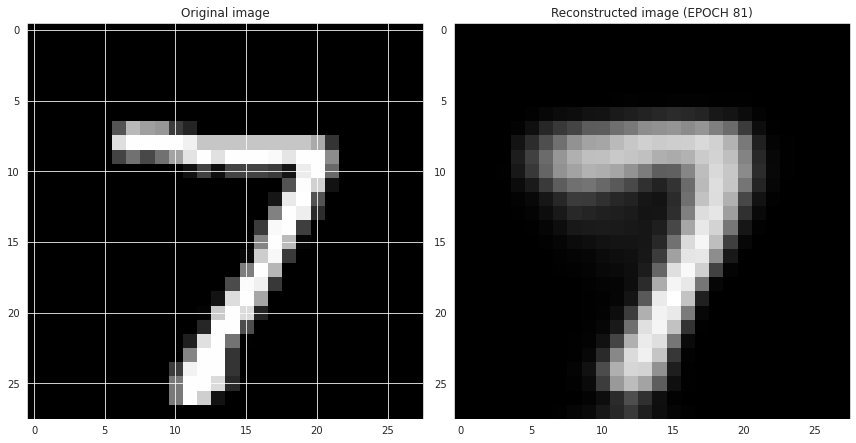

EPOCH 82/100
	 partial train loss (single batch): 0.041781
	 partial train loss (single batch): 0.041987
	 partial train loss (single batch): 0.039141
	 partial train loss (single batch): 0.042904
	 partial train loss (single batch): 0.041013
	 partial train loss (single batch): 0.041430
	 partial train loss (single batch): 0.043006
	 partial train loss (single batch): 0.041218
	 partial train loss (single batch): 0.040758
	 partial train loss (single batch): 0.042531
	 partial train loss (single batch): 0.044643
	 partial train loss (single batch): 0.041346
	 partial train loss (single batch): 0.041287
	 partial train loss (single batch): 0.044104
	 partial train loss (single batch): 0.042994
	 partial train loss (single batch): 0.042786
	 partial train loss (single batch): 0.042526
	 partial train loss (single batch): 0.041193
	 partial train loss (single batch): 0.041124
	 partial train loss (single batch): 0.042478
	 partial train loss (single batch): 0.042055
	 partial train loss 

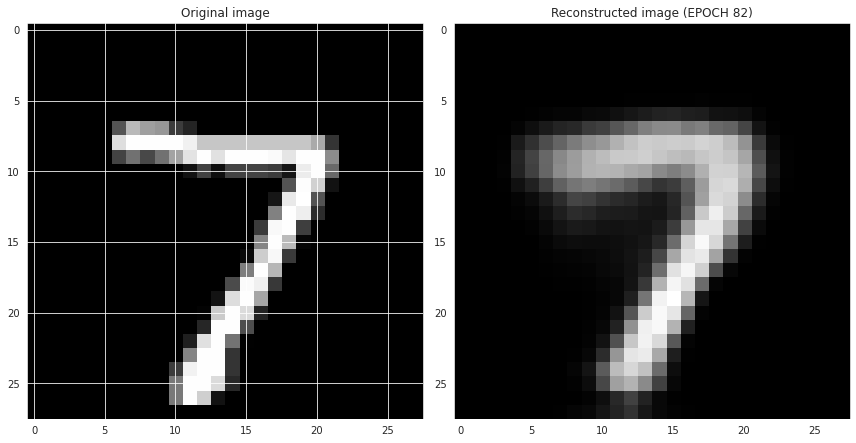

EPOCH 83/100
	 partial train loss (single batch): 0.041170
	 partial train loss (single batch): 0.041546
	 partial train loss (single batch): 0.041398
	 partial train loss (single batch): 0.043673
	 partial train loss (single batch): 0.040994
	 partial train loss (single batch): 0.039862
	 partial train loss (single batch): 0.040571
	 partial train loss (single batch): 0.040802
	 partial train loss (single batch): 0.044130
	 partial train loss (single batch): 0.041201
	 partial train loss (single batch): 0.043980
	 partial train loss (single batch): 0.041218
	 partial train loss (single batch): 0.041380
	 partial train loss (single batch): 0.042227
	 partial train loss (single batch): 0.042353
	 partial train loss (single batch): 0.043451
	 partial train loss (single batch): 0.040925
	 partial train loss (single batch): 0.040511
	 partial train loss (single batch): 0.041859
	 partial train loss (single batch): 0.042543
	 partial train loss (single batch): 0.041514
	 partial train loss 

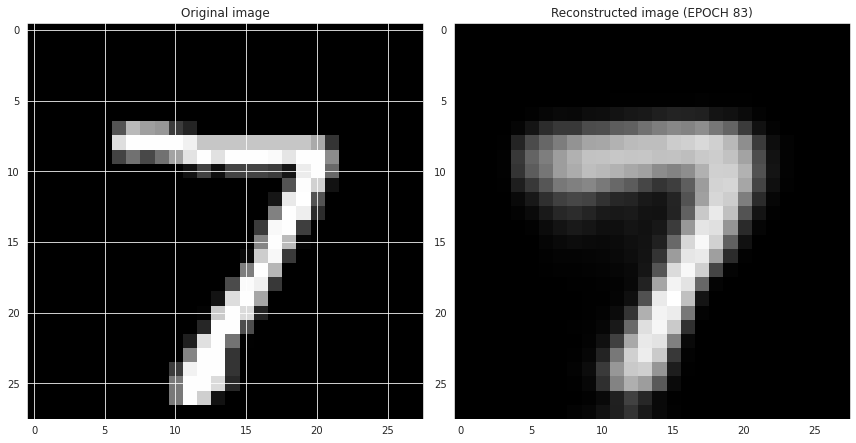

EPOCH 84/100
	 partial train loss (single batch): 0.042430
	 partial train loss (single batch): 0.042387
	 partial train loss (single batch): 0.041168
	 partial train loss (single batch): 0.042104
	 partial train loss (single batch): 0.042141
	 partial train loss (single batch): 0.040804
	 partial train loss (single batch): 0.040329
	 partial train loss (single batch): 0.040348
	 partial train loss (single batch): 0.041154
	 partial train loss (single batch): 0.041037
	 partial train loss (single batch): 0.042008
	 partial train loss (single batch): 0.043278
	 partial train loss (single batch): 0.040791
	 partial train loss (single batch): 0.041802
	 partial train loss (single batch): 0.043735
	 partial train loss (single batch): 0.041617
	 partial train loss (single batch): 0.041026
	 partial train loss (single batch): 0.041711
	 partial train loss (single batch): 0.041409
	 partial train loss (single batch): 0.042643
	 partial train loss (single batch): 0.040715
	 partial train loss 

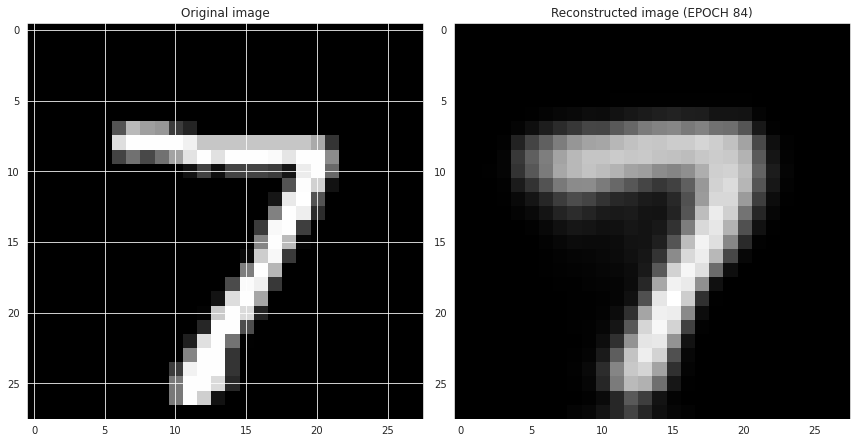

EPOCH 85/100
	 partial train loss (single batch): 0.041423
	 partial train loss (single batch): 0.043874
	 partial train loss (single batch): 0.040737
	 partial train loss (single batch): 0.042276
	 partial train loss (single batch): 0.041583
	 partial train loss (single batch): 0.041784
	 partial train loss (single batch): 0.041568
	 partial train loss (single batch): 0.043111
	 partial train loss (single batch): 0.041011
	 partial train loss (single batch): 0.043489
	 partial train loss (single batch): 0.042072
	 partial train loss (single batch): 0.040653
	 partial train loss (single batch): 0.042719
	 partial train loss (single batch): 0.041839
	 partial train loss (single batch): 0.039604
	 partial train loss (single batch): 0.042156
	 partial train loss (single batch): 0.042504
	 partial train loss (single batch): 0.043202
	 partial train loss (single batch): 0.039310
	 partial train loss (single batch): 0.040401
	 partial train loss (single batch): 0.042675
	 partial train loss 

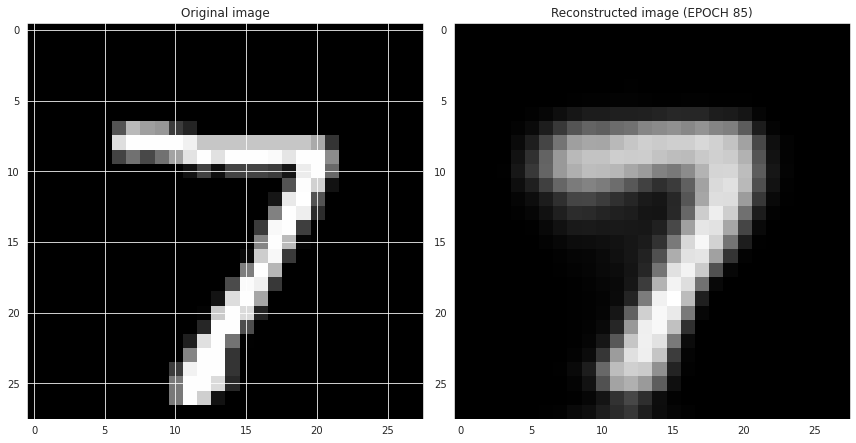

EPOCH 86/100
	 partial train loss (single batch): 0.043001
	 partial train loss (single batch): 0.042082
	 partial train loss (single batch): 0.041076
	 partial train loss (single batch): 0.040639
	 partial train loss (single batch): 0.040429
	 partial train loss (single batch): 0.041225
	 partial train loss (single batch): 0.041512
	 partial train loss (single batch): 0.041578
	 partial train loss (single batch): 0.040380
	 partial train loss (single batch): 0.042346
	 partial train loss (single batch): 0.040418
	 partial train loss (single batch): 0.042190
	 partial train loss (single batch): 0.041771
	 partial train loss (single batch): 0.041917
	 partial train loss (single batch): 0.040825
	 partial train loss (single batch): 0.040941
	 partial train loss (single batch): 0.042227
	 partial train loss (single batch): 0.042165
	 partial train loss (single batch): 0.041837
	 partial train loss (single batch): 0.042844
	 partial train loss (single batch): 0.042930
	 partial train loss 

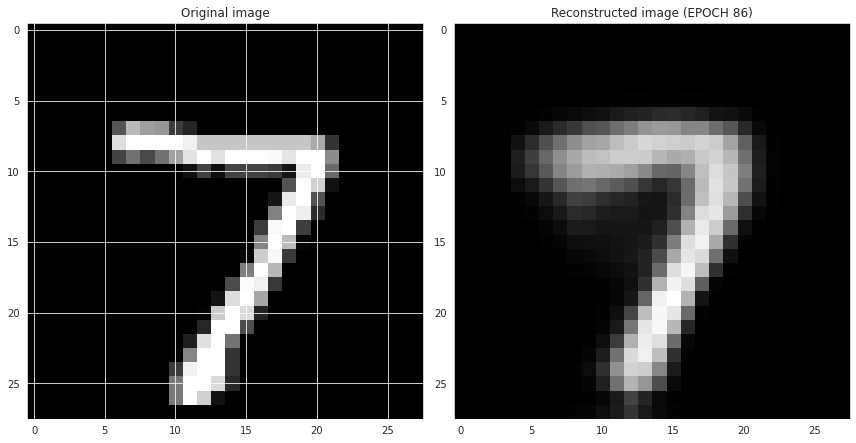

EPOCH 87/100
	 partial train loss (single batch): 0.043787
	 partial train loss (single batch): 0.042776
	 partial train loss (single batch): 0.041986
	 partial train loss (single batch): 0.040093
	 partial train loss (single batch): 0.042464
	 partial train loss (single batch): 0.041249
	 partial train loss (single batch): 0.039021
	 partial train loss (single batch): 0.042229
	 partial train loss (single batch): 0.042915
	 partial train loss (single batch): 0.041547
	 partial train loss (single batch): 0.041688
	 partial train loss (single batch): 0.043065
	 partial train loss (single batch): 0.042903
	 partial train loss (single batch): 0.040666
	 partial train loss (single batch): 0.042424
	 partial train loss (single batch): 0.041169
	 partial train loss (single batch): 0.044582
	 partial train loss (single batch): 0.040953
	 partial train loss (single batch): 0.042450
	 partial train loss (single batch): 0.040824
	 partial train loss (single batch): 0.043616
	 partial train loss 

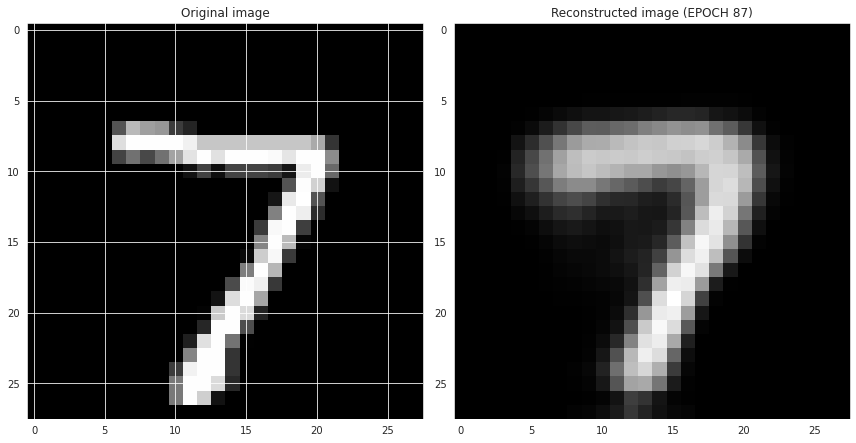

EPOCH 88/100
	 partial train loss (single batch): 0.043271
	 partial train loss (single batch): 0.040734
	 partial train loss (single batch): 0.041569
	 partial train loss (single batch): 0.041142
	 partial train loss (single batch): 0.042871
	 partial train loss (single batch): 0.038885
	 partial train loss (single batch): 0.040688
	 partial train loss (single batch): 0.042255
	 partial train loss (single batch): 0.039694
	 partial train loss (single batch): 0.042182
	 partial train loss (single batch): 0.043257
	 partial train loss (single batch): 0.042898
	 partial train loss (single batch): 0.040493
	 partial train loss (single batch): 0.041304
	 partial train loss (single batch): 0.042077
	 partial train loss (single batch): 0.042441
	 partial train loss (single batch): 0.042109
	 partial train loss (single batch): 0.041860
	 partial train loss (single batch): 0.042924
	 partial train loss (single batch): 0.040876
	 partial train loss (single batch): 0.040706
	 partial train loss 

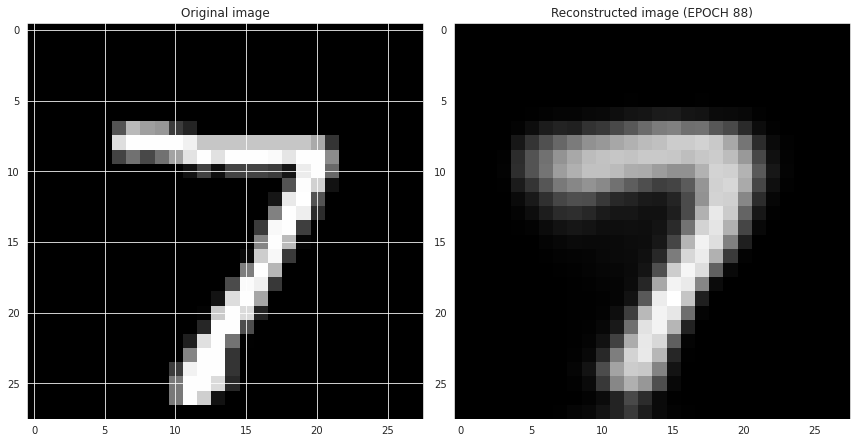

EPOCH 89/100
	 partial train loss (single batch): 0.042133
	 partial train loss (single batch): 0.042238
	 partial train loss (single batch): 0.040830
	 partial train loss (single batch): 0.042437
	 partial train loss (single batch): 0.040226
	 partial train loss (single batch): 0.039862
	 partial train loss (single batch): 0.041356
	 partial train loss (single batch): 0.042152
	 partial train loss (single batch): 0.044079
	 partial train loss (single batch): 0.041398
	 partial train loss (single batch): 0.040353
	 partial train loss (single batch): 0.041821
	 partial train loss (single batch): 0.042276
	 partial train loss (single batch): 0.041631
	 partial train loss (single batch): 0.042218
	 partial train loss (single batch): 0.040025
	 partial train loss (single batch): 0.041780
	 partial train loss (single batch): 0.043880
	 partial train loss (single batch): 0.041400
	 partial train loss (single batch): 0.040206
	 partial train loss (single batch): 0.041292
	 partial train loss 

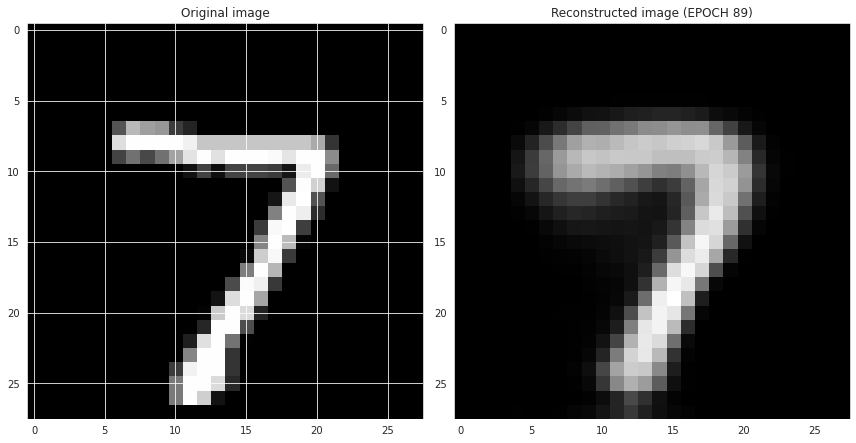

EPOCH 90/100
	 partial train loss (single batch): 0.043092
	 partial train loss (single batch): 0.041020
	 partial train loss (single batch): 0.040961
	 partial train loss (single batch): 0.039361
	 partial train loss (single batch): 0.041501
	 partial train loss (single batch): 0.041610
	 partial train loss (single batch): 0.042445
	 partial train loss (single batch): 0.043723
	 partial train loss (single batch): 0.042390
	 partial train loss (single batch): 0.043884
	 partial train loss (single batch): 0.041615
	 partial train loss (single batch): 0.042324
	 partial train loss (single batch): 0.038984
	 partial train loss (single batch): 0.042403
	 partial train loss (single batch): 0.042216
	 partial train loss (single batch): 0.041581
	 partial train loss (single batch): 0.040740
	 partial train loss (single batch): 0.041893
	 partial train loss (single batch): 0.041570
	 partial train loss (single batch): 0.040318
	 partial train loss (single batch): 0.041988
	 partial train loss 

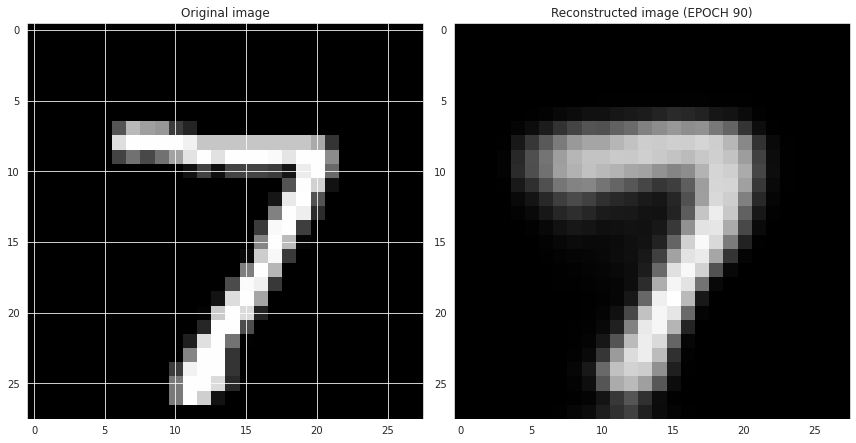

EPOCH 91/100
	 partial train loss (single batch): 0.040941
	 partial train loss (single batch): 0.042654
	 partial train loss (single batch): 0.041097
	 partial train loss (single batch): 0.040554
	 partial train loss (single batch): 0.042530
	 partial train loss (single batch): 0.040781
	 partial train loss (single batch): 0.042679
	 partial train loss (single batch): 0.040780
	 partial train loss (single batch): 0.040937
	 partial train loss (single batch): 0.042133
	 partial train loss (single batch): 0.041299
	 partial train loss (single batch): 0.041436
	 partial train loss (single batch): 0.042767
	 partial train loss (single batch): 0.040379
	 partial train loss (single batch): 0.039788
	 partial train loss (single batch): 0.041509
	 partial train loss (single batch): 0.042693
	 partial train loss (single batch): 0.040843
	 partial train loss (single batch): 0.042747
	 partial train loss (single batch): 0.040119
	 partial train loss (single batch): 0.041283
	 partial train loss 

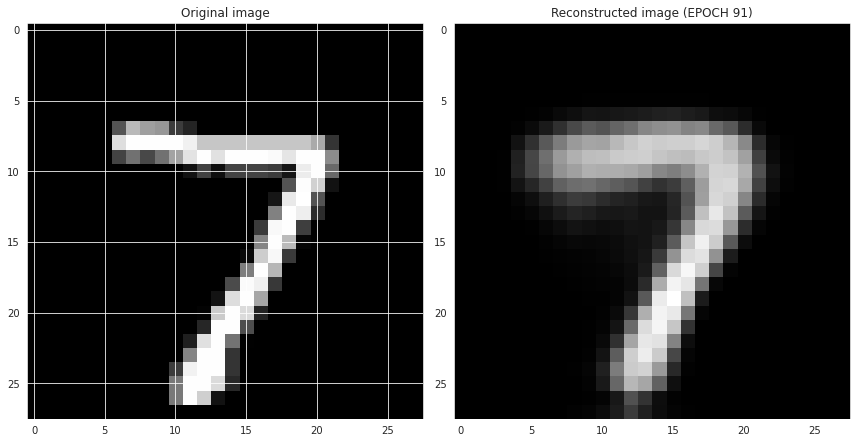

EPOCH 92/100
	 partial train loss (single batch): 0.042428
	 partial train loss (single batch): 0.041958
	 partial train loss (single batch): 0.041262
	 partial train loss (single batch): 0.042974
	 partial train loss (single batch): 0.042415
	 partial train loss (single batch): 0.042139
	 partial train loss (single batch): 0.043281
	 partial train loss (single batch): 0.042056
	 partial train loss (single batch): 0.041749
	 partial train loss (single batch): 0.042269
	 partial train loss (single batch): 0.042110
	 partial train loss (single batch): 0.040525
	 partial train loss (single batch): 0.040984
	 partial train loss (single batch): 0.039968
	 partial train loss (single batch): 0.039439
	 partial train loss (single batch): 0.040641
	 partial train loss (single batch): 0.041593
	 partial train loss (single batch): 0.042919
	 partial train loss (single batch): 0.040649
	 partial train loss (single batch): 0.041925
	 partial train loss (single batch): 0.041166
	 partial train loss 

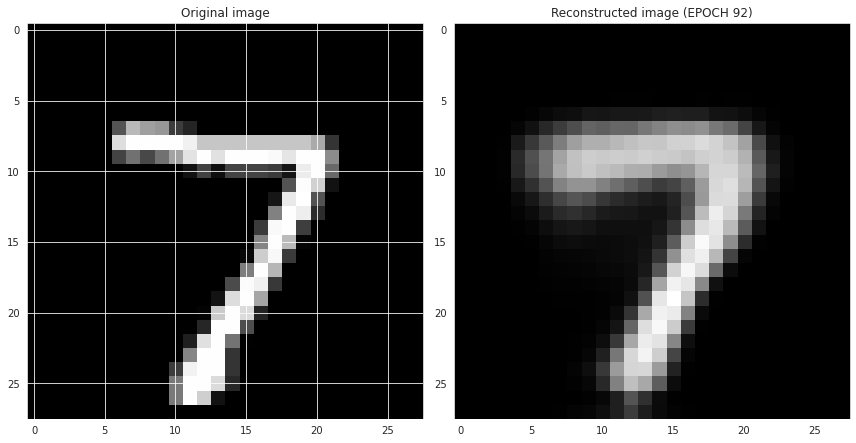

EPOCH 93/100
	 partial train loss (single batch): 0.040477
	 partial train loss (single batch): 0.041001
	 partial train loss (single batch): 0.040821
	 partial train loss (single batch): 0.042040
	 partial train loss (single batch): 0.041826
	 partial train loss (single batch): 0.044297
	 partial train loss (single batch): 0.041465
	 partial train loss (single batch): 0.042533
	 partial train loss (single batch): 0.039589
	 partial train loss (single batch): 0.040251
	 partial train loss (single batch): 0.041034
	 partial train loss (single batch): 0.041607
	 partial train loss (single batch): 0.043966
	 partial train loss (single batch): 0.039262
	 partial train loss (single batch): 0.039313
	 partial train loss (single batch): 0.042703
	 partial train loss (single batch): 0.040239
	 partial train loss (single batch): 0.042363
	 partial train loss (single batch): 0.042136
	 partial train loss (single batch): 0.043692
	 partial train loss (single batch): 0.041318
	 partial train loss 

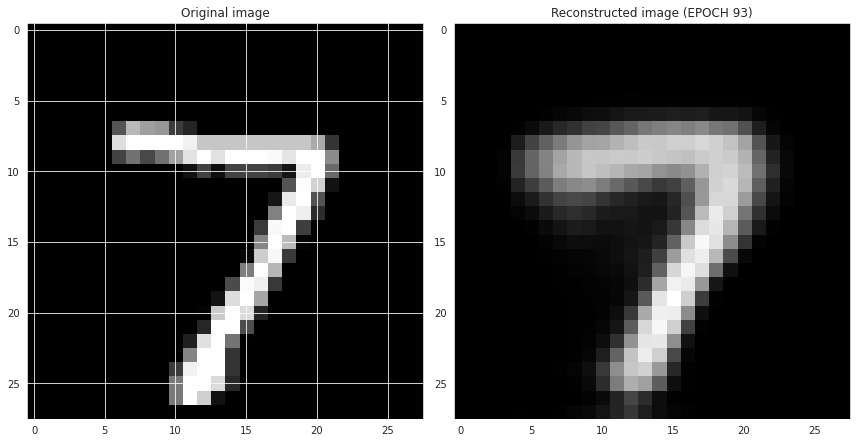

EPOCH 94/100
	 partial train loss (single batch): 0.041876
	 partial train loss (single batch): 0.040222
	 partial train loss (single batch): 0.042332
	 partial train loss (single batch): 0.042426
	 partial train loss (single batch): 0.042142
	 partial train loss (single batch): 0.040533
	 partial train loss (single batch): 0.041038
	 partial train loss (single batch): 0.040927
	 partial train loss (single batch): 0.042936
	 partial train loss (single batch): 0.039393
	 partial train loss (single batch): 0.041549
	 partial train loss (single batch): 0.040429
	 partial train loss (single batch): 0.041957
	 partial train loss (single batch): 0.041756
	 partial train loss (single batch): 0.039788
	 partial train loss (single batch): 0.043039
	 partial train loss (single batch): 0.041770
	 partial train loss (single batch): 0.040395
	 partial train loss (single batch): 0.041434
	 partial train loss (single batch): 0.041738
	 partial train loss (single batch): 0.043848
	 partial train loss 

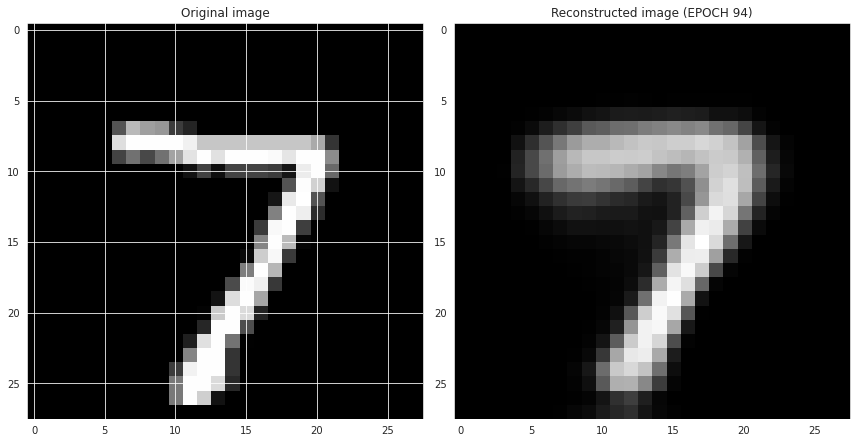

EPOCH 95/100
	 partial train loss (single batch): 0.041997
	 partial train loss (single batch): 0.040244
	 partial train loss (single batch): 0.041701
	 partial train loss (single batch): 0.041194
	 partial train loss (single batch): 0.042082
	 partial train loss (single batch): 0.041714
	 partial train loss (single batch): 0.040540
	 partial train loss (single batch): 0.041898
	 partial train loss (single batch): 0.042189
	 partial train loss (single batch): 0.041470
	 partial train loss (single batch): 0.041357
	 partial train loss (single batch): 0.039878
	 partial train loss (single batch): 0.041354
	 partial train loss (single batch): 0.041070
	 partial train loss (single batch): 0.042244
	 partial train loss (single batch): 0.041362
	 partial train loss (single batch): 0.041470
	 partial train loss (single batch): 0.042769
	 partial train loss (single batch): 0.042205
	 partial train loss (single batch): 0.041640
	 partial train loss (single batch): 0.041904
	 partial train loss 

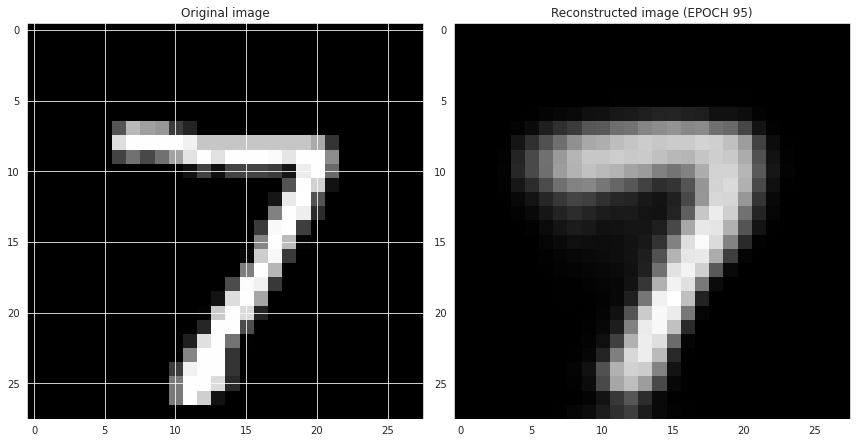

EPOCH 96/100
	 partial train loss (single batch): 0.041674
	 partial train loss (single batch): 0.039629
	 partial train loss (single batch): 0.042228
	 partial train loss (single batch): 0.040794
	 partial train loss (single batch): 0.043275
	 partial train loss (single batch): 0.042141
	 partial train loss (single batch): 0.041895
	 partial train loss (single batch): 0.042461
	 partial train loss (single batch): 0.042327
	 partial train loss (single batch): 0.040716
	 partial train loss (single batch): 0.042245
	 partial train loss (single batch): 0.040525
	 partial train loss (single batch): 0.042275
	 partial train loss (single batch): 0.040363
	 partial train loss (single batch): 0.040055
	 partial train loss (single batch): 0.042275
	 partial train loss (single batch): 0.041048
	 partial train loss (single batch): 0.040806
	 partial train loss (single batch): 0.042497
	 partial train loss (single batch): 0.042738
	 partial train loss (single batch): 0.044468
	 partial train loss 

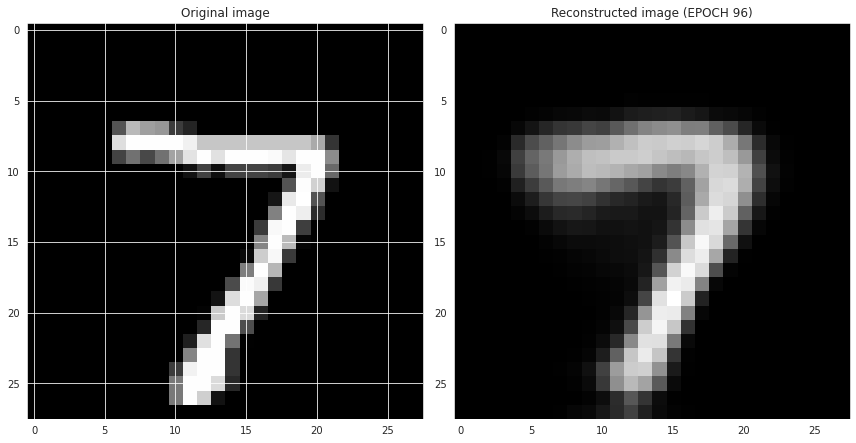

EPOCH 97/100
	 partial train loss (single batch): 0.041161
	 partial train loss (single batch): 0.040739
	 partial train loss (single batch): 0.041906
	 partial train loss (single batch): 0.041852
	 partial train loss (single batch): 0.041737
	 partial train loss (single batch): 0.041479
	 partial train loss (single batch): 0.040891
	 partial train loss (single batch): 0.043283
	 partial train loss (single batch): 0.042764
	 partial train loss (single batch): 0.042405
	 partial train loss (single batch): 0.040556
	 partial train loss (single batch): 0.040450
	 partial train loss (single batch): 0.041904
	 partial train loss (single batch): 0.039629
	 partial train loss (single batch): 0.042549
	 partial train loss (single batch): 0.041867
	 partial train loss (single batch): 0.042355
	 partial train loss (single batch): 0.041459
	 partial train loss (single batch): 0.040254
	 partial train loss (single batch): 0.043039
	 partial train loss (single batch): 0.042335
	 partial train loss 

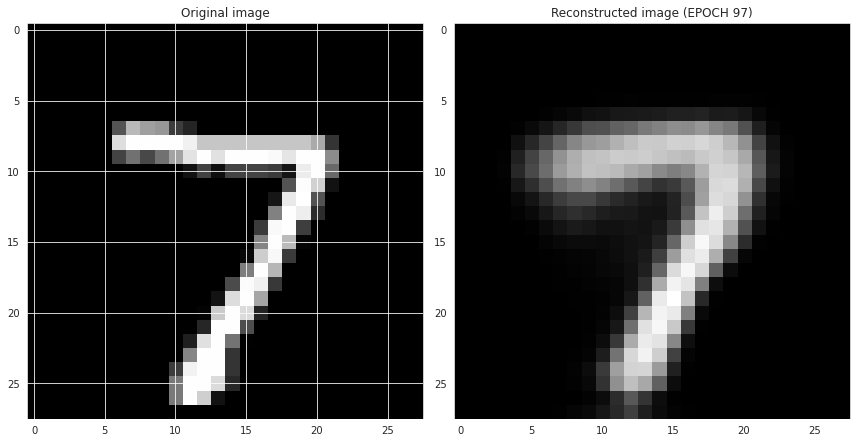

EPOCH 98/100
	 partial train loss (single batch): 0.041426
	 partial train loss (single batch): 0.041627
	 partial train loss (single batch): 0.043618
	 partial train loss (single batch): 0.041146
	 partial train loss (single batch): 0.041374
	 partial train loss (single batch): 0.042030
	 partial train loss (single batch): 0.041216
	 partial train loss (single batch): 0.040780
	 partial train loss (single batch): 0.041359
	 partial train loss (single batch): 0.041700
	 partial train loss (single batch): 0.041656
	 partial train loss (single batch): 0.040556
	 partial train loss (single batch): 0.041538
	 partial train loss (single batch): 0.043195
	 partial train loss (single batch): 0.040825
	 partial train loss (single batch): 0.042288
	 partial train loss (single batch): 0.041836
	 partial train loss (single batch): 0.040914
	 partial train loss (single batch): 0.040796
	 partial train loss (single batch): 0.041438
	 partial train loss (single batch): 0.042233
	 partial train loss 

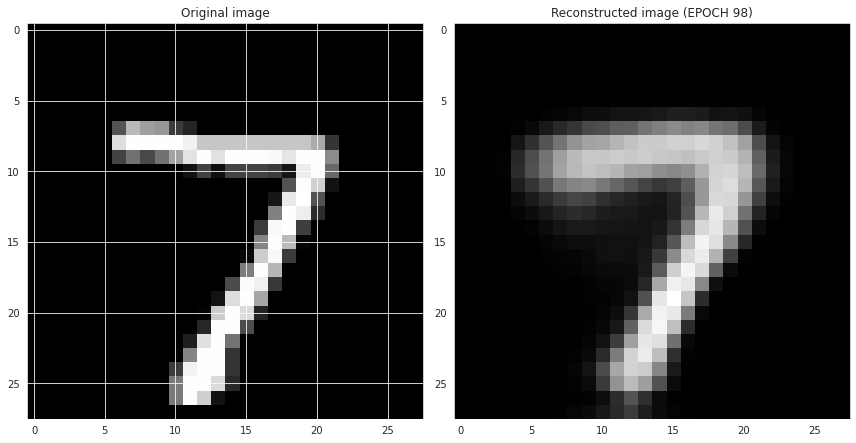

EPOCH 99/100
	 partial train loss (single batch): 0.040710
	 partial train loss (single batch): 0.040896
	 partial train loss (single batch): 0.041569
	 partial train loss (single batch): 0.040835
	 partial train loss (single batch): 0.039785
	 partial train loss (single batch): 0.038446
	 partial train loss (single batch): 0.041272
	 partial train loss (single batch): 0.043104
	 partial train loss (single batch): 0.043496
	 partial train loss (single batch): 0.042046
	 partial train loss (single batch): 0.041647
	 partial train loss (single batch): 0.040660
	 partial train loss (single batch): 0.040175
	 partial train loss (single batch): 0.043419
	 partial train loss (single batch): 0.041542
	 partial train loss (single batch): 0.040879
	 partial train loss (single batch): 0.039655
	 partial train loss (single batch): 0.041289
	 partial train loss (single batch): 0.041649
	 partial train loss (single batch): 0.041065
	 partial train loss (single batch): 0.040846
	 partial train loss 

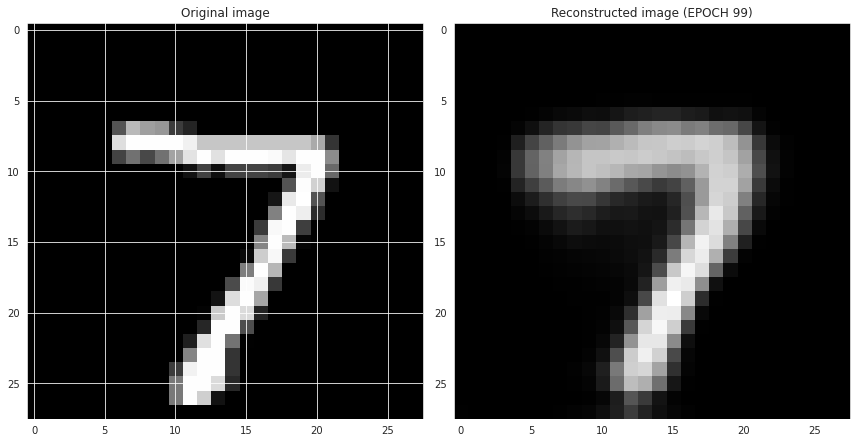

EPOCH 100/100
	 partial train loss (single batch): 0.039868
	 partial train loss (single batch): 0.040901
	 partial train loss (single batch): 0.040882
	 partial train loss (single batch): 0.041306
	 partial train loss (single batch): 0.040977
	 partial train loss (single batch): 0.042104
	 partial train loss (single batch): 0.042066
	 partial train loss (single batch): 0.042660
	 partial train loss (single batch): 0.044047
	 partial train loss (single batch): 0.042508
	 partial train loss (single batch): 0.043089
	 partial train loss (single batch): 0.041101
	 partial train loss (single batch): 0.041888
	 partial train loss (single batch): 0.043160
	 partial train loss (single batch): 0.041518
	 partial train loss (single batch): 0.040891
	 partial train loss (single batch): 0.043086
	 partial train loss (single batch): 0.041817
	 partial train loss (single batch): 0.040666
	 partial train loss (single batch): 0.042365
	 partial train loss (single batch): 0.040061
	 partial train loss

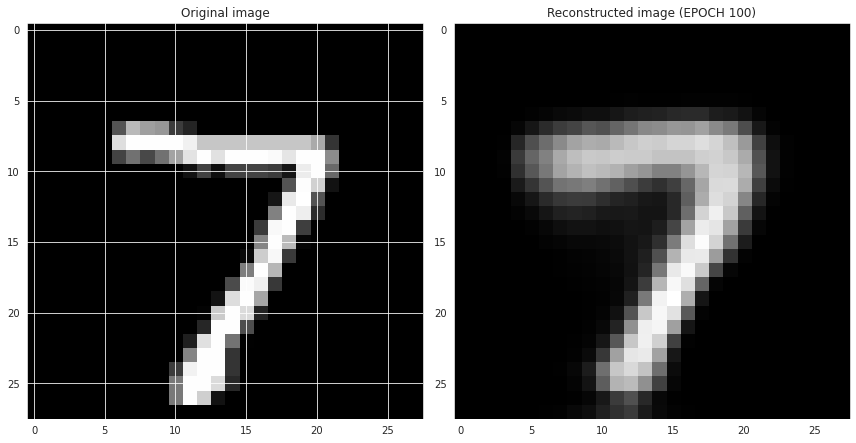

	Train Loss: 0.04 	Val Loss: 0.039


In [21]:
import gc
best_hyper=None
best_loss=None
for i,hyper in enumerate(iterations):
    print("\n\nIteration:",i,hyper)
    encoded_space_dim,conv1,conv2,conv3,fc,lr,l2, drop=hyper
    
    ### Initialize the two networks
    encoder = Encoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)
    decoder = Decoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)

    # Define the loss function
    loss_fn = torch.nn.MSELoss()

    ### Define an optimizer (both for the encoder and the decoder!)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=l2)

    # Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)
    
    
    #TRAINING CYCLE
    train_loss_log,val_loss_log=training_cycle(num_epochs,
                                           early_stopping,
                                           encoder,
                                           decoder,
                                           loss_fn,
                                           optim,
                                           train_dataloader,
                                           device, 
                                           test_dataset)
    train_loss=train_loss_log[-1]
    val_loss=val_loss_log[-1]
    print("\tTrain Loss:",round(float(train_loss),3),"\tVal Loss:",round(float(val_loss),3))
    
    if not best_loss or val_loss<best_loss:
        best_loss=val_loss
        best_hyper=hyper


    gc.collect()
        


In [ ]:
print("\n\nBest Model:",best_hyper)



Best Model: (2, 8, 16, 64, 64, 0.001, 1e-05, 0.1)


In [20]:
# Best Parameters
space_dim = [2]
num_epochs=100
early_stopping=55
Conv1=[8]
Conv2=[16]
Conv3=[64]
FC=[64]
LR=[0.001]
L2=[1e-5]
drop=[0.1]

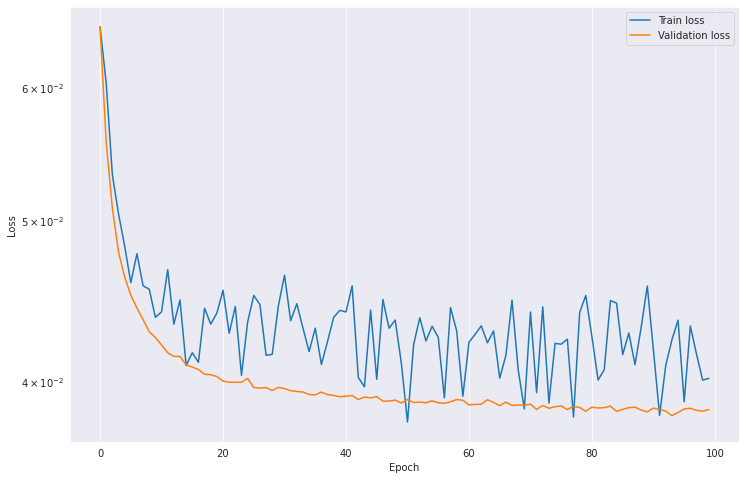

In [22]:
# Plot losses of the best model
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show() 


In [23]:
test_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn)

In [24]:
train_loss=train_loss_log[-1]
val_loss=val_loss_log[-1]
print("Train Loss:\t",round(float(train_loss),3))
print("Val Loss:\t",round(float(val_loss),3))
print("Test Loss:\t",round(float(test_loss),3))

Train Loss:	 0.04
Val Loss:	 0.039
Test Loss:	 0.039


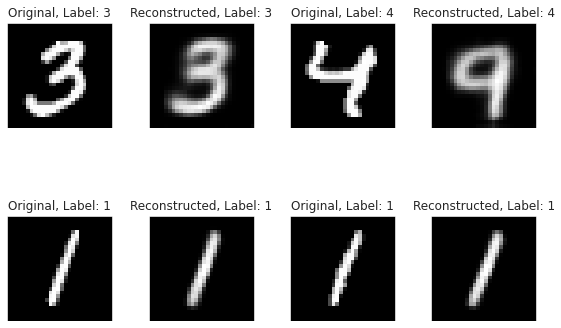

In [25]:
### Plot some sample
fig, axs = plt.subplots(2, 4, figsize=(8,6))
for ax in axs:
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(test_dataset)
    img1 = img[0]
    with torch.no_grad():
        encoded_img  = encoder(img.unsqueeze(0).to(device))
        decoded_img  = decoder(encoded_img)
    
    ax[0].imshow(np.array(img1), cmap='gist_gray')
    ax[0].set_title('Original, Label: %d' % label)
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[1].set_title('Reconstructed, Label: %d' % label)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    img, label = random.choice(test_dataset)
    img1 = img[0]
    with torch.no_grad():
        encoded_img  =encoder(img.unsqueeze(0).to(device))
        decoded_img  =decoder(encoded_img)
    
    ax[2].imshow(np.array(img1), cmap='gist_gray')
    ax[2].set_title('Original, Label: %d' % label)
    ax[2].set_xticks([])
    ax[2].set_yticks([])

    ax[3].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[3].set_title('Reconstructed, Label: %d' % label)
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    
    
plt.tight_layout()

# Network Analysis

If you have a previously saved network, restore the network parameters.

In [26]:
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

The encoder can be used to evaluate the latent space values for each of the test images. Since we used an encoded space dimension of 2, the encoder maps an entire image to just 2 floating point numbers.

We also save the corresponding label to show how each digit is mapped in the encoded space.

In [27]:
### Get the encoded representation of the test samples
encoded_samples = []
enc_aut = np.zeros(encoded_space_dim+1)
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    enc_aut = np.vstack( (enc_aut, np.hstack( (encoded_img, label)) ) )

100%|██████████| 10000/10000 [00:07<00:00, 1405.08it/s]


For convenience (not required), convert the result to a table format (`pandas.DataFrame`):

In [28]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

Enc. Variable 0  Enc. Variable 1  label
0            9.012648         1.060300      7
1            0.142933        -0.013474      2
2           10.109396       -41.378048      1
3           -4.604393         6.791766      0
4            2.872335         3.139371      4
...               ...              ...    ...
9995        -0.053527         0.252063      2
9996         0.070349        -0.161850      3
9997        27.347897        37.133503      4
9998       -19.505226        -5.639075      5
9999        -1.156462         4.123057      6

[10000 rows x 3 columns]

This graph shows where each input image is mapped in the encoded space. Since we have just 2 encoded variables, we can easily plot them in a bidimensional space. 

In [29]:
import plotly.express as px
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

As you can see from the graph, even if we never used the labels (i.e. the actual digit written in the image) during the training, the network has been able to clusterize quite well the different classes.

> **NOTE**
> 
> The encoded space may have many more variables. In this case you can still have a visual representation of the encoded space by applying a dimensionality reduction method, such as:
- [Princiapal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [t-distributed Stochastic Neighbor Embedding (t-SNE)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)




While the encoder is able to map the image to the encoded space, the decoder can do the opposite, generating an image given the corresponding latent space values.

The latent space can also be manually customized, like in the following example, where we generate images with the decoder by providing custom latent space variables.

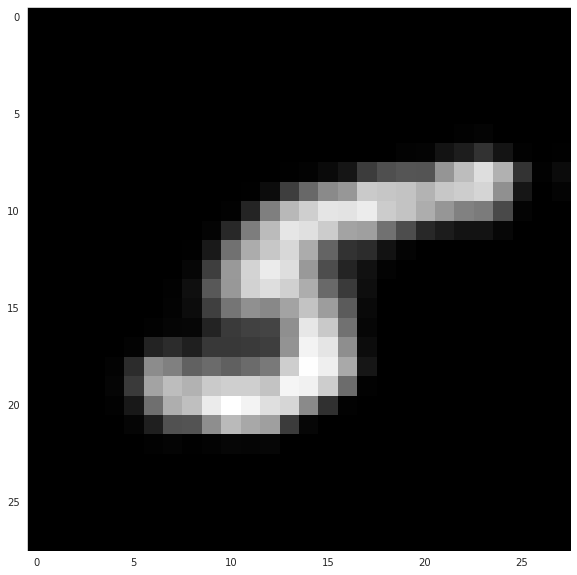

In [30]:
if encoded_space_dim == 2:
    # Generate a custom sample
    custom_encoded_sample = [-40, -10.0]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    # Decode sample
    decoder.eval()
    with torch.no_grad():
        generated_img  = decoder(encoded_value)
    
    plt.figure(figsize=(12,10))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.grid()
    plt.show()

In [31]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.patches import Ellipse
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)

# PCA
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(encoded_samples.iloc[:,0:encoded_space_dim])
columns = [ f'Enc. Variable {i}' for i in range(n_components)]
compressed_samples = pd.DataFrame( pca.transform(encoded_samples.iloc[:,0:encoded_space_dim]), columns=columns )

if n_components == 2:
    fig = px.scatter(compressed_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)
elif n_components == 3:
    fig = px.scatter_3d(compressed_samples,  x='Enc. Variable 0', y='Enc. Variable 1', z='Enc. Variable 2',
                    color=encoded_samples.label.astype(str), opacity=0.7)
fig.show()

In [32]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)

# TSNE
n_components = 2
tsne = TSNE(n_components=n_components)
tsne.fit(encoded_samples.iloc[:, 0:encoded_space_dim])
columns = [ f'Enc. Variable {i}' for i in range(n_components)]
compressed_samples = pd.DataFrame( tsne.fit_transform(encoded_samples.iloc[:,0:encoded_space_dim]), columns=columns )

if n_components == 2:
    fig = px.scatter(compressed_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)
elif n_components == 3:
    fig = px.scatter_3d(compressed_samples,  x='Enc. Variable 0', y='Enc. Variable 1', z='Enc. Variable 2',
                    color=encoded_samples.label.astype(str), opacity=0.7)
fig.show()

In [ ]:
""""""""""""""""
borrar
compr = pca.transform(enc_aut[:,:encoded_space_dim]) 
compr = np.hstack( (compr, enc_aut[:, -1].reshape(10001, 1) ) )
pca_aut = np.zeros(4)
for i in range(10):
    means = compr[ compr[:, -1]==i ].mean(axis=0)
    stds = compr[ compr[:, -1]==i ].std(axis=0)
    tot = np.hstack( (means[:2], stds[:2]) )
    pca_aut = np.vstack( (pca_aut, tot) )
    
pca_aut = pca_aut[1:, :]

compr = tsne.fit_transform(enc_aut[:,:encoded_space_dim]) 
compr = np.hstack( (compr, enc_aut[:, -1].reshape(10001, 1) ) )
tsne_aut = np.zeros(4)
for i in range(10):
    means = compr[ compr[:, -1]==i ].mean(axis=0)
    stds = compr[ compr[:, -1]==i ].std(axis=0)
    tot = np.hstack( (means[:2], stds[:2]) )
    tsne_aut = np.vstack( (tsne_aut, tot) )
    
tsne_aut = tsne_aut[1:, :]
# Average difference of the two standard deviation along the two dimension.
avg_diff = [ np.abs(pca_aut[:, 2]- pca_aut[:, 3]).mean() , np.abs(tsne_aut[:, 2]- tsne_aut[:, 3]).mean() ]
print(avg_diff)

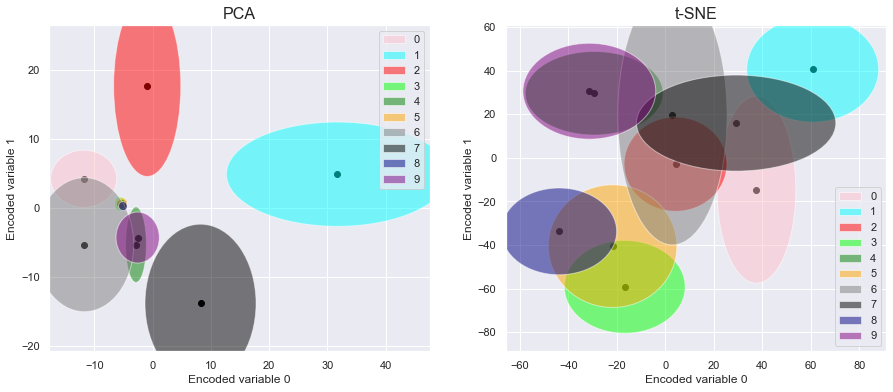

In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""
borrar
colors = ['pink', 'cyan', 'red', 'lime', 'green', 'orange', 'gray', 'black', 'navy', 'purple']

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
for i in range(10):
    ellipse = Ellipse((pca_aut[i, 0], pca_aut[i, 1]), width=pca_aut[i, 2] * 2, height=pca_aut[i, 3] * 2, 
                      alpha=0.5, facecolor = colors[i], label=str(i))
    
    ax[0].add_patch(ellipse)
ax[0].legend()
    
ax[0].scatter(pca_aut[:, 0], pca_aut[:, 1], color='black')
ax[0].set_xlim( (1.5*pca_aut[:, 0].min(), 1.5*pca_aut[:, 0].max()) )
ax[0].set_ylim( (1.5*pca_aut[:, 1].min(), 1.5*pca_aut[:, 1].max()) )
ax[0].set_xlabel('Encoded variable 0')
ax[0].set_ylabel('Encoded variable 1')
ax[0].set_title('PCA', fontsize=16)

for i in range(10):
    ellipse = Ellipse((tsne_aut[i, 0], tsne_aut[i, 1]), width=tsne_aut[i, 2] * 2, height=tsne_aut[i, 3] * 2, 
                      alpha=0.5, facecolor = colors[i], label=str(i))
    
    ax[1].add_patch(ellipse)
ax[1].legend()
    
ax[1].scatter(tsne_aut[:, 0], tsne_aut[:, 1], color='black')
ax[1].set_xlim( (1.5*tsne_aut[:, 0].min(), 1.5*tsne_aut[:, 0].max()) )
ax[1].set_ylim( (1.5*tsne_aut[:, 1].min(), 1.5*tsne_aut[:, 1].max()) )
ax[1].set_xlabel('Encoded variable 0')
ax[1].set_ylabel('Encoded variable 1')
ax[1].set_title('t-SNE', fontsize=16)

plt.show()

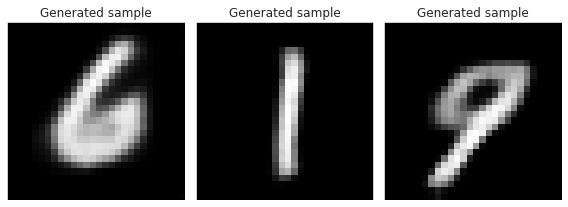

In [33]:
# Generation of new samples
### Plot some sample
fig, ax = plt.subplots(1, 3, figsize=(8,6))
img, label = random.choice(test_dataset)
img1 = img[0]
with torch.no_grad():
    encoded_img  = encoder(img.unsqueeze(0).to(device))
    decoded_img  = decoder(20*torch.randn_like(encoded_img).to(device) )

ax[0].imshow( decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
ax[0].set_title('Generated sample' )
ax[0].set_xticks([])
ax[0].set_yticks([])

with torch.no_grad():
    decoded_img  = decoder(20*torch.randn_like(encoded_img).to(device) )

ax[1].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
ax[1].set_title('Generated sample' )
ax[1].set_xticks([])
ax[1].set_yticks([])

img, label = random.choice(test_dataset)
img1 = img[0]
with torch.no_grad():
    decoded_img  = decoder(20*torch.randn_like(encoded_img).to(device) )

ax[2].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
ax[2].set_title('Generated sample' )
ax[2].set_xticks([])
ax[2].set_yticks([])
    
    
plt.tight_layout()

# Fine tuning

In [34]:
new_layer = nn.Linear(encoded_space_dim,10)

In [35]:
# Disallow the update of all the layers by setting the 'requires_grad' parameter of the tensors to 'False'
for param_name, param in encoder.named_parameters():
    param.requires_grad = False
    
# Allow the training of the last layers (classifier[4] and classifier[6])
for param in encoder.encoder_lin[2].parameters():
    param.requires_grad = True

for param in encoder.encoder_lin[0].parameters():
    param.requires_grad = True

# Check if correct
for param_name, param in encoder.named_parameters():
    print('%s \t- requires_grad=%s' % (param_name, param.requires_grad))

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

#moving both the encoder and the layer for classification to GPU
new_layer.to(device)

# Define the loss function
loss_sup = nn.CrossEntropyLoss()

#optimize the parameters of both the encoder and the layer fot classification
params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': new_layer.parameters()}
    ]

optimizer_sup = torch.optim.Adam(params_to_optimize, lr=1e-3)
    

encoder_cnn.0.weight 	- requires_grad=False
encoder_cnn.0.bias 	- requires_grad=False
encoder_cnn.3.weight 	- requires_grad=False
encoder_cnn.3.bias 	- requires_grad=False
encoder_cnn.6.weight 	- requires_grad=False
encoder_cnn.6.bias 	- requires_grad=False
encoder_lin.0.weight 	- requires_grad=True
encoder_lin.0.bias 	- requires_grad=True
encoder_lin.3.weight 	- requires_grad=False
encoder_lin.3.bias 	- requires_grad=False
Training device: cuda


In [36]:
def supervised_train(encoderr, layer_new, supervised_train_dat):
    acc_batch_train =[]
    loss_batch_train =[]
    encoderr.train()
    layer_new.train()
    for sample_batched in supervised_train_dat:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        x = encoderr(x_batch)
        out = layer_new(x)

        # Compute loss
        loss = loss_sup(out, label_batch)

        # Backpropagation
        encoderr.zero_grad()
        layer_new.zero_grad()
        loss.backward()

        # Update the weights
        optimizer_sup.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        loss_batch_train.append(loss_batch)

        #get the accuracy for this batch
        pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
        right = np.sum(pred == np.array(label_batch.cpu()))
        acc_batch_train.append(right)
    return acc_batch_train, loss_batch_train

In [37]:
def supervise_validation(encoderr, layer_new, supervised_val_dat):
    acc_batch_val = []
    loss_batch_val = []
    encoderr.eval()
    layer_new.eval()
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in val_dataloader_sup:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            x = encoderr(x_batch)
            out = layer_new(x)

            # Compute loss
            loss = loss_sup(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            loss_batch_val.append(loss_batch)

            #get the accuracy for the val
            pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
            right = np.sum(pred == np.array(label_batch.cpu()))
            acc_batch_val.append(right)
    return acc_batch_val, loss_batch_val

In [62]:
#supervised
alpha = 0.2
split = int(len(train_dataset) * 0.33)
train_set, val_set = torch.utils.data.random_split(train_dataset, [len(train_dataset)-split, split])

print('Samples in training set:',len(train_set))
print('Samples in validation set:',len(val_set))

Samples in training set: 40200
Samples in validation set: 19800


In [63]:
#apply transformation to train dataset and test dataset
train_set.transform = train_transform
val_set.transform = train_transform

#define train dataloader enabling the shuffle of the data
train_dataloader_sup = DataLoader(train_set, batch_size=256, shuffle=True)
#define test dataloader without shuffle the data
val_dataloader_sup = DataLoader(val_set, batch_size=len(val_set), shuffle=False)

In [65]:
### TRAINING LOOP
num_epochs = 60

acc_train = 0
acc_val = 0

train_loss_log = []
val_loss_log = []

for epoch_num in range(num_epochs):
    # Training mode 
    acc_train, train_loss = supervised_train(encoder, new_layer, train_dataloader_sup)

    # Save average train loss
    train_loss = np.mean(train_loss)
    train_loss_log.append(train_loss)

    # Evaluation mode (e.g. disable dropout)
    acc_val, val_loss = supervise_validation(encoder, new_layer, val_dataloader_sup)

    # Save average validation loss
    val_loss = np.mean(val_loss)
    val_loss_log.append(val_loss)

    print("Epoch", epoch_num + 1, "= Average train loss:[", train_loss, "] ","Average validation loss: [", val_loss, "]")

print("\n")

Epoch 1 = Average train loss:[ 0.337165 ]  Average validation loss: [ 0.28510013 ]
Epoch 2 = Average train loss:[ 0.33329654 ]  Average validation loss: [ 0.2810851 ]
Epoch 3 = Average train loss:[ 0.33584452 ]  Average validation loss: [ 0.2807175 ]
Epoch 4 = Average train loss:[ 0.32275864 ]  Average validation loss: [ 0.27915514 ]
Epoch 5 = Average train loss:[ 0.3272856 ]  Average validation loss: [ 0.27939552 ]
Epoch 6 = Average train loss:[ 0.32187325 ]  Average validation loss: [ 0.27376375 ]
Epoch 7 = Average train loss:[ 0.32023016 ]  Average validation loss: [ 0.27378103 ]
Epoch 8 = Average train loss:[ 0.3084552 ]  Average validation loss: [ 0.27229434 ]
Epoch 9 = Average train loss:[ 0.3132667 ]  Average validation loss: [ 0.27055892 ]
Epoch 10 = Average train loss:[ 0.31029204 ]  Average validation loss: [ 0.27602404 ]
Epoch 11 = Average train loss:[ 0.30787164 ]  Average validation loss: [ 0.2705481 ]
Epoch 12 = Average train loss:[ 0.30467963 ]  Average validation loss: 

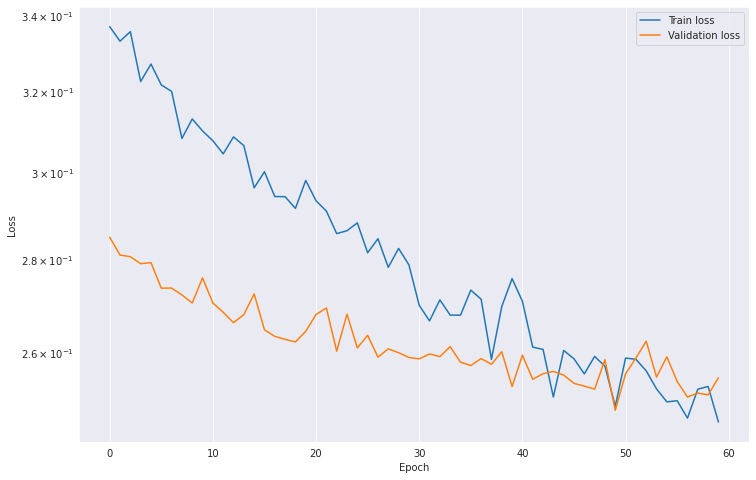

In [66]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [67]:
test_loss = []
test_acc = 0

y_test=[]
y_pred=[]

encoder.to(device)
#move the input to the GPU and predict the output
encoder.eval()
new_layer.eval()

with torch.no_grad(): # No need to track the gradients
    # Define the lists to store the outputs for each batch
    conc_out = []
    conc_label = []
    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        y = sample_batched[1].to(device)

        # Encode data
        x = encoder(x_batch)
        out = new_layer(x)

        y_test.append(y)
        y_pred.append(out)

        # Append the network output and the original image to the lists
        loss = loss_sup(out, y)
        test_loss.append(loss.detach().cpu().numpy())

        pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
        right = np.sum(pred == np.array(y.cpu()))
        test_acc = test_acc + right

    # Evaluate global loss
    test_loss = np.mean(test_loss)

print("Test loss MODEL:", float(test_loss))
print(" Accuracy of MODEL:", np.round(test_acc/len(test_dataset),5))


Test loss MODEL: 0.25256165862083435
 Accuracy of MODEL: 0.9521


In [68]:
from sklearn.metrics import confusion_matrix

# Build confusion matrix
cf_matrix = confusion_matrix( pred, y.cpu())

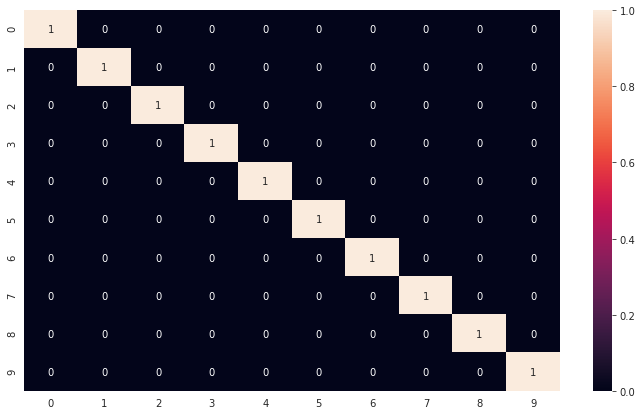

In [69]:
import seaborn as sns
classes = ('0', '1', '2', '3', '4',
        '5', '6', '7', '8', '9')

# Build confusion matrix
df_cm = pd.DataFrame(cf_matrix/ cf_matrix.sum(axis=1)[:, np.newaxis], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.savefig('output.png')